In [1]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)


def nearest_nonzero_idx(a,x,y):
    r,c = np.nonzero(a)
    min_idx = ((r - x)**2 + (c - y)**2).argmin()
    return r[min_idx], c[min_idx]


def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def ts_fromdebris_func(h, a, b, c):
        """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
        return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, a, b, c)
    return hd


def emergence_pixels(gf, vel_x_raw, vel_y_raw, icethickness_raw, xres, yres, 
                     vel_min=0, max_velocity=600, vel_depth_avg_factor=0.8, option_border=1,
                     positive_is_east=True, positive_is_north=True, constant_icethickness=False, debug=True):
    """ Compute the emergence velocity using an ice flux approach
    """
    # Glacier mask
    glac_mask = np.zeros(vel_x_raw.shape) + 1
    glac_mask[gf.z1.mask] = 0
    
    # Modify vel_y by multiplying velocity by -1 such that matrix operations agree with flow direction
    #    Specifically, a negative y velocity means the pixel is flowing south.
    #    However, if you were to subtract that value from the rows, it would head north in the matrix.
    #    This is due to the fact that the number of rows start at 0 at the top.
    #    Therefore, multipylying by -1 aligns the matrix operations with the flow direction
    if positive_is_north:
        vel_y = -1*vel_y_raw * vel_depth_avg_factor
    else:
        vel_y = vel_y_raw * vel_depth_avg_factor
    if positive_is_east:
        vel_x = vel_x_raw * vel_depth_avg_factor
    else:
        vel_x = -1*vel_x_raw * vel_depth_avg_factor
    vel_total = (vel_y**2 + vel_x**2)**0.5
    # Ice thickness
    icethickness = icethickness_raw.copy()
    if constant_icethickness:
        icethickness[:,:] = 1
        icethickness = icethickness * glac_mask
#     print('mean ice thickness:', np.round(icethickness.mean(),0), 'm')
    # Compute the initial volume
    volume_initial = icethickness * (xres * yres)
    pix_maxres = xres
    if yres > pix_maxres:
        pix_maxres = yres
    # Quality control options:
    # Apply a border based on the max specified velocity to prevent errors associated with pixels going out of bounds
    if option_border == 1:
        border = int(max_velocity / pix_maxres) + 1
        for r in range(vel_x.shape[0]):
            for c in range(vel_x.shape[1]):
                if (r < border) | (r >= vel_x.shape[0] - border) | (c < border) | (c >= vel_x.shape[1] - border):
                    vel_x[r,c] = 0
                    vel_y[r,c] = 0
    # Minimum/maximum velocity bounds
    vel_x[vel_total < vel_min] = 0
    vel_y[vel_total < vel_min] = 0
    vel_x[vel_total > max_velocity] = 0
    vel_y[vel_total > max_velocity] = 0
#     # Remove clusters of high velocity on stagnant portions of glaciers due to feature tracking of ice cliffs and ponds
#     if option_stagnantbands == 1:
#         vel_x[bands <= stagnant_band] = 0
#         vel_y[bands <= stagnant_band] = 0        
    # Compute displacement in units of pixels
    vel_x_pix = vel_x / xres
    vel_y_pix = vel_y / yres
    # Compute the displacement and fraction of pixels moved for all columns (x-axis)
    # col_x1 is the number of columns to the closest pixel receiving ice [ex. 2.6 returns 2, -2.6 returns -2]
    #    int() automatically rounds towards zero
    col_x1 = vel_x_pix.astype(int)
    # col_x2 is the number of columns to the further pixel receiving ice [ex. 2.6 returns 3, -2.6 returns -3]
    #    np.sign() returns a value of 1 or -1, so it's adding 1 pixel away from zero
    col_x2 = (vel_x_pix + np.sign(vel_x_pix)).astype(int)
    # rem_x2 is the fraction of the pixel that remains in the further pixel (col_x2) [ex. 2.6 returns 0.6, -2.6 returns 0.6]
    #    np.sign() returns a value of 1 or -1, so multiplying by that ensures you have a positive value
    #    then when you take the remainder using "% 1", you obtain the desired fraction
    rem_x2 = np.multiply(np.sign(vel_x_pix), vel_x_pix) % 1
    # rem_x1 is the fraction of the pixel that remains in the closer pixel (col_x1) [ex. 2.6 returns 0.4, -2.6 returns 0.4]
    rem_x1 = 1 - rem_x2
    # Repeat the displacement and fraction computations for all rows (y-axis)
    row_y1 = vel_y_pix.astype(int)
    row_y2 = (vel_y_pix + np.sign(vel_y_pix)).astype(int)
    rem_y2 = np.multiply(np.sign(vel_y_pix), vel_y_pix) % 1
    rem_y1 = 1 - rem_y2
          
    # Compute the mass flux for each pixel
    volume_final = np.zeros(volume_initial.shape)
    for r in range(vel_x.shape[0]):
        for c in range(vel_x.shape[1]):
            volume_final[r+row_y1[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x1[r,c]] + rem_y1[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x1[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x1[r,c]] + rem_y2[r,c]*rem_x1[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y1[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y1[r,c], c+col_x2[r,c]] + rem_y1[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
            volume_final[r+row_y2[r,c], c+col_x2[r,c]] = (
                volume_final[r+row_y2[r,c], c+col_x2[r,c]] + rem_y2[r,c]*rem_x2[r,c]*volume_initial[r,c]
                )
         
    # Redistribute off-glacier volume back onto the nearest pixel on the glacier
    offglac_row, offglac_col = np.where((glac_mask == 0) & (volume_final > 0))
    for nidx in range(0,len(offglac_row)):
        nrow = offglac_row[nidx]
        ncol = offglac_col[nidx]
        ridx, cidx = nearest_nonzero_idx(glac_mask, nrow, ncol)
        # Add off-glacier volume back onto nearest pixel on glacier
        volume_final[ridx,cidx] += volume_final[nrow,ncol]
        volume_final[nrow,ncol] = 0
            
    # Check that mass is conserved (threshold = 0.1 m x pixel_size**2)
    if debug:
        print('Mass is conserved?', np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() < 0.01)
        print(np.round(np.absolute(volume_final.sum() - volume_initial.sum()),1), 
              np.round(np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() * 100,2), '%')
        
    if np.absolute(volume_final.sum() - volume_initial.sum()) / volume_initial.sum() > 0.01:
        print('MASS NOT CONSERVED FOR EMERGENCE VELOCITY')
    # Final ice thickness
    icethickness_final = volume_final / (xres * yres)
    # Emergence velocity
    emergence_velocity = icethickness_final - icethickness
    return emergence_velocity



class GlacFeat:
    def __init__(self, feat, glacname_fieldname, glacnum_fieldname):

        self.glacname = feat.GetField(glacname_fieldname)
        if self.glacname is None:
            self.glacname = ""
        else:
            #RGI has some nonstandard characters
            #self.glacname = self.glacname.decode('unicode_escape').encode('ascii','ignore')
            #glacname = re.sub(r'[^\x00-\x7f]',r'', glacname)
            self.glacname = re.sub(r'\W+', '', self.glacname)
            self.glacname = self.glacname.replace(" ", "")
            self.glacname = self.glacname.replace("_", "")
            self.glacname = self.glacname.replace("/", "")

        self.glacnum = feat.GetField(glacnum_fieldname)
        fn = feat.GetDefnRef().GetName()
        #RGIId (String) = RGI50-01.00004
        self.glacnum = '%0.5f' % float(self.glacnum.split('-')[-1])

        if self.glacname:
            self.feat_fn = "%s_%s" % (self.glacnum, self.glacname)
        else:
            self.feat_fn = str(self.glacnum)

        self.glac_geom_orig = geolib.geom_dup(feat.GetGeometryRef())
        self.glac_geom = geolib.geom_dup(self.glac_geom_orig)
        #Hack to deal with fact that this is not preserved in geom when loaded from pickle on disk
        self.glac_geom_srs_wkt = self.glac_geom.GetSpatialReference().ExportToWkt()

        #Attributes written by mb_calc
        self.z1 = None
        self.z1_hs = None
        self.z1_stats = None
        self.z1_ela = None
        self.z2 = None
        self.z2_hs = None
        self.z2_stats = None
        self.z2_ela = None
        self.z2_aspect = None
        self.z2_aspect_stats = None
        self.z2_slope = None
        self.z2_slope_stats = None
        self.res = None
        self.dhdt = None
        self.mb = None
        self.mb_mean = None
        self.t1 = None
        self.t2 = None
        self.dt = None
        self.t1_mean = None
        self.t2_mean = None
        self.dt_mean = None

        self.H = None
        self.H_mean = np.nan
        self.vx = None
        self.vy = None
        self.vm = None
        self.vm_mean = np.nan
        self.divQ = None
        self.emvel = None
        self.debris_class = None
        self.debris_thick = None
        self.debris_thick_mean = np.nan
        self.perc_clean = np.nan
        self.perc_debris = np.nan
        self.perc_pond = np.nan

    def geom_srs_update(self, srs=None):
        if self.glac_geom.GetSpatialReference() is None:
            if srs is None:
                srs = osr.SpatialReference()
                srs.ImportFromWkt(self.glac_geom_srs_wkt)
            self.glac_geom.AssignSpatialReference(srs)

    def geom_attributes(self, srs=None):
        self.geom_srs_update()
        if srs is not None:
            #Should reproject here to equal area, before geom_attributes
            #self.glac_geom.AssignSpatialReference(glac_shp_srs)
            #self.glac_geom_local = geolib.geom2localortho(self.glac_geom)
            geolib.geom_transform(self.glac_geom, srs)

        self.glac_geom_extent = geolib.geom_extent(self.glac_geom)
        self.glac_area = self.glac_geom.GetArea()
        self.glac_area_km2 = self.glac_area / 1E6
        self.cx, self.cy = self.glac_geom.Centroid().GetPoint_2D()
        

#RGI uses 50 m bins
def hist_plot(gf, bin_width=50.0, dz_clim=(-2.0, 2.0), exportcsv=True, csv_ending='', mb_df=None, outdir_csv=None):
    #print("Generating histograms")
    #Create bins for full range of input data and specified bin width

    #NOTE: these counts/areas are for valid pixels only
    #Not necessarily a true representation of actual glacier hypsometry
    #Need a void-filled DEM for this
    if mb_df is not None:
        # Align bins with mass balance data
        bin_center_min = mb_df.loc[0,'bin_center_elev_m']
        while bin_center_min > gf.z1.min() + bin_width/2:
            bin_center_min -= mb_bin_size
        bin_center_max = mb_df['bin_center_elev_m'].values[-1]
        while bin_center_max < gf.z1.max():
            bin_center_max += mb_bin_size    
        z_bin_centers = np.arange(bin_center_min, bin_center_max + mb_bin_size/2, mb_bin_size)
        z_bin_edges = np.arange(bin_center_min - mb_bin_size / 2, bin_center_max + mb_bin_size, mb_bin_size)
    else:
        z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
        
    #Need to compress here, otherwise histogram uses masked values!
    z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
    z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
    #RGI standard is integer thousandths of glaciers total area
    #Should check to make sure sum of bin areas equals total area
    #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
    z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)

    #If we only have one elevation grid with dhdt
    if gf.z2 is not None:
        z2_bin_counts, z2_bin_edges = np.histogram(gf.z2.compressed(), bins=z_bin_edges)
        z2_bin_areas = z2_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #z2_bin_areas_perc = 100. * z2_bin_areas / np.sum(z2_bin_areas)
        z2_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
    else:
        z2_bin_counts = z1_bin_counts
        z2_bin_edges = z1_bin_edges
        z2_bin_areas = z1_bin_areas
        z2_bin_areas_perc = z1_bin_areas_perc
        
    if gf.dc_area is not None:
#         z_bin_edges, z_bin_centers = malib.get_bins(gf.z1, bin_width)
#         #Need to compress here, otherwise histogram uses masked values!
#         z1_bin_counts, z1_bin_edges = np.histogram(gf.z1.compressed(), bins=z_bin_edges)
#         z1_bin_areas = z1_bin_counts * gf.res[0] * gf.res[1] / 1E6
#         #RGI standard is integer thousandths of glaciers total area
#         #Should check to make sure sum of bin areas equals total area
#         #z1_bin_areas_perc = 100. * z1_bin_areas / np.sum(z1_bin_areas)
#         z1_bin_areas_perc = 100. * (z1_bin_areas / gf.glac_area_km2)
        
# #         dc_bin_edges, dc_bin_centers = malib.get_bins(gf.dc_area, bin_width)
        dc_bin_counts, dc_bin_edges = np.histogram(gf.dc_area.compressed(), bins=z_bin_edges)
        dc_bin_areas = dc_bin_counts * gf.res[0] * gf.res[1] / 1E6
        #RGI standard is integer thousandths of glaciers total area
        dc_bin_areas_perc = 100. * (dc_bin_areas / gf.glac_area_km2)

    #Create arrays to store output
    slope_bin_med = np.ma.masked_all_like(z1_bin_areas)
    slope_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_med = np.ma.masked_all_like(z1_bin_areas)
    aspect_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.dhdt is not None:
        mb_bin_med = np.ma.masked_all_like(z1_bin_areas)
        np.ma.set_fill_value(mb_bin_med, np.nan)
        mb_bin_mad = np.ma.masked_all_like(mb_bin_med)
        mb_bin_mean = np.ma.masked_all_like(mb_bin_med)
        mb_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_med = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mad = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_mean = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_std = np.ma.masked_all_like(mb_bin_med)
        dhdt_bin_count = np.ma.masked_all_like(mb_bin_med)
    if gf.vm is not None:
        vm_bin_med = np.ma.masked_all_like(z1_bin_areas)
        vm_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.H is not None:
        H_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        H_bin_std = np.ma.masked_all_like(z1_bin_areas)
    if gf.emvel is not None:
        emvel_bin_mean = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_std = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_med = np.ma.masked_all_like(z1_bin_areas)
        emvel_bin_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.debris_class is not None:
#         perc_clean = np.ma.masked_all_like(z1_bin_areas)
#         perc_debris = np.ma.masked_all_like(z1_bin_areas)
#         perc_pond = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_mad = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_clean_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_debris_bin_med = np.ma.masked_all_like(z1_bin_areas)
#         dhdt_pond_bin_med = np.ma.masked_all_like(z1_bin_areas)

#         gf.dhdt_clean = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 1).data))
#         gf.dhdt_debris = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 2).data))
#         gf.dhdt_pond = np.ma.array(gf.dhdt, mask=~((gf.debris_class == 3).data))

    if gf.debris_thick_ts is not None:
        debris_thick_ts_mean = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_std = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_med = np.ma.masked_all_like(z1_bin_areas)
        debris_thick_ts_mad = np.ma.masked_all_like(z1_bin_areas)
    if gf.meltfactor_ts is not None:
        meltfactor_ts_med = np.ma.masked_all_like(z1_bin_areas)
        meltfactor_ts_mad = np.ma.masked_all_like(z1_bin_areas)

    #Bin sample count must be greater than this value
    min_bin_samp_count = 9

    #Loop through each bin and extract stats
    idx = np.digitize(gf.z1, z_bin_edges)
    for bin_n in range(z_bin_centers.size):
        if gf.dhdt is not None:
            mb_bin_samp = gf.mb_map[(idx == bin_n+1)]
            if mb_bin_samp.count() > min_bin_samp_count:
                mb_bin_med[bin_n] = malib.fast_median(mb_bin_samp)
                mb_bin_mad[bin_n] = malib.mad(mb_bin_samp)
                mb_bin_mean[bin_n] = mb_bin_samp.mean()
                mb_bin_std[bin_n] = mb_bin_samp.std()
            dhdt_bin_samp = gf.dhdt[(idx == bin_n+1)]
            if dhdt_bin_samp.count() > min_bin_samp_count:
                dhdt_bin_med[bin_n] = malib.fast_median(dhdt_bin_samp)
                dhdt_bin_mad[bin_n] = malib.mad(dhdt_bin_samp)
                dhdt_bin_mean[bin_n] = dhdt_bin_samp.mean()
                dhdt_bin_std[bin_n] = dhdt_bin_samp.std()
                dhdt_bin_count[bin_n] = dhdt_bin_samp.count()
        if gf.debris_thick is not None:
            debris_thick_bin_samp = gf.debris_thick[(idx == bin_n+1)]
            if debris_thick_bin_samp.size > min_bin_samp_count:
                debris_thick_med[bin_n] = malib.fast_median(debris_thick_bin_samp)
                debris_thick_mad[bin_n] = malib.mad(debris_thick_bin_samp)
        
        if gf.debris_thick_ts is not None:
            debris_thick_ts_bin_samp = gf.debris_thick_ts[(idx == bin_n+1)]
            if debris_thick_ts_bin_samp.size > min_bin_samp_count:
                debris_thick_ts_mean[bin_n] = debris_thick_ts_bin_samp.mean()
                debris_thick_ts_std[bin_n] = debris_thick_ts_bin_samp.std()
                debris_thick_ts_med[bin_n] = malib.fast_median(debris_thick_ts_bin_samp)
                debris_thick_ts_mad[bin_n] = malib.mad(debris_thick_ts_bin_samp)
        if gf.meltfactor_ts is not None:
            meltfactor_ts_bin_samp = gf.meltfactor_ts[(idx == bin_n+1)]
            if meltfactor_ts_bin_samp.size > min_bin_samp_count:
                meltfactor_ts_med[bin_n] = malib.fast_median(meltfactor_ts_bin_samp)
                meltfactor_ts_mad[bin_n] = malib.mad(meltfactor_ts_bin_samp)
        
        if gf.debris_class is not None:
            debris_class_bin_samp = gf.debris_class[(idx == bin_n+1)]
            dhdt_clean_bin_samp = gf.dhdt_clean[(idx == bin_n+1)]
            dhdt_debris_bin_samp = gf.dhdt_debris[(idx == bin_n+1)]
            dhdt_pond_bin_samp = gf.dhdt_pond[(idx == bin_n+1)]
            if debris_class_bin_samp.count() > min_bin_samp_count:
                perc_clean[bin_n] = 100. * (debris_class_bin_samp == 1).sum()/debris_class_bin_samp.count()
                perc_debris[bin_n] = 100. * (debris_class_bin_samp == 2).sum()/debris_class_bin_samp.count()
                perc_pond[bin_n] = 100. * (debris_class_bin_samp == 3).sum()/debris_class_bin_samp.count()
            if dhdt_clean_bin_samp.count() > min_bin_samp_count:
                dhdt_clean_bin_med[bin_n] = malib.fast_median(dhdt_clean_bin_samp)
            if dhdt_debris_bin_samp.count() > min_bin_samp_count:
                dhdt_debris_bin_med[bin_n] = malib.fast_median(dhdt_debris_bin_samp)
            if dhdt_pond_bin_samp.count() > min_bin_samp_count:
                dhdt_pond_bin_med[bin_n] = malib.fast_median(dhdt_pond_bin_samp)
        if gf.vm is not None:
            vm_bin_samp = gf.vm[(idx == bin_n+1)]
            if vm_bin_samp.size > min_bin_samp_count:
                vm_bin_med[bin_n] = malib.fast_median(vm_bin_samp)
                vm_bin_mad[bin_n] = malib.mad(vm_bin_samp)
        if gf.H is not None:
            H_bin_samp = gf.H[(idx == bin_n+1)]
            if H_bin_samp.size > min_bin_samp_count:
                H_bin_mean[bin_n] = H_bin_samp.mean()
                H_bin_std[bin_n] = H_bin_samp.std()
        if gf.emvel is not None:
            emvel_bin_samp = gf.emvel[(idx == bin_n+1)]
            if emvel_bin_samp.size > min_bin_samp_count:
                emvel_bin_mean[bin_n] = emvel_bin_samp.mean()
                emvel_bin_std[bin_n] = emvel_bin_samp.std()
                emvel_bin_med[bin_n] = malib.fast_median(emvel_bin_samp)
                emvel_bin_mad[bin_n] = malib.mad(emvel_bin_samp)
        slope_bin_samp = gf.z1_slope[(idx == bin_n+1)]
        if slope_bin_samp.size > min_bin_samp_count:
            slope_bin_med[bin_n] = malib.fast_median(slope_bin_samp)
            slope_bin_mad[bin_n] = malib.mad(slope_bin_samp)
        aspect_bin_samp = gf.z1_aspect[(idx == bin_n+1)]
        if aspect_bin_samp.size > min_bin_samp_count:
            aspect_bin_med[bin_n] = malib.fast_median(aspect_bin_samp)
            aspect_bin_mad[bin_n] = malib.mad(aspect_bin_samp)

    if gf.dhdt is not None:
        dhdt_bin_areas = dhdt_bin_count * gf.res[0] * gf.res[1] / 1E6
        #dhdt_bin_areas_perc = 100. * dhdt_bin_areas / np.sum(dhdt_bin_areas)
        dhdt_bin_areas_perc = 100. * (dhdt_bin_areas / gf.glac_area_km2)

    outbins_header = 'bin_center_elev_m, z1_bin_count_valid, z1_bin_area_valid_km2, z1_bin_area_perc, z2_bin_count_valid, z2_bin_area_valid_km2, z2_bin_area_perc, slope_bin_med, aspect_bin_med'
    fmt = '%0.1f, %0.0f, %0.3f, %0.2f, %0.0f, %0.3f, %0.2f, %0.2f, %0.2f'
    outbins = [z_bin_centers, z1_bin_counts, z1_bin_areas, z1_bin_areas_perc, z2_bin_counts, z2_bin_areas, z2_bin_areas_perc, slope_bin_med, aspect_bin_med]
    if gf.dhdt is not None:
        outbins_header += ', dhdt_bin_count, dhdt_bin_area_valid_km2, dhdt_bin_area_perc, dhdt_bin_med_ma, dhdt_bin_mad_ma, dhdt_bin_mean_ma, dhdt_bin_std_ma, mb_bin_med_mwea, mb_bin_mad_mwea, mb_bin_mean_mwea, mb_bin_std_mwea'
        fmt += ', %0.0f, %0.3f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([dhdt_bin_count, dhdt_bin_areas, dhdt_bin_areas_perc, dhdt_bin_med, dhdt_bin_mad, dhdt_bin_mean, dhdt_bin_std, \
                        mb_bin_med, mb_bin_mad, mb_bin_mean, mb_bin_std])
    if gf.dc_area is not None:
        outbins_header += ', dc_bin_count_valid, dc_bin_area_valid_km2, dc_bin_area_perc'
        fmt += ', %0.0f, %0.3f, %0.2f'
        outbins.extend([dc_bin_counts, dc_bin_areas, dc_bin_areas_perc])
#         outbins.extend([z1_bin_counts, z1_bin_areas, z1_bin_areas_perc])
        
        
    if gf.debris_thick is not None:
        outbins_header += ', debris_thick_med_m, debris_thick_mad_m'
        fmt += ', %0.2f, %0.2f'
        debris_thick_med[debris_thick_med == -(np.inf)] = 0.00
        debris_thick_mad[debris_thick_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_med, debris_thick_mad])
    
    if gf.debris_thick_ts is not None:
        outbins_header += ',debris_thick_ts_mean_m,debris_thick_ts_std_m,debris_thick_ts_med_m,debris_thick_ts_mad_m'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
        debris_thick_ts_mean[debris_thick_ts_mean == -(np.inf)] = 0.00
        debris_thick_ts_std[debris_thick_ts_std == -(np.inf)] = 0.00
        debris_thick_ts_med[debris_thick_ts_med == -(np.inf)] = 0.00
        debris_thick_ts_mad[debris_thick_ts_mad == -(np.inf)] = 0.00
        outbins.extend([debris_thick_ts_mean, debris_thick_ts_std, debris_thick_ts_med, debris_thick_ts_mad])
    if gf.meltfactor_ts is not None:
        outbins_header += ',meltfactor_ts_med_m,meltfactor_ts_mad_m'
        fmt += ', %0.2f, %0.2f'
        meltfactor_ts_med[meltfactor_ts_med == -(np.inf)] = 1
        meltfactor_ts_med[meltfactor_ts_med > 1] = 1
        meltfactor_ts_med[meltfactor_ts_med <= 0] = 1
        meltfactor_ts_mad[meltfactor_ts_mad == -(np.inf)] = 0
        meltfactor_ts_mad[meltfactor_ts_mad > 1] = 0
        meltfactor_ts_mad[meltfactor_ts_mad <= 0] = 0
        outbins.extend([meltfactor_ts_med, meltfactor_ts_mad])
    
    if gf.debris_class is not None:
        outbins_header += ', perc_debris, perc_pond, perc_clean, dhdt_debris_med, dhdt_pond_med, dhdt_clean_med'
        fmt += ', %0.2f, %0.2f, %0.2f, %0.2f, %0.2f, %0.2f'
        outbins.extend([perc_debris, perc_pond, perc_clean, dhdt_debris_bin_med, dhdt_pond_bin_med, dhdt_clean_bin_med])
    if gf.vm is not None:
        outbins_header += ', vm_med, vm_mad'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([vm_bin_med, vm_bin_mad])
    if gf.H is not None:
        outbins_header += ', H_mean, H_std'
        fmt += ', %0.2f, %0.2f'
        outbins.extend([H_bin_mean, H_bin_std])
#         outbins_header += ', H_mean, H_std, emvel_mean, emvel_std'
#         fmt += ', %0.2f, %0.2f, %0.2f, %0.2f'
#         outbins.extend([H_bin_mean, H_bin_std, emvel_bin_mean, emvel_bin_std])

    if gf.emvel is not None:
        outbins_header += ', emvel_mean, emvel_std, emvel_med, emvel_mad'
        fmt += ', %0.3f, %0.3f, %0.3f, %0.3f'
        outbins.extend([emvel_bin_mean, emvel_bin_std, emvel_bin_med, emvel_bin_mad])
    
    outbins = np.ma.array(outbins).T.astype('float32')
    np.ma.set_fill_value(outbins, np.nan)
    outbins = outbins.filled(np.nan)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    outbins_df['debris_perc'] = outbins_df[' dc_bin_count_valid'] / outbins_df[' z1_bin_count_valid'] * 100
    
    if mb_df is not None:
        # ADD MASS BALANCE DATA
        mb_df = mb_df[np.isfinite(mb_df['bin_center_elev_m'])]
        mb_df.reset_index(inplace=True, drop=True)
        # start index for merge
        if mb_df.loc[0,'bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
            mb_df_idx1 = 0
            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[0,'bin_center_elev_m'])[0][0]
        else:
            outbins_idx1 = 0
            mb_df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == mb_df['bin_center_elev_m'])[0][0]
    #     print('idx1:', 
    #           '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx1, mb_df.loc[mb_df_idx1,'# bin_center_elev_m'])
        # end index for merge
        if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= mb_df.loc[mb_df.shape[0]-1,'bin_center_elev_m']:
            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == mb_df.loc[mb_df.shape[0]-1,'bin_center_elev_m'])[0][0]
            mb_df_idx2 = mb_df.shape[0]-1
        else:
            outbins_idx2 = outbins_df.shape[0]-1
            mb_df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == mb_df['bin_center_elev_m'])[0][0]
    #     print('idx2:', 
    #           '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
    #           '\ndfbins:', mb_df_idx2, mb_df.loc[mb_df_idx2,'# bin_center_elev_m'])
        outbins_df[' mb_bin_mean_mwea'] = np.nan
        outbins_df[' mb_bin_std_mwea'] = np.nan
        outbins_df[' mb_bin_area_valid_km2'] = np.nan
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_mean_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_mean_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_std_mwea'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' mb_bin_std_mwea']
        outbins_df.loc[outbins_idx1:outbins_idx2+1,' mb_bin_area_valid_km2'] = mb_df.loc[mb_df_idx1:mb_df_idx2+1,' z1_bin_area_valid_km2']
        try:
            outbins_df['startyear'] = mb_df.loc[mb_df_idx1,'startyear']
            outbins_df['endyear'] = mb_df.loc[mb_df_idx1,'endyear']
        except:
            outbins_df['startyear'] = 2000
            outbins_df['endyear'] = 2012
    
    if exportcsv:
        if int(gf.feat_fn.split('.')[0]) < 10:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:7] + csv_ending)
        else:
            outbins_fullfn = os.path.join(outdir_csv, gf.feat_fn[0:8] + csv_ending)
        outbins_df.to_csv(outbins_fullfn, index=False)
    
    outbins_df = pd.DataFrame(outbins, columns=outbins_header.split(','))
    
    return outbins_df, z_bin_edges

In [2]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# from imview.lib import pltlib

import globaldebris_input as input
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func

verbose=False
debug=False
extra_layers=True

outdir = input.output_fp + 'mb_bins/'
outdir_fig = outdir + '/figures/'
# outdir_csv = outdir + '/csv/'

if os.path.exists(outdir) == False:
    os.makedirs(outdir)
if os.path.exists(input.glac_shp_proj_fp) == False:
    os.makedirs(input.glac_shp_proj_fp)
# if os.path.exists(outdir_csv) == False:
#     os.makedirs(outdir_csv)
if os.path.exists(outdir_fig) == False:
    os.makedirs(outdir_fig)

# min_glac_area_writeout = input.min_glac_area_writeout
# min_valid_area_perc = input.min_valid_area_perc
# buff_dist = input.buff_dist
# # bin_width = input.emvel_bin_width
# #Surface to column average velocity scaling
# v_col_f = input.v_col_f
# csv_ending = input.output_ts_csv_ending
# emvel_filter_pixsize = input.emvel_filter_pixsize

# #INPUT
# glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
#                     '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
#                     '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
# glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)


# #DEM
# z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
#           'surface_DEMs_RGI60-XXXX/')
# z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# # Ice thickness
# huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
#                    'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
# huss_fn_sample = 'RGI60-XXXX_thickness.tif'
# #Surface velocity
# v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
# vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
# vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# # topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# # #Output directory
# # outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# # outdir_fig = outdir + '/figures/'
# outdir_csv = input.outdir_emvel_fp 
# outdir_fig = input.outdir_emvel_fp  + '../figures/'

# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)
# if os.path.exists(outdir_csv) == False:
#     os.makedirs(outdir_csv)
# if os.path.exists(outdir_fig) == False:
#     os.makedirs(outdir_fig)

In [3]:
rgiid_list = []
rgiid_fn_list = []
for i in os.listdir(input.mb_binned_fp):
    if i.endswith('mb_bins_wdc_emvel_offset.csv'):
        region = int(i.split('.')[0])
        if region in input.roi_rgidict[input.roi]:    
            if region < 10:
                rgiid_list.append(i[0:7])
            else:
                rgiid_list.append(i[0:8])
            rgiid_fn_list.append(i)
        
        
rgiid_list = sorted(rgiid_list)
rgiid_fn_list = sorted(rgiid_fn_list)

print(len(rgiid_list))

main_glac_rgi = input.selectglaciersrgitable(rgiid_list)
main_glac_rgi['CenLon_360'] = main_glac_rgi['CenLon']
main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'] = (
    360 + main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'])
main_glac_rgi['bin_fn'] = rgiid_fn_list

791
791 glaciers in region 1 are included in this model run: ['00013', '00021', '00037', '00041', '00042', '00556', '00570', '00571', '00660', '00670', '00675', '00688', '00703', '00704', '00709', '00732', '00739', '00746', '00780', '00787', '00792', '00799', '00814', '00852', '00865', '00870', '00871', '00903', '00942', '00951', '00960', '00962', '00982', '01050', '01077', '01104', '01150', '01153', '01162', '01182', '01223', '01242', '01268', '01275', '01276', '01277', '01282', '01284', '01292', '01306'] and more
This study is focusing on 791 glaciers in region [1]


In [4]:
# Latitude and longitude index to run the model
#  Longitude must be 0 - 360 degrees
latlon_all = []
for i in os.listdir(input.ostrem_fp):
    if i.endswith(input.ostrem_fn_sample.split('XXXX')[1]):
        latlon_fn = i.split(input.ostrem_fn_sample.split('XXXX')[1])[0]
        # Extract latitude
        lat_str = latlon_fn.split('-')[0]
        if 'N' in lat_str:
            i_lat = int(lat_str.split('N')[0]) / 100
        elif 'S' in lat_str:
            i_lat = -1 * int(lat_str.split('S')[0]) / 100
        # Extract longitude
        lon_str = latlon_fn.split('-')[1]
        i_lon = int(lon_str.split('E')[0]) / 100
        latlon_all.append([i_lat, i_lon, i])
latlon_all = sorted(latlon_all)

lat_all = np.array([x[0] for x in latlon_all])
lon_all = np.array([x[1] for x in latlon_all])
ostrem_fn_all_raw = [x[2] for x in latlon_all]

main_glac_rgi['lat_nearest'] = np.nan
main_glac_rgi['lon_nearest'] = np.nan
main_glac_rgi['ostrem_fn'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[6855]]):

#     if verbose:
#         print(nglac, glac_idx, main_glac_rgi.loc[glac_idx,'rgino_str'], 
#               main_glac_rgi.loc[glac_idx,'CenLat'], main_glac_rgi.loc[glac_idx,'CenLon'])
        
    latlon_dist = (((main_glac_rgi.loc[glac_idx,'CenLat'] - lat_all)**2 + 
                    (main_glac_rgi.loc[glac_idx,'CenLon_360'] - lon_all)**2)**0.5)
    latlon_nearidx = np.where(latlon_dist == latlon_dist.min())[0][0]
    
    main_glac_rgi.loc[glac_idx,'lat_nearest'] = lat_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'lon_nearest'] = lon_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'ostrem_fn'] = ostrem_fn_all_raw[latlon_nearidx]
    
ostrem_fn_all = sorted(list(np.unique(main_glac_rgi['ostrem_fn'].values)))

# Merge with debris cover stats
dc_shp = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])
dc_shp.reset_index(inplace=True, drop=True)

# main_glac_rgi['DC_Area_%'] = 0
dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area_%'].values))
main_glac_rgi['DC_Area_%'] = main_glac_rgi.RGIId.map(dc_areaperc_dict).fillna(0)

main_glac_rgi

,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,...,RefDate,glacno,rgino_str,RGIId_float,CenLon_360,bin_fn,lat_nearest,lon_nearest,ostrem_fn,DC_Area_%
GlacNo,,,,,,,,,,,,,,,,,,,,,
0,12,RGI60-01.00013,-146.684082,63.499329,1,2,209.630,823,4003,1848,...,20090703,13,01.00013,1.00013,213.315918,1.00013_mb_bins_wdc_emvel_offset.csv,63.50,213.25,6350N-21325E_debris_melt_curve.nc,17.84
1,20,RGI60-01.00021,-146.606262,63.404831,1,2,56.531,942,2584,1781,...,20090703,21,01.00021,1.00021,213.393738,1.00021_mb_bins_wdc_emvel_offset.csv,63.50,213.50,6350N-21350E_debris_melt_curve.nc,1.82
2,36,RGI60-01.00037,-146.528168,63.469173,1,2,234.583,722,3081,1841,...,20090703,37,01.00037,1.00037,213.471832,1.00037_mb_bins_wdc_emvel_offset.csv,63.50,213.50,6350N-21350E_debris_melt_curve.nc,13.54
3,40,RGI60-01.00041,-147.107000,63.657000,1,2,90.905,948,3734,1705,...,20090703,41,01.00041,1.00041,212.893000,1.00041_mb_bins_wdc_emvel_offset.csv,63.75,213.00,6375N-21300E_debris_melt_curve.nc,22.97
4,41,RGI60-01.00042,-147.579269,63.594097,1,2,83.656,830,3734,1578,...,20090703,42,01.00042,1.00042,212.420731,1.00042_mb_bins_wdc_emvel_offset.csv,63.50,212.50,6350N-21250E_debris_melt_curve.nc,15.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,26733,RGI60-01.26738,-140.388550,60.879704,1,5,718.416,792,5241,2416,...,20050812,26738,01.26738,1.26738,219.611450,1.26738_mb_bins_wdc_emvel_offset.csv,61.00,219.50,6100N-21950E_debris_melt_curve.nc,15.40
787,26738,RGI60-01.26743,-151.443481,62.802460,1,2,176.235,488,3740,1295,...,20100912,26743,01.26743,1.26743,208.556519,1.26743_mb_bins_wdc_emvel_offset.csv,62.75,208.50,6275N-20850E_debris_melt_curve.nc,28.09
788,26856,RGI60-01.26861,-134.732000,59.454000,1,6,3.545,1404,1879,1506,...,20050811,26861,01.26861,1.26861,225.268000,1.26861_mb_bins_wdc_emvel_offset.csv,59.50,225.25,5950N-22525E_debris_melt_curve.nc,12.14


In [5]:
# ===== ESTIMATE DEBRIS THICKNESS FOR ALL GLACIERS WITH OBSERVATIONS =====
add_debris2bins = False
plot_ostrem = True

if add_debris2bins:
    for nostrem, ostrem_fn in enumerate(ostrem_fn_all):
#     for nostrem, ostrem_fn in enumerate([ostrem_fn_all[200]]):
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[146]]): # Ngozumpa
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[154]]): # Khumbu
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[350]]): # Langtang
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[4043]]): # Baltoro

        print(nostrem, ostrem_fn)

        # ===== LOAD DAILY MELT DATA =====
        stats_idx = 0
        ds_ostrem = xr.open_dataset(input.ostrem_fp + ostrem_fn)

        # Select all glaciers that share the same Ostrem curve
        main_glac_rgi_subset = main_glac_rgi.loc[np.where(main_glac_rgi['ostrem_fn'] == ostrem_fn)[0],:]
        main_glac_rgi_subset.reset_index(inplace=True, drop=True)    

        for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
#         for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[1]]):
            glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
            rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
            region = glac_str.split('.')[0]
            if int(glac_str.split('.')[0]) < 10:
                glac_str = glac_str[1:]
                
            print(glac_str)

            mb_fn = glac_str + '_mb_bins_wdc_emvel_offset.csv'
            mb_df = pd.read_csv(input.mb_binned_fp + mb_fn)
            mb_df.loc[:,:] = mb_df.values.astype(np.float64)
            
            # ===== Ostrem Curve =====
            start_yearfrac = mb_df.startyear.values[0]
            end_yearfrac = mb_df.endyear.values[0]
            time_year = pd.to_datetime(ds_ostrem.time.values).year
            time_daysperyear = np.array([366 if x%4 == 0 else 365 for x in time_year])
            time_yearfrac = time_year + (pd.to_datetime(ds_ostrem.time.values).dayofyear-1) / time_daysperyear

            start_idx = np.where(abs(time_yearfrac - start_yearfrac) == abs(time_yearfrac - start_yearfrac).min())[0][0]
            end_idx = np.where(abs(time_yearfrac - end_yearfrac) == abs(time_yearfrac - end_yearfrac).min())[0][0]

            # Debris thickness
            debris_thicknesses = ds_ostrem.hd_cm.values
            debris_melt_df = pd.DataFrame(np.zeros((len(debris_thicknesses),2)), 
                                          columns=['debris_thickness', 'melt_mwea'])  

            for nelev, elev_cn in enumerate(input.elev_cns):

                for ndebris, debris_thickness in enumerate(debris_thicknesses):                    
                    melt_mwea = (ds_ostrem['melt'][ndebris,start_idx:end_idx,stats_idx,nelev].values.sum() / 
                                (len(time_yearfrac[start_idx:end_idx])/365.25))

                    debris_melt_df.loc[ndebris] = debris_thickness / 100, melt_mwea

                # Fit curve
                fit_idx = list(np.where(debris_thicknesses >= 5)[0])            
                func_coeff, pcov = curve_fit(melt_fromdebris_func, 
                                             debris_melt_df.debris_thickness.values[fit_idx], 
                                             debris_melt_df.melt_mwea.values[fit_idx])
            #    func_coeff_meltfromdebris = func_coeff.copy()
            #    fit_melt = melt_fromdebris_func(debris_melt_df.debris_thickness.values, func_coeff[0], func_coeff[1])

                # Plot debris vs. surface lowering
                if plot_ostrem and nelev == 0:
                    fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, 
                                          gridspec_kw = {'wspace':0.4, 'hspace':0.15})

                    elev_colordict = {'zmean':'k', 'zstdlow':'r', 'zstdhigh':'b'}
                    elev_zorderdict = {'zmean':3, 'zstdlow':1, 'zstdhigh':1}
                    elev_lwdict = {'zmean':1, 'zstdlow':0.5, 'zstdhigh':0.5}

                    # Fitted curve
                    debris_4curve = np.arange(0.02,5.01,0.01)
                    melt_4curve = melt_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])

                    # Plot curve
                    ax[0,0].plot(debris_melt_df['debris_thickness'], debris_melt_df['melt_mwea'], 'o', 
                                 color=elev_colordict[elev_cn], markersize=3, markerfacecolor="None", markeredgewidth=0.75,
                                 zorder=elev_zorderdict[elev_cn], label=elev_cn)
                    ax[0,0].plot(debris_4curve, melt_4curve, 
                                 color=elev_colordict[elev_cn], linewidth=elev_lwdict[elev_cn], linestyle='--', 
                                 zorder=elev_zorderdict[elev_cn]+1)
                    # text
                    ax[0,0].text(0.5, 1.05, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                                 transform=ax[0,0].transAxes)
                    eqn_text = r'$b = \frac{b_{0}}{1 + kb_{0}h}$'
                    coeff1_text = r'$b_{0} = ' + str(np.round(func_coeff[0],2)) + '$' 
                    coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
                    # coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
                    ax[0,0].text(0.9, 0.95, eqn_text, size=12, horizontalalignment='right', verticalalignment='top', 
                                 transform=ax[0,0].transAxes)
                    ax[0,0].text(0.615, 0.83, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
                                 transform=ax[0,0].transAxes)
                    ax[0,0].text(0.66, 0.77, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                 transform=ax[0,0].transAxes)
                    ax[0,0].text(0.66, 0.7, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                 transform=ax[0,0].transAxes)
                    # X-label
                    ax[0,0].set_xlabel('Debris thickness(m)', size=12)
                    ax[0,0].set_xlim(0, 2.1)
                    #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
                    ax[0,0].xaxis.set_tick_params(labelsize=12)
                    ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
                    ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
                    # Y-label
                    ax[0,0].set_ylabel('Melt (mwea)', size=12)
                    ax[0,0].set_ylim(0,(int(debris_melt_df.melt_mwea.values.max()/0.1)+3)*0.1)
                    ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(1))
                    ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
                    # Tick parameters
                    ax[0,0].yaxis.set_ticks_position('both')
                    ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
                    ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in') 

                    # Save plot
                    ax[0,0].legend(loc=(0.65,0.45), fontsize=10, labelspacing=0.25, handlelength=1, handletextpad=0.25, 
                                   borderpad=0, frameon=False)
                    fig.set_size_inches(4, 4)
                    figure_fn = input.ostrem_fn_sample.replace('XXXX',glac_str).replace('.nc','.png')

                    ostrem_fig_fp = input.ostrem_fp + 'figures/'
                    if os.path.exists(ostrem_fig_fp) == False:
                        os.makedirs(ostrem_fig_fp)
                    fig.savefig(ostrem_fig_fp + figure_fn, bbox_inches='tight', dpi=300)
                    plt.close()
                    
                    
            # ===== INVERT BINS FOR DEBRIS THICKNESS =====
            mb_fn_wdebris = mb_fn.replace('.csv','_hd.csv')
            if os.path.exists(input.mb_binned_fp_wdebris + mb_fn_wdebris) == False:
                # Nearest elevation
        #         # Debris elevation (weighted mean)
        #         mb_area_total = main_glac_rgi.loc[glac_idx,'Area']
        #         mb_df['bin_area'] = mb_df[' z1_bin_area_perc'].values / 100 * mb_area_total
        #         mb_df['bin_area_debris'] = mb_df[' perc_debris'].values / 100 * mb_df['bin_area'].values
        #         debris_elev_mean = ((mb_df['# bin_center_elev_m'] * mb_df['bin_area_debris']).sum() 
        #                             /  mb_df['bin_area_debris'].sum()) 
        #         ds_elevidx = np.abs(debris_elev_mean - ds_ostrem.elev.values).argmin()
                ds_elevidx = 0

                # Estimate debris thickness
                mb_df['mb_bin_mean_mwea_1stdlow'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' mb_bin_std_mwea']
                mb_df['mb_bin_mean_mwea_1stdhigh'] = mb_df[' mb_bin_mean_mwea'] + mb_df[' mb_bin_std_mwea']
                mb_df['hd'] = debris_frommelt_func(-1*mb_df[' mb_bin_mean_mwea'].values, 
                                                   func_coeff[0], func_coeff[1])
                mb_df['hd_1stdlow'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdlow'].values, 
                                                                          func_coeff[0], func_coeff[1])
                mb_df['hd_1stdhigh'] = debris_frommelt_func(-1*mb_df['mb_bin_mean_mwea_1stdhigh'].values, 
                                                                          func_coeff[0], func_coeff[1])
                # ==== Add Emergence Velocity =====
                # Uncertainty with flux divergence from Farinotti et al. (2019)
                mb_df[' emvel_high'] = mb_df[' emvel_mean'] * 1.6
                mb_df[' emvel_low'] = mb_df[' emvel_mean'] * 0.8

                # Mass balance with emergence velocity and uncertainties
                mb_df['mb_wem'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' emvel_mean']
                # Higher emergence --> more melt
                mb_df['mb_wemthick'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' emvel_high'] - mb_df[' mb_bin_std_mwea']
                # Lower emergence --> less melt
                mb_df['mb_wemthin'] = mb_df[' mb_bin_mean_mwea'] - mb_df[' emvel_low'] + mb_df[' mb_bin_std_mwea']

                # Debris thickness with emergence velocity and uncertainties
                mb_df['hd_wem'] = debris_frommelt_func(-1*mb_df['mb_wem'].values, func_coeff[0], func_coeff[1])
                mb_df['hd_wemthick'] = debris_frommelt_func(-1*mb_df['mb_wemthick'].values, func_coeff[0], func_coeff[1])
                mb_df['hd_wemthin'] = debris_frommelt_func(-1*mb_df['mb_wemthin'].values, func_coeff[0], func_coeff[1])

                # Export dataset
                if os.path.exists(input.mb_binned_fp_wdebris) == False:
                    os.makedirs(input.mb_binned_fp_wdebris)
                mb_df.to_csv(input.mb_binned_fp_wdebris + mb_fn_wdebris, index=False)

In [6]:
# # Hack for those already processed
# print('\n\n\nCHANGE BACK AFTER FINISHED PROCESSING!!!\n\n')
# ostrem_fn_processed = np.unique(ostrem_fn_all[0:870])

# ostrem_fn_all_raw = np.unique(ostrem_fn_all)

# ostrem_fn_all = list(set(ostrem_fn_all_raw) - set(ostrem_fn_processed))

In [7]:
# print(np.where(main_glac_rgi['rgino_str'] == '15.03473')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6821,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '15.03733')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6850,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '15.04121')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[6889,'ostrem_fn']))
# print(np.where(main_glac_rgi['rgino_str'] == '14.06794')[0])
# print(ostrem_fn_all.index(main_glac_rgi.loc[4840,'ostrem_fn']))
print(np.where(main_glac_rgi['rgino_str'] == '01.15645')[0])
print(ostrem_fn_all.index(main_glac_rgi.loc[513,'ostrem_fn']))

# len(ostrem_fn_all)

[513]
200


In [8]:
opt_hd_ts = True

if opt_hd_ts:
    for nostrem, ostrem_fn in enumerate(ostrem_fn_all):
#     for nostrem, ostrem_fn in enumerate([ostrem_fn_all[200]]):
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[146]]): # Ngozumpa
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[154]]): # Khumbu
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[350]]): # Langtang
    # for nostrem, ostrem_fn in enumerate([ostrem_fn_all[4043]]): # Baltoro

        print(nostrem, ostrem_fn)

        #%% ===== Debris Thickness vs. Surface Temperature - STATS OVER MELT SEASON AROUND ACQUISITION TIME =====
        tscurve_fn = input.output_ts_fn_sample.replace('XXXX', ostrem_fn.split('_')[0])
        if os.path.exists(input.tscurve_fp + tscurve_fn):
            ds_ts = xr.open_dataset(input.tscurve_fp + tscurve_fn)
            debris_thicknesses = ds_ts.hd_cm.values
            fit_idx = list(np.where(debris_thicknesses >= 5)[0])

            # Calculate statistics associated with surface temperature for each debris thickness
            ts_cns = ['debris_thickness', 'ts_degC_mean', 'ts_degC_std', 'ts_degC_med', 'ts_degC_mad']
            debris_ts_df_stats = pd.DataFrame(np.zeros((len(ds_ts['hd_cm'].values[fit_idx]),len(ts_cns))), columns=ts_cns)
            debris_ts_df_stats['debris_thickness'] = debris_thicknesses[fit_idx] / 100

            ts_data = ds_ts['ts'][fit_idx,:,0,0].values
            dsnow_data = ds_ts['dsnow'][fit_idx,:,0,0].values
            ts_data[dsnow_data > 0] = np.nan

            debris_ts_df_stats['ts_degC_mean'] = np.nanmean(ts_data, axis=1) - 273.15
            debris_ts_df_stats['ts_degC_std'] = np.nanstd(ts_data, axis=1)
            debris_ts_df_stats['ts_degC_med'] = np.nanmedian(ts_data, axis=1) - 273.15
            debris_ts_df_stats['ts_degC_mad'] = median_absolute_deviation(ts_data, axis=1, nan_policy='omit')

            # ===== HILL EQUATION: FIT CURVE TO MEDIAN to estimate curve parameters prior to optimization =====
            # Fit the median to get function parameters      
            func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                                         debris_ts_df_stats.debris_thickness.values, 
                                         debris_ts_df_stats.ts_degC_med.values,
                                         p0=[25,1,1],
                                         bounds=((0,0,0.01),(100,4,1))
                                         )

            # Select all glaciers that share the same Ostrem curve
            main_glac_rgi_subset = main_glac_rgi.loc[np.where(main_glac_rgi['ostrem_fn'] == ostrem_fn)[0],:]
            main_glac_rgi_subset.reset_index(inplace=True, drop=True)    

            # ===== PROCESS EACH GLACIER =====
            for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
    #         for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[1]]):

                glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
                rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
                region = glac_str.split('.')[0]

                if int(region) < 10:
                    glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
                else:
                    glac_str_noleadzero = glac_str

                if (os.path.exists(input.hd_fp + input.hd_fn_sample.replace('XXXX',glac_str_noleadzero)) == False and
                    main_glac_rgi_subset.loc[glac_idx,'DC_Area_%'] > input.dc_percarea_threshold):

    #                 if verbose:
                    print(nglac, glac_idx, rgiid)

                    # ===== Project shapefile =====
                    huss_dir = input.huss_dir_sample.replace('XXXX',str(region.zfill(2)))
                    huss_fn = input.huss_fn_sample.replace('XXXX',glac_str)

                    proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
                    ds = gdal.Open(proj_fn)
                    prj = ds.GetProjection()
                    srs = osr.SpatialReference(wkt=prj)
                    aea_srs = srs

                    # Shape layer processin
                    # If projected shapefile already exists, then skip projection
                    glac_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_crs' + 
                                        str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
                    dc_shp_proj_fn = (input.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                                      str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
                    if os.path.exists(glac_shp_proj_fn) == False:
                        glac_shp_init = gpd.read_file(input.glac_shp_fn_dict[region])
                        if verbose:
                            print('Shp init crs:', glac_shp_init.crs)
                        glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
                        glac_shp_single = glac_shp_single.reset_index()
                        glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
                        glac_shp_proj.to_file(glac_shp_proj_fn)

                    if os.path.exists(dc_shp_proj_fn) == False:
                        dc_shp_init = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
                        dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
                        dc_shp_single = dc_shp_single.reset_index()
                        dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
                        dc_shp_proj.to_file(dc_shp_proj_fn)

                    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
                    glac_shp_lyr = glac_shp_ds.GetLayer()
                    #This should be contained in features
                    glac_shp_srs = glac_shp_lyr.GetSpatialRef()
                    feat_count = glac_shp_lyr.GetFeatureCount()
                    if verbose:
                        print("Input glacier polygon count: %i" % feat_count)

                    dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
                    dc_shp_lyr = dc_shp_ds.GetLayer()
                    #This should be contained in features
                    dc_shp_srs = dc_shp_lyr.GetSpatialRef()
                    feat_count = dc_shp_lyr.GetFeatureCount()
                    if verbose:
                        print("Input glacier polygon count (debris cover): %i" % feat_count)

                    # Load DEM
                    z1_dir = input.z1_dir_sample.replace('XXXX',str(region.zfill(2)))
                    z1_fn = input.z1_fn_sample.replace('XXXX',glac_str)
                    z1_ds = gdal.Open(z1_dir + z1_fn)
                    z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

    #                 glacfeat_list = []
                    glacname_fieldname = "Name"
                    glacnum_fieldname = "RGIId"
                    glacnum_fmt = '%08.5f'

                    for n, feat in enumerate(glac_shp_lyr):
                        gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
                        if verbose:
                            print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
                        #NOTE: Input must be in projected coordinate system, ideally equal area
                        #Should check this and reproject
                        gf.geom_attributes(srs=aea_srs)
    #                     glacfeat_list.append(gf)

                    if verbose:
                        print(gf.feat_fn)


                    fn_dict = OrderedDict()
                    #We at least want to warp the two input DEMs
                    fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

                    if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
                        if verbose:
                            print(gf.glacnum)

                        # Ice thickness data
                        ice_thick_fn = os.path.join(huss_dir, huss_fn)
                        if os.path.exists(ice_thick_fn):
                            fn_dict['ice_thick'] = ice_thick_fn

                        if os.path.exists(input.v_dir + input.vx_fn_dict[input.roi]):
                            fn_dict['vx'] = input.v_dir + input.vx_fn_dict[input.roi]
                            fn_dict['vy'] = input.v_dir + input.vy_fn_dict[input.roi]

                        if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                            fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]


                    #Expand extent to include buffered region around glacier polygon
                    warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=input.buff_dist)
                    if verbose:
                        print("Expanding extent")
                        print(gf.glac_geom_extent)
                        print(warp_extent)
                        print(aea_srs)

                    #Warp everything to common res/extent/proj
                    z1_gt = gdal.Open(fn_dict['z1']).GetGeoTransform()
                    z1_res = np.min([z1_gt[1], -z1_gt[5]])
                    ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                            extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                            r='cubic')
                    ds_dict = dict(zip(fn_dict.keys(), ds_list))

                    if verbose:
                        print(ds_list)
                        print(fn_dict.keys())

                    #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
                    glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
                    glac_shp_lyr = glac_shp_ds.GetLayer()
                    dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
                    dc_shp_lyr = dc_shp_ds.GetLayer()

                    #Get global glacier mask
                    #Want this to be True over ALL glacier surfaces, not just the current polygon
                    glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
                    dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

                    #Create buffer around glacier polygon
                    glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
                    #This is False over glacier polygon surface, True elsewhere - can be applied directly
                    glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

                    # ds masks
                    ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
                    dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
                    dems_mask = dem1.mask
                    if verbose:
                        print('list of datasets:', len(ds_list_masked), fn_dict.values())

                    #Combine to identify ~1 km buffer around glacier polygon over static rock
                    static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
                    static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

                    if 'z1' in ds_dict:
    #                     #Now apply glacier mask AND mask NaN values
    #                     glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
    #                     gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

                        #This is False over glacier polygon surface, True elsewhere - can be applied directly
                        glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
                        gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))
                        #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

                        # Debris cover
                        dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
                        gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

                        # Check if DEM has huge errors or not - replace if necessary
                        if input.roi in ['01']:

                            gf.z1_check = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)
                            if gf.z1_check.min() < 0:

                                # Add backup DEM for regions with known poor quality (ex. Alaska)
                                print('switching DEMs')
                                fn_dict['z1_backup'] = input.z1_backup_dict[input.roi]
                                # Warp everything to common res/extent/proj (a second time)
                                ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res=z1_res, \
                                        extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                                        r='cubic')
                                ds_dict = dict(zip(fn_dict.keys(), ds_list))
    #                             glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
    #                             gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']))

            #                     # Debris cover
            #                     dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
            #                     gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=dc_mask)

                                if verbose:
                                    print(ds_list)
                                    print(fn_dict.keys())

    #                             #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
    #                             glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
    #                             glac_shp_lyr = glac_shp_ds.GetLayer()

    #                             dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
    #                             dc_shp_lyr = dc_shp_ds.GetLayer()

    #                             #Get global glacier mask
    #                             #Want this to be True over ALL glacier surfaces, not just the current polygon
    #                             glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])
    #                             dc_shp_lyr_mask = geolib.lyr2mask(dc_shp_lyr, ds_dict['ice_thick'])

    #                             #Create buffer around glacier polygon
    #                             glac_geom_buff = gf.glac_geom.Buffer(input.buff_dist)
    #                             #This is False over glacier polygon surface, True elsewhere - can be applied directly
    #                             glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

                                # ds masks
                                ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
                                dem1 = np.ma.masked_less_equal(ds_list_masked[-1], 0)
                                dems_mask = dem1.mask
                                if verbose:
                                    print('list of datasets:', len(ds_list_masked), fn_dict.values())

                                #Combine to identify ~1 km buffer around glacier polygon over static rock
                                static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
                                static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

                                #This is False over glacier polygon surface, True elsewhere - can be applied directly
                                glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1_backup'])
                                gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=glac_geom_mask)
                                #gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']), mask=glac_geom_mask)

                                # Debris cover
                                dc_mask = np.ma.mask_or(dc_shp_lyr_mask, glac_geom_mask)
                                gf.dc_area = np.ma.array(iolib.ds_getma(ds_dict['z1_backup']), mask=dc_mask)


                        if verbose:
                            print('\n\n# z1 pixels:', gf.z1.count(), '\n')
                        if gf.z1.count() == 0:
                            if verbose:
                                print("No z1 pixels")
                    else:
                        print("Unable to load z1 ds")

                    # ===== ADD VARIOUS LAYERS TO gf =====
                    if nglac == 0:
                        print('\n\nHACK TO BYPASS VALID AREA\n\n')
                    gf.valid_area_perc = 100

                    if gf.valid_area_perc < (100. * input.min_valid_area_perc):
                        if verbose:
                            print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
                    #     return None

                    else:
                        #Filter dz - throw out abs differences >150 m

                        #Compute dz, volume change, mass balance and stats
                        gf.z1_stats = malib.get_stats(gf.z1)
                        z1_elev_med = gf.z1_stats[5]
                        z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

                        #Caluclate stats for aspect and slope using z2
                        #Requires GDAL 2.1+
                        gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
                        gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
                        z1_aspect_med = gf.z1_aspect_stats[5]
                        gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
                        gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
                        z1_slope_med = gf.z1_slope_stats[5]

                        #Can estimate ELA values computed from hypsometry and typical AAR
                        #For now, assume ELA is mean
                        gf.z1_ela = None
                        gf.z1_ela = gf.z1_stats[3]
                        #Note: in theory, the ELA should get higher with mass loss
                        #In practice, using mean and same polygon, ELA gets lower as glacier surface thins

                        # copy for Ts because it change the mask otherwise and messes up binned statistics for whole glacier
                        glac_geom_mask_copy = glac_geom_mask.copy()

                        if extra_layers and (gf.glac_area_km2 > input.min_glac_area_writeout):
                            if 'ice_thick' in ds_dict:
                                #Load ice thickness
                                gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                                gf.H_mean = gf.H.mean()
                                if verbose:
                                    print('mean ice thickness [m]:', gf.H_mean)

                            if 'vx' in ds_dict and 'vy' in ds_dict:
                                #Load surface velocity maps
                                gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                                gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
    #                             gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask_copy)
    #                             gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask_copy)
                                gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                                gf.vm_mean = gf.vm.mean()
                                if verbose:
                                    print('mean velocity [m/s]:', gf.vm_mean)

                                if gf.H is not None:
                                    #Compute flux
                                    gf.Q = gf.H * input.v_col_f * np.array([gf.vx, gf.vy])
                                    #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                                    #Want x-derivative of x component
                                    gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

                    #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
                    #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                                    #Should smooth divQ, better handling of data gaps

                            if 'ts' in ds_dict:
                                #Load surface temperature maps
                                gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask_copy)
                                gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                            else:
                                gf.ts = None

                            if 'debris_thick_ts' in ds_dict:
                                # Load debris thickness map
                                gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask_copy)
                                gf.meltfactor_ts = None
                            else:
                                gf.debris_thick_ts = None
                                gf.meltfactor_ts = None

                        gf.res = geolib.get_res(ds_dict['z1'])

                        if verbose:
                            print('Area [km2]:', gf.glac_area / 1e6)
                            print('-------------------------------')

                        # ===== "COREGISTER" SURFACE LOWERING WITH DEM USED FOR ICE THICKNESS =====
                        # Load Mass Balance Data and find displacement =====
                        if verbose:
                            print('\nREALLY THIS SHOULD BE DONE BY COREGISTRATION OF THE TWO DEMS\n')
                        mb_fn = main_glac_rgi_subset.loc[glac_idx,'bin_fn']
                        mb_fn_wdebris = mb_fn.replace('.csv','_hd.csv')
                        mb_df = pd.read_csv(input.mb_binned_fp_wdebris + mb_fn_wdebris)
                        mb_df.loc[:,:] = mb_df.values.astype(np.float64)
                        mb_bin0_km2 = mb_df.loc[0,' z1_bin_area_perc'] / 100 * main_glac_rgi_subset.loc[glac_idx,'Area']
                        mb_bin_size = mb_df.loc[1,'bin_center_elev_m'] - mb_df.loc[0,'bin_center_elev_m']
                        pix_km2 = gf.res[0] * gf.res[1] / (1000)**2
                        if verbose:
                            print('total glacier area [km2]:', main_glac_rgi_subset.loc[glac_idx,'Area'])
                            print('initial bin area [km2]:', mb_bin0_km2)
                            print('bin size [m]:', mb_bin_size)
                            print('pixel size [km2]:', pix_km2)
                        # Find displacement
                        if len(gf.z1.compressed()) > 0:
                            z1 = gf.z1.compressed()
                            z1_min = z1[z1>0].min()
                            z1_max = z1[z1>0].max()
                            z1_km2 = 0
                            elev = int(z1_min)
                            while z1_km2 < mb_bin0_km2 and elev < z1_max:
                                elev += 1
                                z1_idx = np.where((z1 > 0) & (z1 < elev))
                                if len(z1_idx[0]) > 0:
                                    z1_km2 = len(z1_idx[0]) * pix_km2
                            #         print(elev, z1_km2)
                            if verbose:
                                print(elev, z1_km2, 'vs', mb_df.loc[0,'bin_center_elev_m'], mb_bin0_km2)
                            mb_bin0_upper =  mb_df.loc[0,'bin_center_elev_m'] + mb_bin_size / 2
                            z1_offset = elev - mb_bin0_upper
                            if verbose:
                                print('z1_offset:', z1_offset)
                            # Update z1 with the offset
                            mask_offset = np.ma.array(np.zeros(gf.z1.mask.shape) - z1_offset, mask=np.ma.getmask(gf.z1))
                            gf.z1[~gf.z1.mask] = gf.z1[~gf.z1.mask] + mask_offset[~mask_offset.mask]

                            mask_offset_dc = np.ma.array(np.zeros(gf.dc_area.mask.shape) - z1_offset, mask=np.ma.getmask(gf.dc_area))
                            gf.dc_area[~gf.dc_area.mask] = gf.dc_area[~gf.dc_area.mask] + mask_offset[~mask_offset_dc.mask]
                        else:
                            print('\n' + glac_str + ' HAS NO GLACIER AREA!\n')

                        # ===== SURFACE TEMPERATURE PLOTS =====
                        titles = [glac_str + ' Ts']
                        var_full2plot = gf.ts
                        var_full2plot.mask = gf.z1.mask
                        clim = (0,25)
                        plot_array(var_full2plot, clim, titles, 'inferno', 'Ts (degC)', fn=outdir_fig + gf.feat_fn +'_ts_degC.png', 
                                   close_fig=True)

                #         gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

                #         titles = ['Velocity (m/yr)']
                #         var_full2plot = gf.vtot
                #         var_full2plot.mask = glac_geom_mask
                #         # clim = malib.calcperc(var_full2plot, (2,98))
                #         clim = (0,20)
                #         plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png', 
                #                    close_fig=False)

                    # ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
                    def objective(ts_offset):
                        """
                        Objective function to fit Ts_offset for Ts inversions to the subdebris melt inversions

                        Parameters
                        ----------
                        Ts_offset : np.float64
                            Temperature offset used to shift data/curve up or down

                        Returns
                        -------
                        debris_dif
                            Returns the difference in debris thickness for the subdebris and surface temp inversions
                        """
                        # Column name to run objective on
                        hd_cn = 'hd_wem'

                        df_wdebris_all = None

                        # ===== DEBRIS THICKNESS DATA =====
                        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == 
                                            gf.glacnum.split('.')[0].zfill(2) + '.' + gf.glacnum.split('.')[1])[0][0]
                        mb_fn = main_glac_rgi_subset.loc[glac_idx,'bin_fn']
                        mb_fn_wdebris = mb_fn.replace('.csv','_hd.csv')
                        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + mb_fn_wdebris)
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris['bin_center_elev_m'])]
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
                        df_wdebris.reset_index(inplace=True, drop=True)
                        df_wdebris['glac_str'] = gf.glacnum
                        # Reduce sub-debris melt inversion debris to max debris if needed
                        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max
                        # Percent debris-covered area of each bin (not compared to the entire glacier area)
                        df_wdebris['bin_perc_debris'] = (df_wdebris[' dc_bin_count_valid'] / 
                                                         df_wdebris[' z1_bin_count_valid'] * 100)

                        # ===== DEBRIS THICKNESS FROM HILL EQUATION ======
                        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, 
                                                                       func_coeff[1], func_coeff[2])
                        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                                         mask=np.ma.getmask(gf.ts))

                        # COMPARE DEBRIS THICKNESSES
                        # Bin debris thicknesses
                        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, exportcsv=False, 
                                                            mb_df=df_wdebris)
                        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
                        df_wdebris['hd_ts'] = -9999
                        # start index for merge
                        if df_wdebris.loc[0,'bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
                            df_idx1 = 0
                            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == 
                                                    df_wdebris.loc[0,'bin_center_elev_m'])[0][0]
                        else:
                            outbins_idx1 = 0
                            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == 
                                               df_wdebris['bin_center_elev_m'])[0][0]
    #                         print('idx1:', 
    #                               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
    #                               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'bin_center_elev_m'])
                        # end index for merge
                        if (outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= 
                            df_wdebris.loc[df_wdebris.shape[0]-1,'bin_center_elev_m']):
                            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == 
                                                    df_wdebris.loc[df_wdebris.shape[0]-1,'bin_center_elev_m'])[0][0]
                            df_idx2 = df_wdebris.shape[0]-1
                        else:
                            outbins_idx2 = outbins_df.shape[0]-1
                            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == 
                                               df_wdebris['bin_center_elev_m'])[0][0]
    #                         print('idx2:', 
    #                               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
    #                               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'bin_center_elev_m'])

                        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = (
                            outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m'])


    #                         print(df_wdebris.loc[0:5,['bin_center_elev_m',' vm_med', ' dc_bin_area_perc', 'hd_ts']])


                        # ===== Get desired indices for comparison =====
                        # Compare only low velocity, debris-covered bins
                        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                                    & (df_wdebris['bin_perc_debris'] > input.debrisperc_threshold)
                                                    & (df_wdebris['hd_ts'] > -9999)
                                                   )[0]
                        if len(vel_lt10_idx_raw) > 0:
                            # only work with terminus
                            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
                            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                                vel_lt10_idx = vel_lt10_idx_raw
                            else:
                                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
                            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
                            df_wdebris_subset.reset_index(inplace=True, drop=True)

                            # Remove any bins with negative debris thickness or maximum debris thickness
                            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                                             )[0]
                            # Add to regional data points
                            if df_wdebris_all is None:
                                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
                            else:
                                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], 
                                                           axis=0)

                        if df_wdebris_all is not None:
                            df_wdebris_all.reset_index(inplace=True, drop=True)

                            # Non-weighted difference
                            debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

                            # Weighted difference
                            debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                                              df_wdebris_all[' z1_bin_area_valid_km2'] * 
                                              df_wdebris_all['bin_perc_debris'] / 100).sum()

                            debris_dif_sum_abs = abs(debris_dif_sum)
                        else:
                            debris_dif_sum_abs = 0

                    #     print(ts_offset, debris_dif_sum_abs)

                        return debris_dif_sum_abs


                    def run_objective(ts_offset):
                        # Column name to run objective on
                        hd_cn = 'hd_wem'

                        df_wdebris_all = None

                        # ===== DEBRIS THICKNESS DATA =====
                        glac_idx = np.where(main_glac_rgi_subset['rgino_str'] == 
                                            gf.glacnum.split('.')[0].zfill(2) + '.' + gf.glacnum.split('.')[1])[0][0]
                        mb_fn = main_glac_rgi_subset.loc[glac_idx,'bin_fn']
                        mb_fn_wdebris = mb_fn.replace('.csv','_hd.csv')
                        df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + mb_fn_wdebris)
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris['bin_center_elev_m'])]
                        df_wdebris = df_wdebris[np.isfinite(df_wdebris[hd_cn])]
                        df_wdebris.reset_index(inplace=True, drop=True)
                        df_wdebris['glac_str'] = gf.glacnum
                        # Reduce sub-debris melt inversion debris to max debris if needed
                        df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max
                        # Percent debris-covered area of each bin (not compared to the entire glacier area)
                        df_wdebris['bin_perc_debris'] = (df_wdebris[' dc_bin_count_valid'] / 
                                                         df_wdebris[' z1_bin_count_valid'] * 100)

                        # ===== DEBRIS THICKNESS FROM HILL EQUATION ======
                        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, 
                                                                       func_coeff[1], func_coeff[2])
                        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                                         mask=np.ma.getmask(gf.ts))

                        # COMPARE DEBRIS THICKNESSES
                        # Bin debris thicknesses
                        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, exportcsv=False, 
                                                            mb_df=df_wdebris)
                        # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
                        df_wdebris['hd_ts'] = -9999
                        # start index for merge
                        if df_wdebris.loc[0,'bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
                            df_idx1 = 0
                            outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == 
                                                    df_wdebris.loc[0,'bin_center_elev_m'])[0][0]
                        else:
                            outbins_idx1 = 0
                            df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == 
                                               df_wdebris['bin_center_elev_m'])[0][0]
    #                         print('idx1:', 
    #                               '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
    #                               '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'bin_center_elev_m'])
                        # end index for merge
                        if (outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= 
                            df_wdebris.loc[df_wdebris.shape[0]-1,'bin_center_elev_m']):
                            outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == 
                                                    df_wdebris.loc[df_wdebris.shape[0]-1,'bin_center_elev_m'])[0][0]
                            df_idx2 = df_wdebris.shape[0]-1
                        else:
                            outbins_idx2 = outbins_df.shape[0]-1
                            df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == 
                                               df_wdebris['bin_center_elev_m'])[0][0]
    #                         print('idx2:', 
    #                               '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
    #                               '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'bin_center_elev_m'])

                        df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = (
                            outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m'])


    #                         print(df_wdebris.loc[0:5,['bin_center_elev_m',' vm_med', ' dc_bin_area_perc', 'hd_ts']])


                        # ===== Get desired indices for comparison =====
                        # Compare only low velocity, debris-covered bins
                        vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
                                                    & (df_wdebris['bin_perc_debris'] > input.debrisperc_threshold)
                                                    & (df_wdebris['hd_ts'] > -9999)
                                                   )[0]
                        if len(vel_lt10_idx_raw) > 0:
                            # only work with terminus
                            vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
                            if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
                                vel_lt10_idx = vel_lt10_idx_raw
                            else:
                                idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
                                vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
                            df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
                            df_wdebris_subset.reset_index(inplace=True, drop=True)

                            # Remove any bins with negative debris thickness or maximum debris thickness
                            vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
                                                              & (df_wdebris_subset[hd_cn] < input.hd_max)
                                                             )[0]
                            # Add to regional data points
                            if df_wdebris_all is None:
                                df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
                            else:
                                df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], 
                                                           axis=0)

                        if df_wdebris_all is not None:
                            df_wdebris_all.reset_index(inplace=True, drop=True)

                            # Non-weighted difference
                            debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()

                            # Weighted difference
                            debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
                                              df_wdebris_all[' z1_bin_area_valid_km2'] * 
                                              df_wdebris_all['bin_perc_debris'] / 100).sum()

                            debris_dif_sum_abs = abs(debris_dif_sum)
                        else:
                            debris_dif_sum_abs = 0

                        return df_wdebris_all

                    # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
                    ts_offset_init = 0
                    ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                                          options={'ftol':1e-3, 'eps':0.1}, 
                                          bounds = ((-50,50),)
                                         )


                    ts_offset_opt = ts_offset_obj.x[0]

                    if verbose:
                        print('ts_offset_opt initial:', ts_offset_opt)

                    df_wdebris_all = run_objective(ts_offset_opt)

                    if df_wdebris_all is not None:
                        df_wdebris_all['hd_dif'] =  df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']
                        df_wdebris_all['hd_dif_warea'] = ((df_wdebris_all['hd_ts'] - df_wdebris_all['hd_wem']) 
                                                          * df_wdebris_all[' z1_bin_area_valid_km2'] 
                                                          * df_wdebris_all['bin_perc_debris'] / 100)
                        hd_dif_sum = df_wdebris_all['hd_dif_warea'].sum()

                        eps_opt = 0.1
                        n = 0
                        while n < 10 and ts_offset_obj.fun > 0.1:
                            n += 1 
                            ts_offset_obj = minimize(objective, ts_offset_opt, method='SLSQP',
                                                      options={'ftol':1e-3, 'eps':eps_opt}, 
                                                      bounds = ((-50,50),)
                                                     )
                            ts_offset_opt = ts_offset_obj.x[0]
                            df_wdebris_all = run_objective(ts_offset_opt)
                            df_wdebris_all['hd_dif'] =  df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']
                            df_wdebris_all['hd_dif_warea'] = ((df_wdebris_all['hd_wem'] - df_wdebris_all['hd_ts']) 
                                                              * df_wdebris_all[' z1_bin_area_valid_km2'] 
                                                              * df_wdebris_all['bin_perc_debris']  / 100)
                            hd_dif_sum = df_wdebris_all['hd_dif_warea'].sum()
                            if hd_dif_sum > 0 and ts_offset_obj.fun > 0.1:
                                ts_offset_opt -= 5
                            elif hd_dif_sum < 0 and ts_offset_obj.fun > 0.1:
                                ts_offset_opt += 5

                            if verbose:
                                print('ts_offset_opt:', ts_offset_opt)

                        cols2print = ['glac_str', '# bin_center_elev_m', ' mb_bin_mean_mwea', ' debris_thick_med_m', 
                                      ' perc_debris', 'hd', 'hd_wem', 'hd_ts', 'hd_dif', 'hd_dif_warea']
                #         print(df_wdebris_all.loc[0:40,cols2print])

                        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset_obj.x[0], 
                                                                       func_coeff[1], func_coeff[2])
                        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                                         mask=np.ma.getmask(gf.ts))

                        titles = [gf.glacnum + ' hd (from ts)']
                        var_full2plot = gf.debris_thick_ts
                        var_full2plot.mask = dc_mask
                        clim = (0,1)
                        plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', 
                                   fn=outdir_fig + gf.feat_fn +'_hd_ts.png', 
                                   close_fig=True)

                        # ===== EXPORT THE BINNED DEBRIS THICKNESS =====
                        if os.path.exists(input.mb_binned_fp_wdebris_hdts) == False:
                            os.makedirs(input.mb_binned_fp_wdebris_hdts)
                        # Bin debris thicknesses
                        outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size, mb_df=mb_df, exportcsv=False)
                        # Merge with mb dataset and export
                        mb_df['hd_ts_mean'] = outbins_df['debris_thick_ts_mean_m']
                        mb_df['hd_ts_std'] = outbins_df['debris_thick_ts_std_m']
                        mb_df['hd_ts_med'] = outbins_df['debris_thick_ts_med_m']
                        mb_df['hd_ts_mad'] = outbins_df['debris_thick_ts_mad_m']
                        mb_df.to_csv(input.mb_binned_fp_wdebris_hdts + mb_fn_wdebris.replace('.csv','_hdts.csv'), 
                                     index=False)

                        # Optimization statistics
                        ts_opt_fp = input.ts_fp + 'ts_opt_params/'
                        if os.path.exists(ts_opt_fp) == False:
                            os.makedirs(ts_opt_fp)

                        df_opt = pd.DataFrame(np.zeros((1,6)), columns=['glac_str', 'a_offset', 'a', 'b', 'c', 'hd_dif_sum'])
                        df_opt.iloc[0,:] = [gf.glacnum, ts_offset_obj.x[0], func_coeff[0], func_coeff[1], func_coeff[2], 
                                            ts_offset_obj.fun]
                        df_opt.to_csv(ts_opt_fp + gf.glacnum + '_hdts_opt_params.csv', index=False)

                        # Export debris thickness map
                        if os.path.exists(input.hd_fp) == False:
                            os.makedirs(input.hd_fp)
                        debris_fullfn = input.hd_fp + input.hd_fn_sample.replace('XXXX',gf.glacnum)
                        iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_dict['z1'])

0 5525N-23050E_debris_melt_curve.nc
0 0 RGI60-01.05754


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05756


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


1 5525N-23075E_debris_melt_curve.nc
0 0 RGI60-01.05791


HACK TO BYPASS VALID AREA




/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


1 1 RGI60-01.05794


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.05803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 5575N-23025E_debris_melt_curve.nc
0 0 RGI60-01.05672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


3 5575N-23075E_debris_melt_curve.nc
0 0 RGI60-01.04425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


4 5600N-22950E_debris_melt_curve.nc
0 0 RGI60-01.04979


HACK TO BYPASS VALID AREA


1 1 RGI60-01.07052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.07101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.07196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.23315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5600N-22975E_debris_melt_curve.nc
2 2 RGI60-01.07036
3 3 RGI60-01.07047
4 4 RGI60-01.07059
5 5 RGI60-01.22817


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 5600N-23025E_debris_melt_curve.nc
0 0 RGI60-01.04459


HACK TO BYPASS VALID AREA


7 5600N-23050E_debris_melt_curve.nc
0 0 RGI60-01.04823


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04826
8 5625N-22875E_debris_melt_curve.nc
0 0 RGI60-01.07505


HACK TO BYPASS VALID AREA


1 1 RGI60-01.07545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9 5625N-22950E_debris_melt_curve.nc
0 0 RGI60-01.04950


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.04968
3 3 RGI60-01.04994
4 4 RGI60-01.05000
5 5 RGI60-01.05002
6 6 RGI60-01.05007


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


7 7 RGI60-01.07366
8 8 RGI60-01.07369
10 5625N-22975E_debris_melt_curve.nc
0 0 RGI60-01.04954


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04973
2 2 RGI60-01.04995
switching DEMs
3 3 RGI60-01.05006


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.23281


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8 8 RGI60-01.23299


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


11 5625N-23000E_debris_melt_curve.nc
0 0 RGI60-01.05651


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


12 5625N-23025E_debris_melt_curve.nc
0 0 RGI60-01.04486


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.06033


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


13 5625N-23050E_debris_melt_curve.nc
0 0 RGI60-01.04453


HACK TO BYPASS VALID AREA


14 5650N-22825E_debris_melt_curve.nc
0 0 RGI60-01.07281


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.07390
15 5650N-22850E_debris_melt_curve.nc
0 0 RGI60-01.07461


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.07462


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.07463
16 5650N-22875E_debris_melt_curve.nc
0 0 RGI60-01.07522


HACK TO BYPASS VALID AREA


1 1 RGI60-01.07556
2 2 RGI60-01.07562
17 5650N-22900E_debris_melt_curve.nc
0 0 RGI60-01.04554


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04555
2 2 RGI60-01.04567
3 3 RGI60-01.04583


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.04585
5 5 RGI60-01.04586
6 6 RGI60-01.04596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.06303
8 8 RGI60-01.06467
18 5650N-22925E_debris_melt_curve.nc
0 0 RGI60-01.05017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.05022
2 2 RGI60-01.05038
3 3 RGI60-01.05044
4 4 RGI60-01.05086
5 5 RGI60-01.05096
6 6 RGI60-01.05176
7 7 RGI60-01.05238


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8 8 RGI60-01.06457


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


19 5650N-22950E_debris_melt_curve.nc
0 0 RGI60-01.04937


HACK TO BYPASS VALID AREA


20 5650N-22975E_debris_melt_curve.nc
3 3 RGI60-01.05871


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.23274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


21 5650N-23000E_debris_melt_curve.nc
1 1 RGI60-01.23302


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.23306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


22 5675N-22775E_debris_melt_curve.nc
0 0 RGI60-01.03560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.03820
2 2 RGI60-01.23666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


23 5675N-22850E_debris_melt_curve.nc
0 0 RGI60-01.05372


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05380
2 2 RGI60-01.05393
3 3 RGI60-01.05541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.06549
5 5 RGI60-01.06557
24 5675N-22875E_debris_melt_curve.nc
0 0 RGI60-01.04520


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


2 2 RGI60-01.25705


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


25 5675N-22900E_debris_melt_curve.nc
0 0 RGI60-01.04618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


26 5675N-22950E_debris_melt_curve.nc
0 0 RGI60-01.05255


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05260
27 5675N-23050E_debris_melt_curve.nc
0 0 RGI60-01.06343


HACK TO BYPASS VALID AREA


1 1 RGI60-01.06347
2 2 RGI60-01.06362


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


28 5675N-23075E_debris_melt_curve.nc
0 0 RGI60-01.06196


HACK TO BYPASS VALID AREA


29 5700N-22500E_debris_melt_curve.nc
0 0 RGI60-01.07270


HACK TO BYPASS VALID AREA


1 1 RGI60-01.07438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.07581
30 5700N-22750E_debris_melt_curve.nc
1 1 RGI60-01.03825
2 2 RGI60-01.25542


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


31 5700N-22800E_debris_melt_curve.nc
0 0 RGI60-01.03490


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03716
3 3 RGI60-01.03937
4 4 RGI60-01.03969
5 5 RGI60-01.03979


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


32 5700N-22850E_debris_melt_curve.nc
0 0 RGI60-01.05291


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.05338
2 2 RGI60-01.05352
3 3 RGI60-01.05354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.05369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.05382
6 6 RGI60-01.05413
7 7 RGI60-01.05543
33 5700N-22875E_debris_melt_curve.nc
0 0 RGI60-01.06281


HACK TO BYPASS VALID AREA


1 1 RGI60-01.23193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


34 5700N-22900E_debris_melt_curve.nc
2 2 RGI60-01.05047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.23233


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.23668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


35 5700N-22925E_debris_melt_curve.nc
0 0 RGI60-01.05049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.05070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.05307


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.05311


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.05333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.05355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


36 5700N-22950E_debris_melt_curve.nc
0 0 RGI60-01.05237


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05239


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.05254


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.05264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


37 5700N-23000E_debris_melt_curve.nc
0 0 RGI60-01.06753


HACK TO BYPASS VALID AREA


38 5700N-23025E_debris_melt_curve.nc
0 0 RGI60-01.06665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.06795
2 2 RGI60-01.06816
39 5700N-23050E_debris_melt_curve.nc
0 0 RGI60-01.06098


HACK TO BYPASS VALID AREA


40 5700N-23075E_debris_melt_curve.nc
0 0 RGI60-01.06077


HACK TO BYPASS VALID AREA


41 5725N-22725E_debris_melt_curve.nc
0 0 RGI60-01.03396


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.03408
2 2 RGI60-01.03523


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.03871
42 5725N-22750E_debris_melt_curve.nc
0 0 RGI60-01.25579


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.27105


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


43 5725N-22775E_debris_melt_curve.nc
0 0 RGI60-01.03470


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03677
2 2 RGI60-01.03728


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


44 5725N-22800E_debris_melt_curve.nc
0 0 RGI60-01.03404


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03773
2 2 RGI60-01.03812
3 3 RGI60-01.03813
4 4 RGI60-01.04014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


45 5725N-22825E_debris_melt_curve.nc
0 0 RGI60-01.05448


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


46 5725N-22850E_debris_melt_curve.nc
0 0 RGI60-01.04723


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05528
47 5725N-22875E_debris_melt_curve.nc
0 0 RGI60-01.06310


HACK TO BYPASS VALID AREA


1 1 RGI60-01.23199


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


48 5725N-22900E_debris_melt_curve.nc
0 0 RGI60-01.05455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


2 2 RGI60-01.06585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


49 5725N-22925E_debris_melt_curve.nc
0 0 RGI60-01.05142


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


50 5725N-22950E_debris_melt_curve.nc
0 0 RGI60-01.05127


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.05131
2 2 RGI60-01.05153
51 5725N-23000E_debris_melt_curve.nc
0 0 RGI60-01.06785


HACK TO BYPASS VALID AREA


52 5725N-23075E_debris_melt_curve.nc
0 0 RGI60-01.06166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.06194


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.06195


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.06210


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


53 5750N-22700E_debris_melt_curve.nc
0 0 RGI60-01.03882


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03883
2 2 RGI60-01.04034


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


54 5750N-22725E_debris_melt_curve.nc
0 0 RGI60-01.04049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.04055
55 5750N-22750E_debris_melt_curve.nc
0 0 RGI60-01.03386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.03785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


56 5750N-22775E_debris_melt_curve.nc
0 0 RGI60-01.03017


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03022


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.03025
3 3 RGI60-01.03026
4 4 RGI60-01.03027


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.03549
6 6 RGI60-01.03778


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.03808
57 5750N-22800E_debris_melt_curve.nc
0 0 RGI60-01.03014


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03016
2 2 RGI60-01.03040
3 3 RGI60-01.03063
4 4 RGI60-01.03081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.03088
6 6 RGI60-01.03165


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


58 5750N-22850E_debris_melt_curve.nc
0 0 RGI60-01.04738


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04740
2 2 RGI60-01.04754


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.04758
4 4 RGI60-01.04764
5 5 RGI60-01.04769
59 5750N-22875E_debris_melt_curve.nc
0 0 RGI60-01.04646


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.04651
2 2 RGI60-01.04653
3 3 RGI60-01.04675
4 4 RGI60-01.04684


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


60 5750N-22925E_debris_melt_curve.nc
0 0 RGI60-01.05572


HACK TO BYPASS VALID AREA


61 5775N-22650E_debris_melt_curve.nc
0 0 RGI60-01.04213


HACK TO BYPASS VALID AREA


1 1 RGI60-01.04218
62 5775N-22700E_debris_melt_curve.nc
0 0 RGI60-01.03540


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03881
2 2 RGI60-01.04127
63 5775N-22750E_debris_melt_curve.nc
1 1 RGI60-01.03709
2 2 RGI60-01.03765
64 5775N-22775E_debris_melt_curve.nc
0 0 RGI60-01.03104


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03123
2 2 RGI60-01.03127
3 3 RGI60-01.03130
4 4 RGI60-01.03176
65 5775N-22800E_debris_melt_curve.nc
0 0 RGI60-01.03108


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03140
2 2 RGI60-01.03145
3 3 RGI60-01.03148
66 5775N-22925E_debris_melt_curve.nc
0 0 RGI60-01.05128


HACK TO BYPASS VALID AREA


67 5775N-22950E_debris_melt_curve.nc
0 0 RGI60-01.05130


HACK TO BYPASS VALID AREA


1 1 RGI60-01.05137
68 5800N-22700E_debris_melt_curve.nc
0 0 RGI60-01.03379


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03594
2 2 RGI60

/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.03737
4 4 RGI60-01.03784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 6 RGI60-01.03902
7 7 RGI60-01.04269
69 5800N-22725E_debris_melt_curve.nc
0 0 RGI60-01.03298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.03384


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.03697
3 3 RGI60-01.03757
4 4 RGI60-01.03759
5 5 RGI60-01.03783


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


70 5800N-22750E_debris_melt_curve.nc
0 0 RGI60-01.03349


HACK TO BYPASS VALID AREA


2 2 RGI60-01.03571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.03690
4 4 RGI60-01.03910
5 5 RGI60-01.04280


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


71 5800N-22775E_debris_melt_curve.nc
0 0 RGI60-01.03171


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03179


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.03202


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.03204
4 4 RGI60-01.03227
5 5 RGI60-01.03239
6 6 RGI60-01.03241


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.03260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8 8 RGI60-01.03338
9 9 RGI60-01.03339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


72 5800N-22800E_debris_melt_curve.nc
0 0 RGI60-01.03194


HACK TO BYPASS VALID AREA


1 1 RGI60-01.03215
2 2 RGI60-01.03216
3 3 RGI60-01.03220
73 5825N-20450E_debris_melt_curve.nc
0 0 RGI60-01.08055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.08062
2 2 RGI60-01.08071
3 3 RGI60-01.08073
4 4 RGI60-01.08074
5 5 RGI60-01.08075
6 6 RGI60-01.08076


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.08077
8 8 RGI60-01.08081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9 9 RGI60-01.08113
10 10 RGI60-01.08115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


11 11 RGI60-01.08132
12 12 RGI60-01.08141


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


13 13 RGI60-01.08150


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14 14 RGI60-01.08155
15 15 RGI60-01.08159
16 16 RGI60-01.08175
17 17 RGI60-01.08176
18 18 RGI60-01.08183
19 19 RGI60-01.08193
20 20 RGI60-01.08197
21 21 RGI60-01.08198
22 22 RGI60-01.08199
23 23 RGI60-01.08200


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


24 24 RGI60-01.08202
25 25 RGI60-01.08258


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


26 26 RGI60-01.08285
27 27 RGI60-01.08293
29 29 RGI60-01.08336
30 30 RGI60-01.08348
31 31 RGI60-01.08351
32 32 RGI60-01.08366
33 33 RGI60-01.08374
34 34 RGI60-01.08391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


36 36 RGI60-01.08422


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


37 37 RGI60-01.08429
38 38 RGI60-01.08434
39 39 RGI60-01.08455
40 40 RGI60-01.20176
41 41 RGI60-01.20341
42 42 RGI60-01.22453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


74 5825N-20475E_debris_melt_curve.nc
0 0 RGI60-01.20180


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20278
2 2 RGI60-01.20288
75 5825N-20500E_debris_melt_curve.nc
0 0 RGI60-01.20182


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20196
2 2 RGI60-01.20198
3 3 RGI60-01.20282
4 4 RGI60-01.20297
5 5 RGI60-01.20302
6 6 RGI60-01.20309
7 7 RGI60-01.20312
8 8 RGI60-01.20324
76 5825N-20525E_debris_melt_curve.nc
0 0 RGI60-01.20189


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20191
2 2 RGI60-01.20192
3 3 RGI60-01.20264
4 4 RGI60-01.20272
5 5 RGI60-01.20273
6 6 RGI60-01.20274
7 7 RGI60-01.20313
77 5825N-20550E_debris_melt_curve.nc
0 0 RGI60-01.20319


HACK TO BYPASS VALID AREA


78 5825N-22600E_debris_melt_curve.nc
0 0 RGI60-01.01104


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.02569
79 5825N-22625E_debris_melt_curve.nc
0 0 RGI60-01.02584


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02588
2 2 RGI60-01.02697
80 5825N-22675E_debris_melt_curve.nc
0 0 RGI60-01.02628


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02629
2 2 RGI60-01.02674
3 3 RGI60-01.02679
4 4 RGI60-01.02689
5 5 RGI60-01.03323


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 6 RGI60-01.23784


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


81 5825N-22700E_debris_melt_curve.nc
0 0 RGI60-01.02374


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.02399
2 2 RGI60-01.02615
3 3 RGI60-01.03768
4 4 RGI60-01.03897
82 5825N-22725E_debris_melt_curve.nc
0 0 RGI60-01.02784


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02787


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.02791
3 3 RGI60-01.02860
4 4 RGI60-01.02875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.02879
6 6 RGI60-01.02986
7 7 RGI60-01.03324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


83 5825N-22750E_debris_melt_curve.nc
0 0 RGI60-01.02782


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02807
2 2 RGI60-01.02808
3 3 RGI60-01.02813
4 4 RGI60-01.02831
5 5 RGI60-01.02846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 6 RGI60-01.02912
7 7 RGI60-01.03535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


8 8 RGI60-01.03789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


84 5850N-20550E_debris_melt_curve.nc
0 0 RGI60-01.20188


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20277
2 2 RGI60-01.20280
3 3 RGI60-01.20328
85 5850N-22275E_debris_melt_curve.nc
0 0 RGI60-01.20791


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20831
2 2 RGI60-01.21000
3 3 RGI60-01.21055
switching DEMs
4 4 RGI60-01.23660


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


86 5850N-22300E_debris_melt_curve.nc
0 0 RGI60-01.20708


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20792
2 2 RGI60-01.20796
switching DEMs
3 3 RGI60-01.21012
4 4 RGI60-01.23661


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.26733


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


87 5850N-22350E_debris_melt_curve.nc
0 0 RGI60-01.21367


HACK TO BYPASS VALID AREA


88 5850N-22450E_debris_melt_curve.nc
0 0 RGI60-01.20455


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20662
89 5850N-22475E_debris_melt_curve.nc
0 0 RGI60-01.20447


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20653
2 2 RGI60-01.20732
90 5850N-22625E_debris_melt_curve.nc
0 0 RGI60-01.02702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


91 5850N-22650E_debris_melt_curve.nc
0 0 RGI60-01.02417


HACK TO BYPASS VALID AREA


2 2 RGI60-01.02620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.02691
4 4 RGI60-01.02696
92 5850N-22675E_debris_melt_curve.nc
0 0 RGI60-01.02453


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02471
2 2 RGI60-01.02544


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.02605
5 5 RGI60-01.02657
6 6 RGI60-01.02703
7 7 RGI60-01.02704
93 5850N-22700E_debris_melt_curve.nc
0 0 RGI60-01.02885


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02896
2 2 RGI60-01.02899
3 3 RGI60-01.02901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.02908


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.02975
94 5850N-22725E_debris_melt_curve.nc
0 0 RGI60-01.02905


HACK TO BYPASS VALID AREA


1 1 RGI60-01.02906
2 2 RGI60-01.02957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


95 5850N-22750E_debris_melt_curve.nc
0 0 RGI60-01.02970


HACK TO BYPASS VALID AREA


96 5875N-20625E_debris_melt_curve.nc
0 0 RGI60-01.20286


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20337
97 5875N-22225E_debris_melt_curve.nc
0 0 RGI60-01.20984


HACK TO BYPASS VALID AREA


1 1 RGI60-01.23656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


98 5875N-22250E_debris_melt_curve.nc
1 1 RGI60-01.21005
switching DEMs
2 2 RGI60-01.21051
3 3 RGI60-01.23658


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


4 4 RGI60-01.23659


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


99 5875N-22300E_debris_melt_curve.nc
1 1 RGI60-01.20554
3 3 RGI60-01.21072
100 5875N-22325E_debris_melt_curve.nc
0 0 RGI60-01.20785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.20822
2 2 RGI60-01.20824
3 3 RGI60-01.21347
4 4 RGI60-01.21366
5 5 RGI60-01.23482
101 5875N-22350E_debris_melt_curve.nc
0 0 RGI60-01.20818


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20965
102 5875N-22375E_debris_melt_curve.nc
0 0 RGI60-01.20500


HACK TO BYPASS VALID AREA


103 5875N-22400E_debris_melt_curve.nc
0 0 RGI60-01.20486


HACK TO BYPASS VALID AREA


104 5875N-22425E_debris_melt_curve.nc
0 0 RGI60-01.20488


HACK TO BYPASS VALID AREA


105 5875N-22450E_debris_melt_curve.nc
0 0 RGI60-01.20460


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20863
106 5875N-22525E_debris_melt_curve.nc
0 0 RGI60-01.01077


HACK TO BYPASS VALID AREA


1 1 RGI60-01.01242
107 5875N-22550E_debris_melt_curve.nc
0 0 RGI60-01.00704


HACK TO BYPASS VALID AREA


2 2 RGI60-01.01223
3 3 RGI60-01.01518
108 5875N-22575E_debris_melt_curve.nc
0 0 RGI60-01.01469


HACK TO BYPASS VALID AREA


109 5875N-22600E_debris_melt_curve.nc
0 0 RGI60-01.01479


HACK TO BYPASS VALID AREA

/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.01433
111 5875N-22650E_debris_melt_curve.nc
0 0 RGI60-01.00962


HACK TO BYPASS VALID AREA


1 1 RGI60-01.01050


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


112 5900N-20650E_debris_melt_curve.nc
0 0 RGI60-01.20234


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.20235
2 2 RGI60-01.20298
113 5900N-22225E_debris_melt_curve.nc
0 0 RGI60-01.20983


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20985
switching DEMs
2 2 RGI60-01.23655
switching DEMs
114 5900N-22275E_debris_melt_curve.nc
0 0 RGI60-01.21008
switching DEMs


HACK TO BYPASS VALID AREA


1 1 RGI60-01.26035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


115 5900N-22300E_debris_melt_curve.nc
0 0 RGI60-01.20705


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20809


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.20816
3 3 RGI60-01.20858
4 4 RGI60-01.20961
5 5 RGI60-01.20998
6 6 RGI60-01.20999
116 5900N-22325E_debris_melt_curve.nc
0 0 RGI60-01.20515


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20802
3 3 RGI60-01.21080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


117 5900N-22350E_debris_melt_curve.nc
0 0 RGI60-01.21370


HACK TO BYPASS VALID AREA


118 5900N-22375E_debris_melt_curve.nc
0 0 RGI60-01.20504


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20510
2 2 RGI60-01.20836
3 3 RGI60-01.22497
119 5900N-22400E_debris_melt_curve.nc
0 0 RGI60-01.20968


HACK TO BYPASS VALID AREA


120 5900N-22425E_debris_melt_curve.nc
0 0 RGI60-01.20535


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20686
121 5900N-22450E_debris_melt_curve.nc
0 0 RGI60-01.20545


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20857
2 2 RGI60-01.20859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.20868
4 4 RGI60-01.20874
122 5900N-22500E_debris_melt_curve.nc
0 0 RGI60-01.00942


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00982
2 2 RGI60-01.01182
3 3 RGI60-01.01411
4 4 RGI60-01.01424
5 5 RGI60-01.01512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 6 RGI60-01.22803
123 5900N-22525E_debris_melt_curve.nc
0 0 RGI60-01.01153


HACK TO BYPASS VALID AREA


1 1 RGI60-01.01437
2 2 RGI60-01.01497


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.01502
124 5900N-22575E_debris_melt_curve.nc
0 0 RGI60-01.00703


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


125 5900N-22600E_debris_melt_curve.nc
0 0 RGI60-01.01284


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.01395
126 5900N-22625E_debris_melt_curve.nc
0 0 RGI60-01.00951


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.01292
3 3 RGI60-01.01320
4 4 RGI60-01.01329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.01331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


6 6 RGI60-01.22810


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.23555
127 5900N-22650E_debris_melt_curve.nc
0 0 RGI60-01.23551


HACK TO BYPASS VALID AREA


128 5925N-22150E_debris_melt_curve.nc
0 0 RGI60-01.13799


HACK TO BYPASS VALID AREA


1 1 RGI60-01.22668
129 5925N-22175E_debris_melt_curve.nc
0 0 RGI60-01.12753


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20739
2 2 RGI60-01.20745
3 3 RGI60-01.20773
4 4 RGI60-01.20774
5 5 RGI60-01.20775


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


130 5925N-22200E_debris_melt_curve.nc
1 1 RGI60-01.20750
3 3 RGI60-01.26731
switching DEMs
131 5925N-22225E_debris_melt_curve.nc
0 0 RGI60-01.20931
switching DEMs


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20933
2 2 RGI60-01.20937
3 3 RGI60-01.20945
4 4 RGI60-01.21011
132 5925N-22275E_debris_melt_curve.nc
0 0 RGI60-01.20753


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20754
2 2 RGI60-01.20814
3 3 RGI60-01.20981
4 4 RGI60-01.21007


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


5 5 RGI60-01.21009
6 6 RGI60-01.26732
switching DEMs
133 5925N-22300E_debris_melt_curve.nc
0 0 RGI60-01.20795


HACK TO BYPASS VALID AREA


3 3 RGI60-01.22522
134 5925N-22325E_debris_melt_curve.nc
0 0 RGI60-01.20723


HACK TO BYPASS VALID AREA




/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


1 1 RGI60-01.20799
2 2 RGI60-01.21014
135 5925N-22350E_debris_melt_curve.nc
0 0 RGI60-01.20699


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20724
2 2 RGI60-01.20971
136 5925N-22375E_debris_melt_curve.nc
0 0 RGI60-01.20638


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.21305
137 5925N-22400E_debris_melt_curve.nc
0 0 RGI60-01.20639


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20897


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.20902
3 3 RGI60-01.20906
4 4 RGI60-01.20967
138 5925N-22425E_debris_melt_curve.nc
0 0 RGI60-01.11631


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20880
2 2 RGI60-01.20997
139 5925N-22450E_debris_melt_curve.nc
0 0 RGI60-01.20890


HACK TO BYPASS VALID AREA


140 5925N-22475E_debris_melt_curve.nc
0 0 RGI60-01.00780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


switching DEMs


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.00852
3 3 RGI60-01.00903
141 5925N-22500E_debris_melt_curve.nc
0 0 RGI60-01.01425


HACK TO BYPASS VALID AREA


1 1 RGI60-01.01426


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


142 5925N-22525E_debris_melt_curve.nc
143 5925N-22550E_debris_melt_curve.nc
0 0 RGI60-01.00814


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00870
2 2 RGI60-01.00871


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


3 3 RGI60-01.01275
4 4 RGI60-01.01276
6 6 RGI60-01.22806


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


144 5925N-22575E_debris_melt_curve.nc
0 0 RGI60-01.00787


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.00799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.00865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.01268


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


145 5950N-22100E_debris_melt_curve.nc
0 0 RGI60-01.14606


HACK TO BYPASS VALID AREA


146 5950N-22125E_debris_melt_curve.nc
0 0 RGI60-01.12645


HACK TO BYPASS VALID AREA


1 1 RGI60-01.12747
3 3 RGI60-01.14295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


147 5950N-22150E_debris_melt_curve.nc
0 0 RGI60-01.13790


HACK TO BYPASS VALID AREA


148 5950N-22175E_debris_melt_curve.nc
0 0 RGI60-01.13830


HACK TO BYPASS VALID AREA


2 2 RGI60-01.22677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


149 5950N-22200E_debris_melt_curve.nc
0 0 RGI60-01.12743


HACK TO BYPASS VALID AREA


1 1 RGI60-01.12745
2 2 RGI60-01.13820
3 3 RGI60-01.13822
4 4 RGI60-01.14298
5 5 RGI60-01.20751
6 6 RGI60-01.22678
150 5950N-22225E_debris_melt_curve.nc
0 0 RGI60-01.15969


HACK TO BYPASS VALID AREA


1 1 RGI60-01.16153
2 2 RGI60-01.16154
3 3 RGI60-01.16155
4 4 RGI60-01.16867
151 5950N-22250E_debris_melt_curve.nc
0 0 RGI60-01.15950


HACK TO BYPASS VALID AREA


1 1 RGI60-01.15952


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


152 5950N-22275E_debris_melt_curve.nc
0 0 RGI60-01.20619


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20761
2 2 RGI60-01.20954
3 3 RGI60-01.20955
4 4 RGI60-01.21459
153 5950N-22300E_debris_melt_curve.nc
0 0 RGI60-01.20606


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20629
2 2 RGI60-01.20630
switching DEMs
3 3 RGI60-01.20721
4 4 RGI60-01.20793
5 5 RGI60-01.20794
154 5950N-22325E_debris_melt_curve.nc
0 0 RGI60-01.20621


HACK TO BYPASS VALID AREA


1 1 RGI60-01.20635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.20648


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.20649
4 4 RGI60-01.20704
5 5 RGI60-01.20711
6 6 RGI60-01.20715
7 7 RGI60-01.20718
8 8 RGI60-01.21004


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


9 9 RGI60-01.21016
10 10 RGI60-01.21017
11 11 RGI60-01.21257
155 5950N-22350E_debris_melt_curve.nc
0 0 RGI60-01.20634


HACK TO BYPASS VALID AREA


156 5950N-22400E_debris_melt_curve.nc
0 0 RGI60-01.11557


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


157 5950N-22425E_debris_melt_curve.nc
0 0 RGI60-01.11543


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.11572
2 2 RGI60-01.11590
3 3 RGI60-01.11603
4 4 RGI60-01.11611
5 5 RGI60-01.11617
6 6 RGI60-01.11638


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


7 7 RGI60-01.18183
158 5950N-22450E_debris_melt_curve.nc
0 0 RGI60-01.18159


HACK TO BYPASS VALID AREA


1 1 RGI60-01.18163


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.18171
3 3 RGI60-01.18233


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


159 5950N-22475E_debris_melt_curve.nc
0 0 RGI60-01.00670


HACK TO BYPASS VALID AREA


160 5950N-22500E_debris_melt_curve.nc
0 0 RGI60-01.00660


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00675
2 2 RGI60-01.01402
3 3 RGI60-01.01403
4 4 RGI60-01.01488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


161 5950N-22525E_debris_melt_curve.nc
0 0 RGI60-01.00688


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.01282
3 3 RGI60-01.01335
4 4 RGI60-01.26861
162 5950N-22550E_debris_melt_curve.nc
0 0 RGI60-01.00732


HACK TO BYPASS VALID AREA


1 1 RGI60-01.00739
2 2 RGI60-01.00746
163 5975N-22050E_debris_melt_curve.nc
0 0 RGI60-01.13659


HACK TO BYPASS VALID AREA


164 5975N-22075E_debris_melt_curve.nc
0 0 RGI60-01.14413


HACK TO BYPASS VALID AREA


1 1 RGI60-01.14414
2 2 RGI60-01.14525
3 3 RGI60-01.14722


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


165 5975N-22100E_debris_melt_curve.nc
0 0 RGI60-01.13789


HACK TO BYPASS VALID AREA


1 1 RGI60-01.14240


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.14248
3 3 RGI60-01.14402
4 4 RGI60-01.14420
5 5 RGI60-01.14422
6 6 RGI60-01.14523
7 7 RGI60-01.26587
166 5975N-22125E_debris_melt_curve.nc
0 0 RGI60-01.13838


HACK TO BYPASS VALID AREA


1 1 RGI60-01.14552
2 2 RGI60-01.14634
3 3 RGI60-01.26735
167 5975N-22175E_debris_melt_curve.nc
0 0 RGI60-01.13826


HACK TO BYPASS VALID AREA


1 1 RGI60-01.13834
168 5975N-22225E_debris_melt_curve.nc
0 0 RGI60-01.15982


HACK TO BYPASS VALID AREA


1 1 RGI60-01.15983
2 2 RGI60-01.16149
3 3 RGI60-01.16166
4 4 RGI60-01.16169
5 5 RGI60-01.16381
6 6 RGI60-01.16384
7 7 RGI60-01.16516
8 8 RGI60-01.22538
169 5975N-22250E_debris_melt_curve.nc
0 0 RGI60-01.15981


HACK TO BYPASS VALID AREA


1 1 RGI60-01.15991
2 2 RGI60-01.16161


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


3 3 RGI60-01.16164
4 4 RGI60-01.16168
5 5 RGI60-01.16180
170 5975N-22275E_debris_melt_curve.nc
0 0 RGI60-01.16103


HACK TO BYPASS VALID AREA


1 1 RGI60-01.16177
171 5975N-22325E_debris_melt_curve.nc
0 0 RGI60-01.11464


HACK TO BYPASS VALID AREA


1 1 RGI60-01.11467
2 2 RGI60-01.11473
3 3 RGI60-01.11474
4 4 RGI60-01.11476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


5 5 RGI60-01.11477
6 6 RGI60-01.11501
7 7 RGI60-01.11503
8 8 RGI60-01.11534
9 9 RGI60-01.11535
172 5975N-22375E_debris_melt_curve.nc
0 0 RGI60-01.11518


HACK TO BYPASS VALID AREA


173 5975N-22425E_debris_melt_curve.nc
0 0 RGI60-01.11748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))




HACK TO BYPASS VALID AREA


1 1 RGI60-01.11794


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


2 2 RGI60-01.11848
174 5975N-22450E_debris_melt_curve.nc
0 0 RGI60-01.11624


HACK TO BYPASS VALID AREA


1 1 RGI60-01.18140
2 2 RGI60-01.18146
3 3 RGI60-01.18150
4 4 RGI60-01.18158
175 5975N-22475E_debris_melt_curve.nc
0 0 RGI60-01.11715


HACK TO BYPASS VALID AREA


1 1 RGI60-01.18101


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


176 6000N-20700E_debris_melt_curve.nc
0 0 RGI60-01.19725


HACK TO BYPASS VALID AREA


177 6000N-22025E_debris_melt_curve.nc
0 0 RGI60-01.13640


HACK TO BYPASS VALID AREA




/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/numpy/ma/core.py:4008: RuntimeWarning: invalid value encountered in equal
  check = compare(sdata, odata)


2 2 RGI60-01.14646
178 6000N-22075E_debris_melt_curve.nc
0 0 RGI60-01.14236


HACK TO BYPASS VALID AREA


1 1 RGI60-01.14430
2 2 RGI60-01.14639
3 3 RGI60-01.22699
179 6000N-22100E_debris_melt_curve.nc
0 0 RGI60-01.12683
switching DEMs


HACK TO BYPASS VALID AREA


1 1 RGI60-01.14238
2 2 RGI60-01.14529
180 6000N-22175E_debris_melt_curve.nc
0 0 RGI60-01.16135


HACK TO BYPASS VALID AREA


181 6000N-22200E_debris_melt_curve.nc
182 6025N-21950E_debris_melt_curve.nc
0 0 RGI60-01.13638
switching DEMs


HACK TO BYPASS VALID AREA


1 1 RGI60-01.13696
switching DEMs
183 6050N-21500E_debris_melt_curve.nc
0 0 RGI60-01.01743


HACK TO BYPASS VALID AREA


1 1 RGI60-01.01796
184 6050N-21800E_debris_melt_curve.nc
1 1 RGI60-01.13635
185 6075N-20650E_debris_melt_curve.nc
0 0 RGI60-01.19413


HACK TO BYPASS VALID AREA


1 1 RGI60-01.19515
186 6075N-20675E_debris_melt_curve.nc
0 0 RGI60-01.19801


HACK TO BYPASS VALID AREA


187 6075N-21475E_debris_melt_curve.nc
188 6075N-21925E_debris_melt_curve.nc
0 0 

In [9]:
print('\n\nDONE!\n\n')  



DONE!




In [8]:
print('\n\n================SWITCHING OVER TO CALIBRATE THE UNCALIBRATED GLACIERS!!!=============================\n\n')



================SWITCHING OVER TO CALIBRATE THE UNCALIBRATED GLACIERS!!!=============================




In [9]:
# ===== DETERMINE ALL GLACIERS WITH AND WITHOUT OBSERVATIONS =====
# Glaciers optimized
glac_tsopt_fns = []
rgiid_list_tsopt = []
for i in os.listdir(outdir_csv):
    if i.endswith('_hdts_opt_params.csv'):
        glac_tsopt_fns.append(i)
        rgiid_list_tsopt.append(i[0:8])
glac_tsopt_fns = sorted(glac_tsopt_fns)
rgiid_list_tsopt = sorted(rgiid_list_tsopt)

main_glac_rgi_tsopt = input.selectglaciersrgitable(rgiid_list_tsopt)

# All glaciers
# main_glac_rgi_all = input.selectglaciersrgitable(rgi_regionsO1=input.roi_rgidict[input.roi],
#                                                  rgi_regionsO2='all', rgi_glac_number='all')

dc_shp = gpd.read_file(input.debriscover_fp + input.debriscover_fn_dict[input.roi])
dc_rgiid = sorted([x.split('-')[1] for x in dc_shp.RGIId])
main_glac_rgi_all = input.selectglaciersrgitable(glac_no=dc_rgiid)

# Glaciers lacking optimization
rgiids_missing = set(main_glac_rgi_all.rgino_str.values) - set(main_glac_rgi_tsopt.rgino_str.values)
rgiids_missing = sorted(rgiids_missing)
main_glac_rgi_missing = input.selectglaciersrgitable(rgiids_missing)
main_glac_rgi_missing

2237 glaciers in region 13 are included in this model run: ['00203', '00210', '00611', '00628', '00643', '00693', '00713', '00750', '00757', '00761', '00763', '00777', '00788', '00809', '00830', '00834', '00838', '00880', '00884', '00885', '00905', '00906', '00928', '00940', '00949', '00951', '00954', '00956', '00964', '00965', '00967', '00972', '00982', '00995', '00997', '00999', '01019', '01022', '01023', '01027', '01038', '01044', '01045', '01050', '01057', '01063', '01099', '01113', '01121', '01124'] and more
1714 glaciers in region 14 are included in this model run: ['00005', '00018', '00032', '00036', '00043', '00057', '00063', '00072', '00101', '00104', '00111', '00131', '00142', '00145', '00146', '00163', '00213', '00222', '00225', '00235', '00251', '00271', '00287', '00323', '00347', '00352', '00353', '00363', '00367', '00372', '00380', '00398', '00403', '00432', '00449', '00456', '00466', '00471', '00473', '00489', '00501', '00506', '00524', '00529', '00538', '00543', '00548'

,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Form,TermType,Surging,RefDate,glacno,rgino_str,RGIId_float
GlacNo,,,,,,,,,,,,,,,,,,,,
0,66,RGI60-13.00067,78.2049,35.6232,13,5,0.215,5625,5932,5803,29.7,53,435,0,0,9,20020802,67,13.00067,13.00067
1,79,RGI60-13.00080,78.1672,35.6226,13,5,1.370,5566,6169,5817,25.7,339,1493,0,0,9,20020802,80,13.00080,13.00080
2,92,RGI60-13.00093,78.0440,35.5883,13,5,2.019,5432,6095,5795,25.6,50,1219,0,0,9,20020802,93,13.00093,13.00093
3,136,RGI60-13.00137,77.9687,35.5987,13,5,2.224,5756,6310,6049,20.6,143,2668,1,0,9,20020802,137,13.00137,13.00137
4,174,RGI60-13.00175,78.4507,34.9546,13,5,14.779,5572,6448,5919,14.9,99,6199,0,0,9,20020802,175,13.00175,13.00175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15763,13090,RGI60-15.13091,97.6030,28.9470,15,3,1.595,4746,5549,5249,25.8,263,1895,1,0,9,20091014,13091,15.13091,15.13091
15764,13092,RGI60-15.13093,97.6300,28.9240,15,3,0.244,4998,5440,5242,28.9,270,933,0,0,9,20091014,13093,15.13093,15.13093
15765,13093,RGI60-15.13094,97.6390,28.9180,15,3,1.294,4822,5447,5169,24.7,139,1564,0,0,9,20091014,13094,15.13094,15.13094


In [10]:
# print('\n', input.roi + ': calibration includes', main_glac_rgi_tsopt.shape[0], 'glaciers covering',
#       str(np.round(main_glac_rgi_tsopt.Area.sum() / main_glac_rgi_all.Area.sum() * 100,1)) + '% of the total area\n')

In [11]:
# ===== NEAREST NEIGHBOR OF GLACIER WITH DATA =====
main_glac_rgi_missing['rgiid_nearest'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[82251]]):
    glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
    if glac_idx%500 == 0:
        print(glac_idx, glac_str)
    latlon_dist = (((main_glac_rgi_tsopt['CenLat'].values - main_glac_rgi_missing['CenLat'].values[glac_idx])**2 + 
                    (main_glac_rgi_tsopt['CenLon'].values - main_glac_rgi_missing['CenLon'].values[glac_idx])**2)**0.5)
    latlon_nearidx = [x[0] for x in np.where(latlon_dist == latlon_dist.min())]
    
    main_glac_rgi_missing.loc[glac_idx, 'rgiid_nearest'] = main_glac_rgi_tsopt.loc[latlon_nearidx,'rgino_str'].values

0 13.00067
500 13.01691
1000 13.03002
1500 13.04520
2000 13.07218
2500 13.09369
3000 13.12969
3500 13.16521
4000 13.18937
4500 13.21815
5000 13.25012
5500 13.26966
6000 13.34280
6500 13.46886
7000 14.01295
7500 14.08318
8000 14.11849
8500 14.14283
9000 14.16388
9500 14.18952
10000 14.21782
10500 14.23704
11000 14.25354
11500 15.00489
12000 15.01931
12500 15.03239
13000 15.04641
13500 15.05731
14000 15.06942
14500 15.08379
15000 15.11145
15500 15.12578


In [12]:
for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
# for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values[7465:]):
# for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[82251]]):
    glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
    rgiid = main_glac_rgi_missing.loc[glac_idx,'RGIId']
    region = glac_str.split('.')[0]
    
    extrap_fn = input.hd_fn_sample.replace('XXXX',glac_str).replace('.tif','_extrap.tif')
    if os.path.exists(input.hd_fp + extrap_fn) == False:
    
    #     if nglac%10 == 0:
        print(glac_idx, glac_str)

        # Load parameters from nearest neighbor
        df_opt_fn = main_glac_rgi_missing.loc[glac_idx, 'rgiid_nearest'] + '_hdts_opt_params.csv'
        df_opt = pd.read_csv(outdir_csv + df_opt_fn)
        func_coeff = [df_opt.loc[0,'a'], df_opt.loc[0,'b'], df_opt.loc[0,'c']]
        ts_offset = df_opt.loc[0,'a_offset']

        # ===== PROCESS DATA =====
        huss_dir = huss_dir_sample.replace('XXXX',str(region.zfill(2)))
        huss_fn = huss_fn_sample.replace('XXXX',glac_str)

        proj_fn = os.path.join(huss_dir, huss_fn) # THIS PROJECTION IS KEY!
        ds = gdal.Open(proj_fn)
        prj = ds.GetProjection()
        srs = osr.SpatialReference(wkt=prj)
        aea_srs = srs

        # If projected shapefile already exists, then skip projection
        glac_shp_proj_fn = glac_shp_proj_fp + glac_str + '_crs' + str(aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp'

        if os.path.exists(glac_shp_proj_fn) == False:
            # Shape layer processing
            glac_shp_init = gpd.read_file(glac_shp_fn_dict[region])
            if verbose:
                print('Shp init crs:', glac_shp_init.crs)

            glac_shp_single = glac_shp_init[glac_shp_init['RGIId'] == rgiid]
            glac_shp_single = glac_shp_single.reset_index()

            glac_shp_proj = glac_shp_single.to_crs({'init': 'epsg:' + str(aea_srs.GetAttrValue("AUTHORITY", 1))})
            glac_shp_proj.to_file(glac_shp_proj_fn)


        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()
        #This should be contained in features
        glac_shp_srs = glac_shp_lyr.GetSpatialRef()
        feat_count = glac_shp_lyr.GetFeatureCount()
        if verbose:
            print("Input glacier polygon count: %i" % feat_count)

        # Load DEM
        z1_dir = z1_dir_sample.replace('XXXX',str(region.zfill(2)))
        z1_fn = z1_fn_sample.replace('XXXX',glac_str)
        z1_ds = gdal.Open(z1_dir + z1_fn)
        z1_int_geom = geolib.ds_geom_intersection([z1_ds, z1_ds], t_srs=glac_shp_srs)

        glacfeat_list = []
        glacname_fieldname = "Name"
        glacnum_fieldname = "RGIId"
        glacnum_fmt = '%08.5f'

        for n, feat in enumerate(glac_shp_lyr):
            gf = GlacFeat(feat, glacname_fieldname, glacnum_fieldname)
            if verbose:
                print("%i of %i: %s" % (n+1, feat_count, gf.feat_fn))
            #NOTE: Input must be in projected coordinate system, ideally equal area
            #Should check this and reproject
            gf.geom_attributes(srs=aea_srs)
            glacfeat_list.append(gf)

        if verbose:
            print(gf.feat_fn)

        fn_dict = OrderedDict()
        #We at least want to warp the two input DEMs
        fn_dict['z1'] = os.path.join(z1_dir, z1_fn)

        if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
            if verbose:
                print(gf.glacnum)

            # Ice thickness data
            ice_thick_fn = os.path.join(huss_dir, huss_fn)
            if os.path.exists(ice_thick_fn):
                fn_dict['ice_thick'] = ice_thick_fn

            if verbose:
                print(fn_dict['ice_thick'])

            if os.path.exists(vx_fn):
                fn_dict['vx'] = vx_fn
                fn_dict['vy'] = vy_fn

            if os.path.exists(input.ts_fp + input.ts_fn_dict[input.roi]):
                fn_dict['ts'] = input.ts_fp + input.ts_fn_dict[input.roi]

    #         if os.path.exists(debris_fullfn):
    #             fn_dict['debris_thick_ts'] = debris_fullfn


        #Expand extent to include buffered region around glacier polygon
        warp_extent = geolib.pad_extent(gf.glac_geom_extent, width=buff_dist)
        if verbose:
            print("Expanding extent")
            print(gf.glac_geom_extent)
            print(warp_extent)
            print(aea_srs)

        #Warp everything to common res/extent/proj
        ds_list = warplib.memwarp_multi_fn(fn_dict.values(), res='min', \
                extent=warp_extent, t_srs=aea_srs, verbose=verbose, \
                r='cubic')

        ds_dict = dict(zip(fn_dict.keys(), ds_list))

        if verbose:
            print(ds_list)
            print(fn_dict.keys())

        #Prepare mask for all glaciers within buffered area, not just the current glacier polygon
        glac_shp_ds = ogr.Open(glac_shp_proj_fn, 0)
        glac_shp_lyr = glac_shp_ds.GetLayer()

        #Get global glacier mask
        #Want this to be True over ALL glacier surfaces, not just the current polygon
        glac_shp_lyr_mask = geolib.lyr2mask(glac_shp_lyr, ds_dict['ice_thick'])

        #Create buffer around glacier polygon
        glac_geom_buff = gf.glac_geom.Buffer(buff_dist)
        #This is False over glacier polygon surface, True elsewhere - can be applied directly
        glac_geom_buff_mask = geolib.geom2mask(glac_geom_buff, ds_dict['ice_thick'])

        # ds masks
        ds_list_masked = [iolib.ds_getma(i) for i in ds_list]
        dem1 = np.ma.masked_less_equal(ds_list_masked[0], 0)
        dems_mask = dem1.mask
        if verbose:
            print('list of datasets:', len(ds_list_masked), fn_dict.values())

        #Combine to identify ~1 km buffer around glacier polygon over static rock
        static_buffer_mask = np.ma.mask_or(~glac_shp_lyr_mask, glac_geom_buff_mask)
        static_shp_lyr_mask = np.ma.mask_or(static_buffer_mask, dems_mask)

        if 'z1' in ds_dict:
            #This is False over glacier polygon surface, True elsewhere - can be applied directly
            glac_geom_mask = geolib.geom2mask(gf.glac_geom, ds_dict['z1'])
            gf.z1 = np.ma.array(iolib.ds_getma(ds_dict['z1']))

            #Now apply glacier mask AND mask NaN values
            glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
            gf.z1 = np.ma.array(gf.z1, mask=glac_geom_mask)

            if verbose:
                print('\n\n# z1 pixels:', gf.z1.count(), '\n')
            if gf.z1.count() == 0:
                if verbose:
                    print("No z1 pixels")
        else:
            print("Unable to load z1 ds")

        # ===== ADD VARIOUS LAYERS TO gf =====
        if nglac == 0:
            print('\n\nHACK TO BYPASS VALID AREA\n\n')
        gf.valid_area_perc = 100

        if gf.valid_area_perc < (100. * min_valid_area_perc):
            if verbose:
                print("Not enough valid pixels. %0.1f%% percent of glacier polygon area" % (gf.valid_area_perc))
        #     return None

        else:
            #Filter dz - throw out abs differences >150 m

            #Compute dz, volume change, mass balance and stats
            gf.z1_stats = malib.get_stats(gf.z1)
            z1_elev_med = gf.z1_stats[5]
            z1_elev_min, z1_elev_max = malib.calcperc(gf.z1, (0.1, 99.9))

            #Caluclate stats for aspect and slope using z2
            #Requires GDAL 2.1+
            gf.z1_aspect = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='aspect', returnma=True), mask=glac_geom_mask)
            gf.z1_aspect_stats = malib.get_stats(gf.z1_aspect)
            z1_aspect_med = gf.z1_aspect_stats[5]
            gf.z1_slope = np.ma.array(geolib.gdaldem_mem_ds(ds_dict['z1'], processing='slope', returnma=True), mask=glac_geom_mask)
            gf.z1_slope_stats = malib.get_stats(gf.z1_slope)
            z1_slope_med = gf.z1_slope_stats[5]

            #Can estimate ELA values computed from hypsometry and typical AAR
            #For now, assume ELA is mean
            gf.z1_ela = None
            gf.z1_ela = gf.z1_stats[3]
            #Note: in theory, the ELA should get higher with mass loss
            #In practice, using mean and same polygon, ELA gets lower as glacier surface thins


            if extra_layers and (gf.glac_area_km2 > min_glac_area_writeout):
                if 'ice_thick' in ds_dict:
                    #Load ice thickness
                    gf.H = np.ma.array(iolib.ds_getma(ds_dict['ice_thick']), mask=glac_geom_mask)
                    gf.H_mean = gf.H.mean()
                    if verbose:
                        print('mean ice thickness [m]:', gf.H_mean)

                if 'vx' in ds_dict and 'vy' in ds_dict:
                    #Load surface velocity maps
                    gf.vx = np.ma.array(iolib.ds_getma(ds_dict['vx']), mask=glac_geom_mask)
                    gf.vy = np.ma.array(iolib.ds_getma(ds_dict['vy']), mask=glac_geom_mask)
                    gf.vm = np.ma.sqrt(gf.vx**2 + gf.vy**2)
                    gf.vm_mean = gf.vm.mean()
                    if verbose:
                        print('mean velocity [m/s]:', gf.vm_mean)

                    if gf.H is not None:
                        #Compute flux
                        gf.Q = gf.H * v_col_f * np.array([gf.vx, gf.vy])
                        #Note: np.gradient returns derivatives relative to axis number, so (y, x) in this case
                        #Want x-derivative of x component
                        gf.divQ = np.gradient(gf.Q[0])[1] + np.gradient(gf.Q[1])[0]

        #                 gf.divQ = gf.H*(np.gradient(v_col_f*gf.vx)[1] + np.gradient(v_col_f*gf.vy)[0]) \
        #                         + v_col_f*gf.vx*(np.gradient(gf.H)[1]) + v_col_f*gf.vy*(np.gradient(gf.H)[0])

                        #Should smooth divQ, better handling of data gaps

                if 'ts' in ds_dict:
                    #Load surface temperature maps
                    gf.ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
                    gf.ts.mask = np.ma.mask_or(glac_geom_mask, np.ma.getmask(np.ma.masked_array(gf.ts.data, np.isnan(gf.ts.data))))
                else:
                    gf.ts = None

                if 'debris_thick_ts' in ds_dict:
                    # Load debris thickness map
                    gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['debris_thick_ts']), mask=glac_geom_mask)
                    gf.meltfactor_ts = None
                else:
                    gf.debris_thick_ts = None
                    gf.meltfactor_ts = None

            gf.res = geolib.get_res(ds_dict['z1'])

            if verbose:
                print('Area [km2]:', gf.glac_area / 1e6)
                print('-------------------------------')

        # ===== SURFACE TEMPERATURE PLOTS =====
        titles = [glac_str + ' Ts']
        var_full2plot = gf.ts
        var_full2plot.mask = gf.z1.mask
    #         clim = malib.calcperc(var_full2plot, (2,98))
        clim = (0,20)
        plot_array(var_full2plot, clim, titles, 'inferno', 'Ts (degC)', fn=outdir_fig + gf.feat_fn +'_ts_degC.png', 
                   close_fig=True)

    #         gf.vtot = (gf.vx**2 + gf.vy**2)**0.5

    #         titles = ['Velocity (m/yr)']
    #         var_full2plot = gf.vtot
    #         var_full2plot.mask = glac_geom_mask
    #         # clim = malib.calcperc(var_full2plot, (2,98))
    #         clim = (0,20)
    #         plot_array(var_full2plot, clim, titles, 'inferno', 'Velocity (m/yr)', fn=outdir_fig + glac_str +'_velocity.png', 
    #                    close_fig=False)

    #     # Process as a group
    #     gf_list2process = gf_list
    #     ts_offset_init = 0
    #     ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
    #                           options={'ftol':1e-3, 'eps':0.01}, 
    #                           bounds = ((-40,40),)
    #                          )
    #     ts_offset_opt = ts_offset_obj.x[0]

        # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, 
                                                       func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), 
                                         mask=np.ma.getmask(gf.ts))

        titles = [gf.glacnum + ' hd (from ts)']
        var_full2plot = gf.debris_thick_ts
        var_full2plot.mask = gf.z1.mask
        clim = (0,1)
        plot_array(var_full2plot, clim, titles, 'inferno', 'hd (m)', fn=outdir_fig + gf.feat_fn +'_hd_ts.png', 
                   close_fig=True)

        # ===== EXPORT THE BINNED DEBRIS THICKNESS =====
        # Bin debris thicknesses
        outbins_df, z_bin_edges = hist_plot(gf, bin_width=50, 
                                            csv_ending=csv_ending.replace('opt.csv','extrap.csv'))

        # Export debris thickness map
        if os.path.exists(input.hd_fp) == False:
            os.makedirs(input.hd_fp)
        debris_fullfn = input.hd_fp + input.hd_fn_sample.replace('XXXX',gf.glacnum).replace('.tif','_extrap.tif')
        iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, ds_dict['z1'])

14109 15.07308
14110 15.07309


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14111 15.07310


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14112 15.07312


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14113 15.07316


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14114 15.07317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14115 15.07319


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14116 15.07320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14117 15.07321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14118 15.07322


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14119 15.07329


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14120 15.07335


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14121 15.07336


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14122 15.07339


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14123 15.07340


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14124 15.07342


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14125 15.07343


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14126 15.07349


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14127 15.07353


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14128 15.07355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14129 15.07360


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14130 15.07362


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14131 15.07363


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14132 15.07369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14133 15.07372


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14134 15.07373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14135 15.07381


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14136 15.07384


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14137 15.07385


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14138 15.07389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14139 15.07391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14140 15.07394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14141 15.07396


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14142 15.07398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14143 15.07399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14144 15.07400


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14145 15.07402


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14146 15.07403


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14147 15.07405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14148 15.07406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14149 15.07409


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14150 15.07413


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14151 15.07421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14152 15.07423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14153 15.07429


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14154 15.07432


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14155 15.07433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14156 15.07437


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14157 15.07438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14158 15.07440


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14159 15.07441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14160 15.07447


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14161 15.07449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14162 15.07450


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14163 15.07451


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14164 15.07452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14165 15.07453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14166 15.07454


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14167 15.07455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14168 15.07456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14169 15.07457


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14170 15.07458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14171 15.07459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14172 15.07461


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14173 15.07462


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14174 15.07463


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14175 15.07464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14176 15.07465


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14177 15.07469


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14178 15.07472


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14179 15.07473


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14180 15.07475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14181 15.07476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14182 15.07477


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14183 15.07478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14184 15.07481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14185 15.07482


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14186 15.07483


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14187 15.07485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14188 15.07487


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14189 15.07488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14190 15.07489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14191 15.07490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14192 15.07491


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14193 15.07492


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14194 15.07494


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14195 15.07496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14196 15.07502


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14197 15.07510


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14198 15.07511


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14199 15.07512


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14200 15.07513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14201 15.07514


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14202 15.07515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14203 15.07517


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14204 15.07518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14205 15.07521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14206 15.07523


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14207 15.07524


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14208 15.07531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14209 15.07533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14210 15.07535


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14211 15.07536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14212 15.07545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14213 15.07551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14214 15.07553


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14215 15.07554


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14216 15.07558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14217 15.07559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14218 15.07560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14219 15.07562


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14220 15.07564


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14221 15.07565


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14222 15.07570


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14223 15.07571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14224 15.07573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14225 15.07574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14226 15.07576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14227 15.07580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14228 15.07585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14229 15.07589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14230 15.07591


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14231 15.07592


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14232 15.07593


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14233 15.07596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14234 15.07607


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14235 15.07608


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14236 15.07611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14237 15.07612


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14238 15.07613


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14239 15.07614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14240 15.07617


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14241 15.07620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14242 15.07621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14243 15.07622


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14244 15.07623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14245 15.07624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14246 15.07625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14247 15.07641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14248 15.07643


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14249 15.07649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14250 15.07650


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14251 15.07653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14252 15.07654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14253 15.07655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14254 15.07656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14255 15.07667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14256 15.07668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14257 15.07669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14258 15.07670


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14259 15.07672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14260 15.07673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14261 15.07674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14262 15.07679


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14263 15.07683


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14264 15.07701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14265 15.07704


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14266 15.07711
14267 15.07714
14268 15.07716
14269 15.07718


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14270 15.07730


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14271 15.07732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14272 15.07734
14273 15.07735
14274 15.07736
14275 15.07740
14276 15.07746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14277 15.07747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14278 15.07749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14279 15.07751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14280 15.07760


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14281 15.07771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14282 15.07772


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14283 15.07779


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14284 15.07788


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14285 15.07791


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14286 15.07792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14287 15.07808


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14288 15.07812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14289 15.07813


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14290 15.07820


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14291 15.07823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14292 15.07827


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14293 15.07832


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14294 15.07834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14295 15.07835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14296 15.07838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14297 15.07843


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14298 15.07859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14299 15.07865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14300 15.07867


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14301 15.07874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14302 15.07877


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14303 15.07888
14304 15.07890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14305 15.07891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14306 15.07894


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14307 15.07895


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14308 15.07896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14309 15.07898


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14310 15.07901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14311 15.07902


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14312 15.07903


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14313 15.07904


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14314 15.07906


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14315 15.07908


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14316 15.07913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14317 15.07914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14318 15.07915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14319 15.07919


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14320 15.07921


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14321 15.07925


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14322 15.07926


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14323 15.07927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14324 15.07929


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14325 15.07932


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14326 15.07933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14327 15.07935


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14328 15.07954


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14329 15.07958


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14330 15.07962


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14331 15.07963


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14332 15.07967


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14333 15.07982


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14334 15.07984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14335 15.07986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14336 15.07990


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14337 15.07991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14338 15.07992


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14339 15.08006


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14340 15.08009
14341 15.08030


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14342 15.08046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14343 15.08047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14344 15.08049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14345 15.08050


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14346 15.08052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14347 15.08055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14348 15.08059


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14349 15.08060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14350 15.08061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14351 15.08063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14352 15.08064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14353 15.08066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14354 15.08069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14355 15.08070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14356 15.08072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14357 15.08075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14358 15.08076


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14359 15.08079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14360 15.08086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14361 15.08089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14362 15.08091


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14363 15.08092


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14364 15.08093


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14365 15.08095


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14366 15.08097


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14367 15.08099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14368 15.08102


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14369 15.08103


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14370 15.08105


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14371 15.08106


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14372 15.08108


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14373 15.08110


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14374 15.08111


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14375 15.08112


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14376 15.08114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14377 15.08115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14378 15.08116


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14379 15.08118


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14380 15.08120


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14381 15.08121


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14382 15.08122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14383 15.08125


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14384 15.08129


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14385 15.08134


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14386 15.08141


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14387 15.08143


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14388 15.08144


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14389 15.08147


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14390 15.08149


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14391 15.08153


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14392 15.08154


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14393 15.08156


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14394 15.08157


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14395 15.08162


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14396 15.08166
14397 15.08167


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14398 15.08168


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14399 15.08172


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14400 15.08173


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14401 15.08175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14402 15.08177


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14403 15.08178


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14404 15.08181


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14405 15.08182


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14406 15.08183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14407 15.08184


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14408 15.08185


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14409 15.08187


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14410 15.08190


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14411 15.08191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14412 15.08193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14413 15.08194


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14414 15.08195


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14415 15.08196


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14416 15.08197


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14417 15.08200


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14418 15.08203


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14419 15.08206


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14420 15.08207


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14421 15.08209


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14422 15.08211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14423 15.08212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14424 15.08216


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14425 15.08217


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14426 15.08222


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14427 15.08227


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14428 15.08228


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14429 15.08229


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14430 15.08230


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14431 15.08233


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14432 15.08234


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14433 15.08237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14434 15.08239


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14435 15.08240
14436 15.08242


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14437 15.08247


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14438 15.08252


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14439 15.08254


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14440 15.08258


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14441 15.08260


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14442 15.08264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14443 15.08265
14444 15.08266


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14445 15.08271


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14446 15.08275


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14447 15.08278


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14448 15.08280


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14449 15.08281


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14450 15.08282


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14451 15.08288


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14452 15.08291


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14453 15.08293


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14454 15.08294


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14455 15.08295


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14456 15.08297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14457 15.08298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14458 15.08301


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14459 15.08302


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14460 15.08303


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14461 15.08304


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14462 15.08305


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14463 15.08307


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14464 15.08308


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14465 15.08309


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14466 15.08310


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14467 15.08312


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14468 15.08313


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14469 15.08314


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14470 15.08315


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14471 15.08317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14472 15.08319


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14473 15.08320


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14474 15.08321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14475 15.08322


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14476 15.08325


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14477 15.08326


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14478 15.08328


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14479 15.08331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14480 15.08333


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14481 15.08334


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14482 15.08335


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14483 15.08336


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14484 15.08337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14485 15.08338


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14486 15.08344


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14487 15.08345


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14488 15.08347


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14489 15.08349


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14490 15.08352
14491 15.08355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14492 15.08357
14493 15.08364


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14494 15.08367


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14495 15.08368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14496 15.08369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14497 15.08374


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14498 15.08376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14499 15.08378


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14500 15.08379


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14501 15.08381


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14502 15.08383


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14503 15.08384


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14504 15.08385


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14505 15.08387


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14506 15.08398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14507 15.08408


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14508 15.08409


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14509 15.08410


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14510 15.08417


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14511 15.08418


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14512 15.08420


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14513 15.08421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14514 15.08423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14515 15.08424


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14516 15.08425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14517 15.08433


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14518 15.08435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14519 15.08438


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14520 15.08439


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14521 15.08441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14522 15.08442


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14523 15.08446


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14524 15.08447


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14525 15.08449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14526 15.08453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14527 15.08454


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14528 15.08455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14529 15.08457


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14530 15.08459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14531 15.08461
14532 15.08464


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14533 15.08465


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14534 15.08467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14535 15.08469


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14536 15.08471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14537 15.08472


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14538 15.08474


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14539 15.08475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14540 15.08478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14541 15.08479


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14542 15.08480


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14543 15.08482


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14544 15.08484


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14545 15.08486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14546 15.08488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14547 15.08493


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14548 15.08504


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14549 15.08508


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14550 15.08518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14551 15.08519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14552 15.08521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14553 15.08522


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14554 15.08524


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14555 15.08526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14556 15.08530


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14557 15.08531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14558 15.08533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14559 15.08537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14560 15.08538


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14561 15.08540


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14562 15.08553


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14563 15.08556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14564 15.08558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14565 15.08561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14566 15.08562


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14567 15.08566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14568 15.08574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14569 15.08575


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14570 15.08576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14571 15.08580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14572 15.08585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14573 15.08597


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14574 15.08598


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14575 15.08600


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14576 15.08603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14577 15.08607


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14578 15.08614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14579 15.08616


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14580 15.08617


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14581 15.08623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14582 15.08625


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14583 15.08628


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14584 15.08630


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14585 15.08635
14586 15.08640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14587 15.08641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14588 15.08643


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14589 15.08647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14590 15.08649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14591 15.08650


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14592 15.08653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14593 15.08654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14594 15.08657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14595 15.08662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14596 15.08663


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14597 15.08664


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14598 15.08665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14599 15.08666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14600 15.08669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14601 15.08670


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14602 15.08672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14603 15.08673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14604 15.08675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14605 15.08684


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14606 15.08698


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14607 15.08709


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14608 15.08713


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14609 15.08726


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14610 15.08728


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14611 15.08745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14612 15.08761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14613 15.08762


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14614 15.08766
14615 15.08803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14616 15.08829


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14617 15.08830


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14618 15.08831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14619 15.08834


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14620 15.08835


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14621 15.08844


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14622 15.08850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14623 15.08855


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14624 15.08856


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14625 15.08857


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14626 15.08858


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14627 15.08859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14628 15.08873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14629 15.08875
14630 15.08876


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14631 15.08878


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14632 15.08883


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14633 15.08894


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14634 15.08895


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14635 15.08898


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14636 15.08901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14637 15.08902


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14638 15.08903


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14639 15.08907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14640 15.08909
14641 15.08910


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14642 15.08911
14643 15.08912


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14644 15.08913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14645 15.08914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14646 15.08916


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14647 15.08937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14648 15.08944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14649 15.08952


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14650 15.08966


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14651 15.08970


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14652 15.08971


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14653 15.08994
14654 15.09083


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14655 15.09085


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14656 15.09106
14657 15.09114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14658 15.09121


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14659 15.09124


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14660 15.09135


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14661 15.09142


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14662 15.09148


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14663 15.09164


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14664 15.09171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14665 15.09181


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14666 15.09184


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14667 15.09193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14668 15.09205


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14669 15.09208


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14670 15.09211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14671 15.09219
14672 15.09224


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14673 15.09243


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14674 15.09244


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14675 15.09251


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14676 15.09254


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14677 15.09262


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14678 15.09264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14679 15.09267
14680 15.09269


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14681 15.09272


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14682 15.09273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14683 15.09281


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14684 15.09282


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14685 15.09284


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14686 15.09288


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14687 15.09289


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14688 15.09290


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14689 15.09292


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14690 15.09293


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14691 15.09296


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14692 15.09298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14693 15.09299


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14694 15.09301


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14695 15.09302


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14696 15.09310


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14697 15.09311


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14698 15.09317


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14699 15.09324


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14700 15.09327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14701 15.09330


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14702 15.09331
14703 15.09332
14704 15.09334


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14705 15.09343


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14706 15.09349


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14707 15.09355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14708 15.09356


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14709 15.09357


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14710 15.09358


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14711 15.09362


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14712 15.09364


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14713 15.09365


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14714 15.09368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14715 15.09369


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14716 15.09370


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14717 15.09375


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14718 15.09378


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14719 15.09381


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14720 15.09384


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14721 15.09386


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14722 15.09390


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14723 15.09391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14724 15.09392


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14725 15.09393


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14726 15.09394


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14727 15.09396


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14728 15.09404


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14729 15.09405


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14730 15.09407


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14731 15.09411


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14732 15.09416


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14733 15.09419
14734 15.09422


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14735 15.09423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14736 15.09430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14737 15.09434


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14738 15.09436


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14739 15.09439


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14740 15.09440


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14741 15.09441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14742 15.09444


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14743 15.09445


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14744 15.09452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14745 15.09466


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14746 15.09470


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14747 15.09477


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14748 15.09485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14749 15.09489


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14750 15.09496


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14751 15.09505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14752 15.09506


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14753 15.09508
14754 15.09516


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14755 15.09520


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14756 15.09522


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14757 15.09523


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14758 15.09526


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14759 15.09529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14760 15.09536


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14761 15.09537


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14762 15.09538


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14763 15.09541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14764 15.09545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14765 15.09547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14766 15.09550


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14767 15.09558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14768 15.09561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14769 15.09566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14770 15.09568


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14771 15.09571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14772 15.09573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14773 15.09579


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14774 15.09585
14775 15.09587
14776 15.09599
14777 15.09602


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14778 15.09605


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14779 15.09609


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14780 15.09611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14781 15.09618


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14782 15.09623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14783 15.09624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14784 15.09628


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14785 15.09639


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14786 15.09645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14787 15.09649


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14788 15.09651


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14789 15.09652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14790 15.09653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14791 15.09657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14792 15.09659


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14793 15.09667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14794 15.09668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14795 15.09670


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14796 15.09671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14797 15.09672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14798 15.09673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14799 15.09674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14800 15.09682


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14801 15.09690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14802 15.09691


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14803 15.09697


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14804 15.09698


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14805 15.09701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14806 15.09706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14807 15.09721
14808 15.09723


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14809 15.09724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14810 15.09746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14811 15.09747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14812 15.09748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14813 15.09749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14814 15.09750


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14815 15.09751


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14816 15.09756


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14817 15.09757


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14818 15.09761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14819 15.09764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14820 15.09765
14821 15.09772


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14822 15.09796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14823 15.09798


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14824 15.09805
14825 15.09809
14826 15.09811
14827 15.09818


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14828 15.09823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14829 15.09831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14830 15.09834
14831 15.09847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14832 15.09849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14833 15.09850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14834 15.09855


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14835 15.09863


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14836 15.09875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14837 15.09877


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14838 15.09880


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14839 15.09885


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14840 15.09894


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14841 15.09896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14842 15.09901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14843 15.09903


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14844 15.09906


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14845 15.09907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14846 15.09911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14847 15.09912


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14848 15.09913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14849 15.09914


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14850 15.09962
14851 15.09982


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14852 15.10114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14853 15.10136


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14854 15.10138


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14855 15.10144


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14856 15.10146
14857 15.10175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14858 15.10212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14859 15.10215


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14860 15.10221


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14861 15.10232
14862 15.10243
14863 15.10254
14864 15.10263


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14865 15.10273
14866 15.10276
14867 15.10277


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14868 15.10283
14869 15.10285
14870 15.10287


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14871 15.10290
14872 15.10301


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14873 15.10314
14874 15.10316


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14875 15.10319


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14876 15.10331


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14877 15.10338


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14878 15.10356
14879 15.10357


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14880 15.10363
14881 15.10366


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14882 15.10398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14883 15.10407
14884 15.10413
14885 15.10426
14886 15.10434
14887 15.10444
14888 15.10448
14889 15.10464
14890 15.10468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14891 15.10471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14892 15.10478


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14893 15.10479


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14894 15.10480


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14895 15.10481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14896 15.10485


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14897 15.10490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14898 15.10507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14899 15.10508
14900 15.10515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14901 15.10572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14902 15.10577


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14903 15.10582


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14904 15.10585


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14905 15.10594


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14906 15.10603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14907 15.10604
14908 15.10607


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14909 15.10614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14910 15.10634


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14911 15.10635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14912 15.10641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14913 15.10661


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14914 15.10663
14915 15.10667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14916 15.10668


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14917 15.10670


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14918 15.10673
14919 15.10676


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14920 15.10677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14921 15.10678


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14922 15.10685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14923 15.10688


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14924 15.10695
14925 15.10704


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14926 15.10706
14927 15.10718
14928 15.10720
14929 15.10721
14930 15.10738
14931 15.10755
14932 15.10761
14933 15.10778
14934 15.10779
14935 15.10784
14936 15.10814
14937 15.10819
14938 15.10820


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14939 15.10821
14940 15.10827
14941 15.10834
14942 15.10839
14943 15.10859
14944 15.10860
14945 15.10879
14946 15.10885
14947 15.10887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14948 15.10891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14949 15.10892
14950 15.10895
14951 15.10896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14952 15.10897
14953 15.10906
14954 15.10912
14955 15.10921
14956 15.10928
14957 15.10934


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14958 15.10935
14959 15.10938


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14960 15.10943
14961 15.10961
14962 15.10965
14963 15.10966
14964 15.10967
14965 15.10968
14966 15.10972
14967 15.10977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14968 15.10987
14969 15.10989


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14970 15.10991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14971 15.10994
14972 15.10997


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14973 15.11002


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14974 15.11003
14975 15.11008
14976 15.11013


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14977 15.11024


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14978 15.11025


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14979 15.11026


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14980 15.11027


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14981 15.11041


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14982 15.11043


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14983 15.11046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14984 15.11060


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14985 15.11063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14986 15.11065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14987 15.11070


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14988 15.11075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14989 15.11098


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14990 15.11106


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14991 15.11114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14992 15.11116


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14993 15.11118
14994 15.11120


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14995 15.11122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14996 15.11133


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14997 15.11138


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14998 15.11139


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


14999 15.11140


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15000 15.11145
15001 15.11157


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15002 15.11163


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15003 15.11168


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15004 15.11170


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15005 15.11175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15006 15.11176


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15007 15.11177


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15008 15.11183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15009 15.11187


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15010 15.11189


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15011 15.11191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15012 15.11192


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15013 15.11193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15014 15.11202


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15015 15.11203


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15016 15.11205


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15017 15.11210


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15018 15.11211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15019 15.11213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15020 15.11216


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15021 15.11218


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15022 15.11230


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15023 15.11231


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15024 15.11232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15025 15.11239


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15026 15.11243


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15027 15.11249


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15028 15.11255


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15029 15.11256


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15030 15.11261


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15031 15.11264


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15032 15.11268


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15033 15.11269


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15034 15.11273


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15035 15.11275


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15036 15.11280


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15037 15.11281


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15038 15.11285


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15039 15.11286


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15040 15.11306


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15041 15.11321


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15042 15.11345


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15043 15.11355


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15044 15.11362


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15045 15.11374


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15046 15.11379


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15047 15.11407


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15048 15.11411


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15049 15.11414


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15050 15.11420
15051 15.11429


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15052 15.11435


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15053 15.11439


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15054 15.11443


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15055 15.11446
15056 15.11451


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15057 15.11453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15058 15.11459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15059 15.11461


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15060 15.11467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15061 15.11471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15062 15.11476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15063 15.11483


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15064 15.11486


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15065 15.11488


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15066 15.11491


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15067 15.11492
15068 15.11501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15069 15.11503


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15070 15.11511


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15071 15.11516


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15072 15.11518


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15073 15.11519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15074 15.11521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15075 15.11528


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15076 15.11531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15077 15.11532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15078 15.11534
15079 15.11539


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15080 15.11540


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15081 15.11541
15082 15.11542


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15083 15.11543


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15084 15.11545


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15085 15.11546


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15086 15.11547


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15087 15.11549


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15088 15.11551
15089 15.11555


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15090 15.11556


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15091 15.11558


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15092 15.11560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15093 15.11562


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15094 15.11563
15095 15.11566


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15096 15.11568


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15097 15.11571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15098 15.11572


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15099 15.11573


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15100 15.11574


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15101 15.11576


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15102 15.11577


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15103 15.11580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15104 15.11581


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15105 15.11582


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15106 15.11597


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15107 15.11598


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15108 15.11599


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15109 15.11600


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15110 15.11602


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15111 15.11604


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15112 15.11606


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15113 15.11607


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15114 15.11608


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15115 15.11611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15116 15.11614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15117 15.11615


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15118 15.11616


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15119 15.11618
15120 15.11619


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15121 15.11620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15122 15.11621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15123 15.11624


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15124 15.11627


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15125 15.11629


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15126 15.11631


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15127 15.11633


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15128 15.11635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15129 15.11646


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15130 15.11647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15131 15.11651


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15132 15.11654


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15133 15.11655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15134 15.11657


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15135 15.11665


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15136 15.11667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15137 15.11670


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15138 15.11674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15139 15.11675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15140 15.11680


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15141 15.11682


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15142 15.11684


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15143 15.11685


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15144 15.11686


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15145 15.11688


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15146 15.11690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15147 15.11691


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15148 15.11693
15149 15.11695


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15150 15.11696


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15151 15.11697


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15152 15.11698


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15153 15.11699


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15154 15.11702


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15155 15.11703


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15156 15.11704


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15157 15.11708


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15158 15.11710


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15159 15.11712


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15160 15.11718


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15161 15.11719


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15162 15.11721


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15163 15.11723


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15164 15.11724


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15165 15.11725


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15166 15.11732


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15167 15.11733


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15168 15.11734


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15169 15.11736


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15170 15.11741


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15171 15.11743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15172 15.11744


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15173 15.11745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15174 15.11746


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15175 15.11747


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15176 15.11748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15177 15.11749


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15178 15.11756


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15179 15.11764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15180 15.11766


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15181 15.11769


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15182 15.11771


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15183 15.11775


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15184 15.11776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15185 15.11777


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15186 15.11779


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15187 15.11781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15188 15.11782


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15189 15.11783


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15190 15.11787


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15191 15.11788


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15192 15.11789


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15193 15.11790


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15194 15.11791


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15195 15.11792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15196 15.11793


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15197 15.11794


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15198 15.11795


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15199 15.11797


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15200 15.11798


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15201 15.11799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15202 15.11800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15203 15.11803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15204 15.11806


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15205 15.11816


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15206 15.11824
15207 15.11825


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15208 15.11827


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15209 15.11831


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15210 15.11837


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15211 15.11838


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15212 15.11844


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15213 15.11846


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15214 15.11847


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15215 15.11848


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15216 15.11849


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15217 15.11851


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15218 15.11857


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15219 15.11858


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15220 15.11860


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15221 15.11861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15222 15.11862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15223 15.11872


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15224 15.11873


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15225 15.11875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15226 15.11881


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15227 15.11882


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15228 15.11887


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15229 15.11893


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15230 15.11899


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15231 15.11902


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15232 15.11909
15233 15.11911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15234 15.11916


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15235 15.11917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15236 15.11926
15237 15.11933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15238 15.11936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15239 15.11937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15240 15.11938


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15241 15.11939


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15242 15.11940


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15243 15.11941


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15244 15.11942


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15245 15.11943
15246 15.11944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15247 15.11946


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15248 15.11950


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15249 15.11954
15250 15.11958


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15251 15.11960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15252 15.11970


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15253 15.11971


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15254 15.11972


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15255 15.11976


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15256 15.11977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15257 15.11979


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15258 15.11987


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15259 15.11988


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15260 15.11990


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15261 15.11994


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15262 15.11995


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15263 15.12001


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15264 15.12005


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15265 15.12006


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15266 15.12007


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15267 15.12008


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15268 15.12009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15269 15.12010


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15270 15.12013


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15271 15.12014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15272 15.12015


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15273 15.12018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15274 15.12019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15275 15.12020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15276 15.12021


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15277 15.12023


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15278 15.12029


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15279 15.12030


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15280 15.12032


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15281 15.12033


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15282 15.12034


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15283 15.12035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15284 15.12036


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15285 15.12038


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15286 15.12039


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15287 15.12040


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15288 15.12041


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15289 15.12042


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15290 15.12043


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15291 15.12047


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15292 15.12051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15293 15.12052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15294 15.12053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15295 15.12054


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15296 15.12056


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15297 15.12058


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15298 15.12061


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15299 15.12062


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15300 15.12065


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15301 15.12066


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15302 15.12071


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15303 15.12072


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15304 15.12075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15305 15.12076


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15306 15.12079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15307 15.12080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15308 15.12082


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15309 15.12085


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15310 15.12086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15311 15.12089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15312 15.12093


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15313 15.12099


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15314 15.12105


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15315 15.12109


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15316 15.12113


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15317 15.12114


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15318 15.12119


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15319 15.12121


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15320 15.12122


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15321 15.12125


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15322 15.12127


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15323 15.12146


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15324 15.12148


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15325 15.12155


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15326 15.12162


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15327 15.12166


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15328 15.12167


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15329 15.12169


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15330 15.12171


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15331 15.12175


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15332 15.12176


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15333 15.12182


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15334 15.12183


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15335 15.12185


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15336 15.12187


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15337 15.12188


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15338 15.12189


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15339 15.12191


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15340 15.12192


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15341 15.12193


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15342 15.12195


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15343 15.12204


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15344 15.12210


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15345 15.12211


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15346 15.12212


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15347 15.12213


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15348 15.12219
15349 15.12221
15350 15.12223


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15351 15.12224


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15352 15.12226


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15353 15.12228
15354 15.12232


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15355 15.12237


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15356 15.12239


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15357 15.12242


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15358 15.12247


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15359 15.12249


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15360 15.12250


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15361 15.12253


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15362 15.12255


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15363 15.12267


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15364 15.12268


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15365 15.12269


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15366 15.12271


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15367 15.12274


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15368 15.12278


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15369 15.12282


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15370 15.12286


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15371 15.12291


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15372 15.12292


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15373 15.12297


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15374 15.12298


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15375 15.12299


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15376 15.12300


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15377 15.12309


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15378 15.12310


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15379 15.12311


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15380 15.12312


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15381 15.12316


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15382 15.12319


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15383 15.12326


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15384 15.12327


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15385 15.12328


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15386 15.12337


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15387 15.12340


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15388 15.12341


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15389 15.12342


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15390 15.12350


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15391 15.12351


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15392 15.12352


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15393 15.12354


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15394 15.12357


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15395 15.12358


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15396 15.12359


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15397 15.12360


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15398 15.12361


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15399 15.12362


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15400 15.12363


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15401 15.12364


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15402 15.12365


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15403 15.12368


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15404 15.12372


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15405 15.12373


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15406 15.12375


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15407 15.12376


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15408 15.12378


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15409 15.12379


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15410 15.12380


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15411 15.12381


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15412 15.12385


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15413 15.12388
15414 15.12389


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15415 15.12390


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15416 15.12391


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15417 15.12397


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15418 15.12398


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15419 15.12399


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15420 15.12401


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15421 15.12406


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15422 15.12407


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15423 15.12409


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15424 15.12412


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15425 15.12413


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15426 15.12415


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15427 15.12418


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15428 15.12419


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15429 15.12421


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15430 15.12423


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15431 15.12425


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15432 15.12427


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15433 15.12428


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15434 15.12430


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15435 15.12436


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15436 15.12441


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15437 15.12444


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15438 15.12445


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15439 15.12446


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15440 15.12447


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15441 15.12449


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15442 15.12450


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15443 15.12452


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15444 15.12453


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15445 15.12455


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15446 15.12456


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15447 15.12457
15448 15.12458


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15449 15.12459


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15450 15.12460


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15451 15.12463


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15452 15.12465


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15453 15.12467


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15454 15.12468


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15455 15.12471


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15456 15.12473


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15457 15.12475


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15458 15.12476


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15459 15.12477


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15460 15.12481


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15461 15.12484


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15462 15.12490


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15463 15.12491


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15464 15.12494


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15465 15.12495


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15466 15.12497


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15467 15.12501


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15468 15.12503


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15469 15.12504
15470 15.12505


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15471 15.12507


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15472 15.12508


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15473 15.12510


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15474 15.12513


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15475 15.12514


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15476 15.12515


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15477 15.12519


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15478 15.12520
15479 15.12521


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15480 15.12528


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15481 15.12529


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15482 15.12530


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15483 15.12531


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15484 15.12532


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15485 15.12533


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15486 15.12534


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15487 15.12539


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15488 15.12541


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15489 15.12542


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15490 15.12546


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15491 15.12548


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15492 15.12551


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15493 15.12557


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15494 15.12559


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15495 15.12560


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15496 15.12561


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15497 15.12567


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15498 15.12571


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15499 15.12575


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15500 15.12578


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15501 15.12580


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15502 15.12588


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15503 15.12589


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15504 15.12590


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15505 15.12591


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15506 15.12592


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15507 15.12596


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15508 15.12601


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15509 15.12602


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15510 15.12603


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15511 15.12608


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15512 15.12609


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15513 15.12610


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15514 15.12611


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15515 15.12612


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15516 15.12614


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15517 15.12615


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15518 15.12619


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15519 15.12620


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15520 15.12621


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15521 15.12623


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15522 15.12626


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15523 15.12628


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15524 15.12632


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15525 15.12635


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15526 15.12636


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15527 15.12640


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15528 15.12641


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15529 15.12645


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15530 15.12646


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15531 15.12647


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15532 15.12651


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15533 15.12652


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15534 15.12653


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15535 15.12655


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15536 15.12656


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15537 15.12659


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15538 15.12662


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15539 15.12666


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15540 15.12667


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15541 15.12669


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15542 15.12671


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15543 15.12672


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15544 15.12673


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15545 15.12674


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15546 15.12675


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15547 15.12677


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15548 15.12680


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15549 15.12681


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15550 15.12683


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15551 15.12685
15552 15.12688


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15553 15.12689


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15554 15.12690


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15555 15.12692


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15556 15.12694


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15557 15.12700


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15558 15.12701


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15559 15.12704


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15560 15.12705
15561 15.12706


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15562 15.12708


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15563 15.12710


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15564 15.12711


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15565 15.12712


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15566 15.12714


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15567 15.12715


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15568 15.12716


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15569 15.12720


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15570 15.12727
15571 15.12729


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15572 15.12730


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15573 15.12734


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15574 15.12735


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15575 15.12741


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15576 15.12742


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15577 15.12743


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15578 15.12744


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15579 15.12745


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15580 15.12748


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15581 15.12750


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15582 15.12752


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15583 15.12753


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15584 15.12756
15585 15.12757


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15586 15.12760


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15587 15.12761


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15588 15.12763


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15589 15.12764


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15590 15.12765


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15591 15.12766


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15592 15.12767


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15593 15.12768


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15594 15.12770


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15595 15.12774


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15596 15.12776


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15597 15.12780


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15598 15.12781


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15599 15.12783


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15600 15.12785


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15601 15.12790


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15602 15.12792


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15603 15.12794


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15604 15.12795


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15605 15.12796


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15606 15.12799


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15607 15.12800


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15608 15.12801


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15609 15.12802


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15610 15.12803


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15611 15.12806


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15612 15.12807


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15613 15.12810


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15614 15.12812


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15615 15.12813


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15616 15.12814


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15617 15.12815


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15618 15.12816


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15619 15.12818


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15620 15.12819


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15621 15.12822


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15622 15.12823


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15623 15.12826


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15624 15.12828


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15625 15.12840


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15626 15.12841


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15627 15.12844


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15628 15.12845


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15629 15.12848


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15630 15.12850


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15631 15.12854


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15632 15.12855


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15633 15.12856


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15634 15.12859


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15635 15.12860


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15636 15.12861


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15637 15.12862


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15638 15.12864


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15639 15.12865


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15640 15.12866


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15641 15.12867


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15642 15.12872


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15643 15.12873
15644 15.12874


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15645 15.12875


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15646 15.12877


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15647 15.12878


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15648 15.12879


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15649 15.12880


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15650 15.12884


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15651 15.12886


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15652 15.12888


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15653 15.12890


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15654 15.12891


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15655 15.12893


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15656 15.12896


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15657 15.12897
15658 15.12901


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15659 15.12902


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15660 15.12905


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15661 15.12907


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15662 15.12909


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15663 15.12911


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15664 15.12913


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15665 15.12915


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15666 15.12916


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15667 15.12917


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15668 15.12918


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15669 15.12919


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15670 15.12922


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15671 15.12923


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15672 15.12926


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15673 15.12927


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15674 15.12928


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15675 15.12929


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15676 15.12930


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15677 15.12931


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15678 15.12932


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15679 15.12933


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15680 15.12934


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15681 15.12936


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15682 15.12937


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15683 15.12940


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15684 15.12942


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15685 15.12943


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15686 15.12944


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15687 15.12945


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15688 15.12946


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15689 15.12947


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15690 15.12948


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15691 15.12949


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15692 15.12950


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15693 15.12951


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15694 15.12954


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15695 15.12957


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15696 15.12959


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15697 15.12960


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15698 15.12963


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15699 15.12964


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15700 15.12966


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15701 15.12971


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15702 15.12972


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15703 15.12973


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15704 15.12974


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15705 15.12977


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15706 15.12983


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15707 15.12984


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15708 15.12986


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15709 15.12987


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15710 15.12989


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15711 15.12991


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15712 15.12992


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15713 15.12994


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15714 15.12996


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15715 15.12998


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15716 15.13000


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15717 15.13003


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15718 15.13004


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15719 15.13005


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15720 15.13009


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15721 15.13011


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15722 15.13012


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15723 15.13014


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15724 15.13015


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15725 15.13017


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15726 15.13018


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15727 15.13019


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15728 15.13020


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15729 15.13021


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15730 15.13024


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15731 15.13025


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15732 15.13026


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15733 15.13035


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15734 15.13036


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15735 15.13037


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15736 15.13041


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15737 15.13043


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15738 15.13045


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15739 15.13046


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15740 15.13048


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15741 15.13049


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15742 15.13051


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15743 15.13052


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15744 15.13053


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15745 15.13055


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15746 15.13057


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15747 15.13062


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15748 15.13063


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15749 15.13064


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15750 15.13069


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15751 15.13071


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15752 15.13074


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15753 15.13075


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15754 15.13077


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15755 15.13078


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15756 15.13079


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15757 15.13080


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15758 15.13081


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15759 15.13082


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15760 15.13086


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15761 15.13089


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15762 15.13090


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15763 15.13091


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15764 15.13093


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15765 15.13094


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15766 15.13115


/Users/davidrounce/anaconda3/envs/debris_thickness_global/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


15767 15.13117


In [ ]:
# Plot median curve of best fit 
    plot_med_curve = False
    
    if plot_med_curve:
        debris_4curve = np.arange(0.02,3.01,0.01)
        ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])
        a_offset = -15
        ts_4curve_offset = ts_fromdebris_func(debris_4curve, func_coeff[0]+a_offset, func_coeff[1], func_coeff[2])

        print('function coefficients:', func_coeff)


        figure_fn = 'debris_Ts_curve-hill.png'

        # plot curve
        fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
        #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
        ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
                     '-', color='k', zorder=1, label='median')
        ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                             debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                             debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                              facecolor='k', alpha=0.2, zorder=1)
        ax[0,0].plot(debris_4curve, ts_4curve, 
                     color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
        ax[0,0].plot(debris_4curve, ts_4curve_offset, 
                     color='r', linewidth=0.5, linestyle='--', zorder=2, label='best fit offset' + str(a_offset))
        # text
        # ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
        #              transform=ax[0,0].transAxes)
        # X-label
        ax[0,0].set_xlabel('Debris thickness(m)', size=12)
        ax[0,0].set_xlim(0, 3)
        ax[0,0].xaxis.set_tick_params(labelsize=12)  
        # Y-label
        ax[0,0].set_ylabel('Ts (degC)', size=12)
        # Tick parameters
        ax[0,0].yaxis.set_ticks_position('both')
        ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
        ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
        # Legend
        ax[0,0].legend(loc=(0.05, 0.05), 
                       fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
                       frameon=False)          
        # Save plot
        fig.set_size_inches(4, 4)

        # Apply to glacier
        gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
        gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

        titles = ['Uncalibrated Debris thickness (m)']
        #     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
        clim = (0.02,2)
        plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
                   close_fig=False)

32.10508252463116 0.10417817087900552


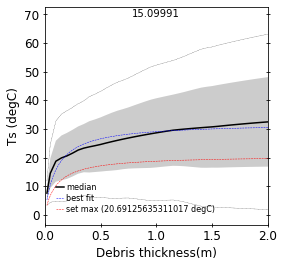

In [176]:
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
ts_max = func_coeff[0]+ts_offset_obj.x[0]
ts_4curve_setmax = ts_fromdebris_func(debris_4curve, ts_max, func_coeff[1])
label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

print(func_coeff[0], func_coeff[1])


figure_fn = 'debris_Ts_curve.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] - 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], 
             debris_ts_df_stats['ts_degC_med'] + 1.96*debris_ts_df_stats['ts_degC_nmad'],
             linestyle='--', zorder=1, linewidth=0.25, color='k')
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
             color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
# text
ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
             transform=ax[0,0].transAxes)
#eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
#ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#             transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 2)
#ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
ax[0,0].xaxis.set_tick_params(labelsize=12)
#ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
#ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  

In [28]:
print('\n\nDONE!\n\n')



DONE!




function coefficients: [53.96124898  0.72182063  0.40261078]


NameError: name 'gf' is not defined

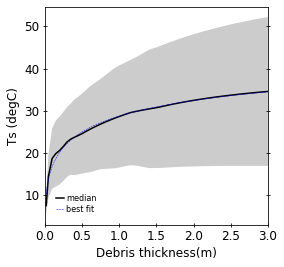

In [20]:
def ts_fromdebris_func(h, a, b, c):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
    Hill Equation"""
    return a * h**c / (b**c + h**c)
def debris_fromts_func(ts, a, b, c):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
    Hill Equation"""
    return (ts * b**c / (a - ts))**(1/c)

def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    ts = ts_raw.copy()
    max_value = ts_fromdebris_func(50, a, b, c)
    print(max_value)
    debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
    debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
    hd = debris_fromts_func(ts.data, tsmax, k)
    return hd

fit_idx = debris_ts_df_stats.index.values
# fit_idx = debris_ts_df_stats.index.values[0:40]
func_coeff, pcov = curve_fit(ts_fromdebris_func, 
                             debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
                             p0=[25,1,1],
                             bounds=((0,0,0.01),(100,4,1))
                             )
fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1], func_coeff[2])
debris_4curve = np.arange(0.02,3.01,0.01)
ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

print('function coefficients:', func_coeff)


figure_fn = 'debris_Ts_curve-hill.png'

# plot curve
fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
             '-', color='k', zorder=1, label='median')
ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
                     debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
                     debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
                      facecolor='k', alpha=0.2, zorder=1)
ax[0,0].plot(debris_4curve, ts_4curve, 
             color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
# text
# ax[0,0].text(0.5, 0.99, gf.glacnum, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# X-label
ax[0,0].set_xlabel('Debris thickness(m)', size=12)
ax[0,0].set_xlim(0, 3)
ax[0,0].xaxis.set_tick_params(labelsize=12)  
# Y-label
ax[0,0].set_ylabel('Ts (degC)', size=12)
# Tick parameters
ax[0,0].yaxis.set_ticks_position('both')
ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# Legend
ax[0,0].legend(loc=(0.05, 0.05), 
               fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
               frameon=False)          
# Save plot
fig.set_size_inches(4, 4)

# Apply to glacier
tsmax_offset = -11.4
#     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0], func_coeff[1], func_coeff[2])
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Uncalibrated Debris thickness (m)']
#     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
           close_fig=False)




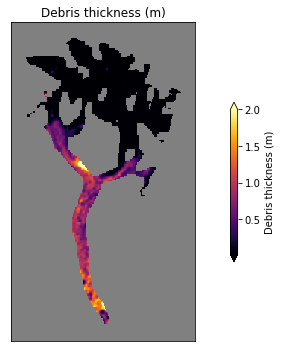

In [20]:
# ===== DEBRIS THICKNESS FROM RAW DATA =====
print('\n\nEQUATIONS MISS THIN OR THICK DEBRIS SO USE THE RAW DATA\n\n')
# Surface temperature dictionary
def ts_dict(debris_ts_df_stat, cn='ts_degC_mean', ts_offset=0):
    debris_ts_df_stats_adj = debris_ts_df_stats.copy()
    debris_ts_df_stats_adj[cn] = debris_ts_df_stats_adj[cn] + ts_offset
#     debris_ts_df_stats_adj['ts_degC_med'] = debris_ts_df_stats_adj['ts_degC_med'] + ts_offset
    ts_str_subset = np.array([str(np.round(x,2)) for x in debris_ts_df_stats_adj[cn].values])
    ts_dict = dict(zip(ts_str_subset, debris_ts_df_stats_adj['debris_thickness']))
    ts_step = 0.01
    ts = np.arange(np.round(debris_ts_df_stats_adj['ts_degC_mean'].min(),2), 
                  np.round(debris_ts_df_stats_adj['ts_degC_mean'].max(),2), ts_step)
    ts_str = np.array([str(np.round(x,2)) for x in ts])
    ds_ts_filled = pd.DataFrame(np.zeros((ts_str.shape[0], 3)), columns=['ts', 'ts_str', 'thickness'])
    ds_ts_filled['ts'] = ts
    ds_ts_filled['ts_str'] = ts_str
    ds_ts_filled['thickness'] = ds_ts_filled.ts_str.map(ts_dict)
    ds_ts_filled = ds_ts_filled.interpolate(method='linear', axis=0)
    ts_dict_filled = dict(zip(ds_ts_filled.ts_str, ds_ts_filled.thickness))
    ts_dict_filled['nan'] = 0
#     print(ts_dict_filled)
    return ds_ts_filled, ts_dict_filled



def ts_to_debristhickness_fromdata(ts, debris_ts_df_stats, cn='ts_degC_mean', ts_offset=0):
    # Create dictionary
    ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats, cn=cn, ts_offset=ts_offset)
    # Use dictionary to map thickness values
    gf.debris_thick_ts = ts.copy()
    gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts.data, ds_ts_filled.ts.max()), 
                                     mask=np.ma.getmask(ts))
    gf.debris_thick_ts = np.ma.array(maskedarray_lt(gf.debris_thick_ts.data, ds_ts_filled.ts.min()), 
                                     mask=np.ma.getmask(ts))
    # Round to nearest 0.01 deg and convert to string for dictionary
    gf.debris_thick_ts = np.round(gf.debris_thick_ts,2)
    gf.debris_thick_ts = gf.debris_thick_ts.astype(str)
    # Convert to thickness
    for key in ts_dict_filled:
        gf.debris_thick_ts[gf.debris_thick_ts == key] = ts_dict_filled[key]
    gf.debris_thick_ts = gf.debris_thick_ts.astype(float)
    return gf.debris_thick_ts

# ds_ts_filled, ts_dict_filled = ts_dict(debris_ts_df_stats)

# process
# Estimate initial guess based on setting max to 2 m
# ts_clim = malib.calcperc(gf.ts, (2,98))
# debris_2m_idx = np.where(debris_ts_df_stats.debris_thickness == 2)[0][0]
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean']
# print(ts_clim[1], debris_ts_df_stats.loc[debris_2m_idx,'ts_degC_mean'], ts_offset_init)
# ts_offset_init = ts_clim[1] - debris_ts_df_stats.ts_degC_mean.max()
# print(ts_clim[1], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
# ts_offset_init = ts_clim[0] - debris_ts_df_stats.ts_degC_mean.min()
# print(ts_clim[0], debris_ts_df_stats.ts_degC_mean.max(), ts_offset_init)
ts_offset_init = -10

gf.debris_thick_ts = ts_to_debristhickness_fromdata(gf.ts, debris_ts_df_stats, cn='ts_degC_mean', 
                                                    ts_offset=ts_offset_init)
gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
clim = (0.02,2)
plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png',
           close_fig=False)

# # # Export binned file
# # outbins_df, z_bin_edges = hist_plot(gf, outdir_csv, bin_width=bin_width)

In [26]:
print('\n\nOLD SCRIPT BELOW', 
      '\n !! INCLUDES MELT REDUCTION FACTOR !!\n\n')



OLD SCRIPT BELOW 
 !! INCLUDES MELT REDUCTION FACTOR !!




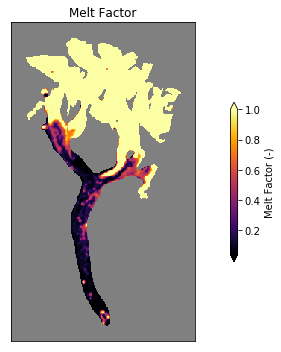

In [36]:
# ===== DEBRIS MELT ENHANCEMENT OR REDUCTION FACTOR =====
def meltfactor_fromdebris_func(h, a, k, melt_2cm):
    """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) """
    melt_h = a / (1 + 2 * k * a * h)
    melt_factor = melt_h / melt_2cm
    melt_factor[melt_factor > 1] = 1
    return melt_factor

idx_2cm = np.where(debris_melt_df.debris_thickness.values == 0.02)[0][0]
melt_2cm = debris_melt_df.loc[idx_2cm, 'melt_mwea']

outbins_df['meltfactor_ts'] = meltfactor_fromdebris_func(outbins_df['debris_thick_ts_med_m'].values, 
                                                         func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                                         melt_2cm)

# Plot debris thickness
gf.meltfactor_ts = meltfactor_fromdebris_func(gf.debris_thick_ts, 
                                               func_coeff_meltfromdebris[0], func_coeff_meltfromdebris[1], 
                                               melt_2cm)
gf.meltfactor_ts = np.ma.array(gf.meltfactor_ts, mask=glac_geom_mask)

gf.res = geolib.get_res(ds_dict['z1'])

titles = ['Melt Factor']
clim = malib.calcperc(gf.meltfactor_ts, (2,98))
plot_array(gf.meltfactor_ts, clim, titles, 'inferno', 'Melt Factor (-)', fn='../meltfactor.png')

In [48]:
# Export melt factor map
meltfactor_fullfn = debris_fullfn.replace('_debristhickness_','_meltfactor_')
iolib.writeGTiff(gf.meltfactor_ts, meltfactor_fullfn, ds_dict['z1'])

In [37]:
# ====== PROCESS BINNED DEBRIS THICKNESS DATA FOR USE ======
outbins_df, z_bin_edges = hist_plot(gf, outdir, bin_width=10)

print('NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!')

NOW EXPORT RESULTS TO FILE FORMAT WHERE ELEVATION IS CONSISTENT WITH FARINOTTI ICE THICKNESS!


In [38]:
debris_output_fp = '/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/output/'
debris_output_fn = 'debris_m_' + region.zfill(2) + '_10m.csv'
meltfactor_output_fn = 'meltfactor_' + region.zfill(2) + '_10m.csv'
hyps_fn = 'area_km2_' + region.zfill(2) + '_Farinotti2019_10m.csv'

# Load datasets or create a new dataset if it doesn't exist yet
area_df = pd.read_csv(debris_output_fp + hyps_fn)
if os.path.exists(debris_output_fp + debris_output_fn):
    debris_output = pd.read_csv(debris_output_fp + debris_output_fn)
    meltfactor_output = pd.read_csv(debris_output_fp + meltfactor_output_fn)
else:
    debris_output = pd.DataFrame(np.zeros(area_df.shape), columns=area_df.columns)
    debris_output['RGIId'] = area_df['RGIId']
    meltfactor_output = debris_output.copy()
    
rgi_idx = np.where(debris_output['RGIId'] == 'RGI60-' + glac_str)[0][0]
area_idx = np.where(area_df.iloc[rgi_idx,1:] > 0)[0]
area_cns = area_df.columns[1:][area_idx]

print(area_df.loc[rgi_idx, area_cns])

# All area that have ice set to clean ice to begin
debris_output.loc[rgi_idx, area_cns] = 0
meltfactor_output.loc[rgi_idx, area_cns] = 1
# add debris thickness and meltfactors
debris_cns = [str(int(np.round(x,0))) for x in outbins_df['bin_center_elev_m'].values]
debris_output.loc[rgi_idx, debris_cns] = outbins_df['debris_thick_ts_med_m'].values
meltfactor_output.loc[rgi_idx, debris_cns] = outbins_df['meltfactor_ts_med_m'].values

# Export files
debris_output.to_csv(debris_output_fp + debris_output_fn, index=False)
meltfactor_output.to_csv(debris_output_fp + meltfactor_output_fn, index=False)

print('\n\nAVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end\n\n')

print('\nClean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values\n')

4705    0.2175
4715    0.3225
4725    0.4675
4735    0.5825
4745      0.37
         ...  
8145    0.0375
8155    0.0275
8165    0.0275
8175    0.0325
8185     0.005
Name: 3472, Length: 349, dtype: object


AVOID LOADING AND EXPORTING EVERY GLACIER WHEN SCALING THIS UP - only do once at start and end



Clean ice has 0.02 m of debris (meltfactor = 1) - remove this so only debris covered areas have values



In [39]:
region

'15'

In [ ]:
print('\n\n\nOLD CODE NO LONGER RELEVANT\n\n')
# # ===== ESTIMATE DEBRIS THICKNESS =====
# #Now apply glacier mask AND mask NaN values
# # # glac_geom_mask = np.ma.mask_or(glac_geom_mask, dems_mask)
# # # gf.debris_thick_ts = np.ma.array(iolib.ds_getma(ds_dict['ts']), mask=glac_geom_mask)
# # k = 0.13
# # Tsmax_offset = 6
# # Tsmax = gf.ts.max() + Tsmax_offset
# # gf.debris_thick_ts = gf.ts * 0.13 / (Tsmax - gf.ts)

# Tsmax_offset = 0
# Tsmax = gf.ts.max() + Tsmax_offset
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, hill_func_coeff[0], hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thic_tsk>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())

# print(mb_df.loc[debris_idx,['# bin_center_elev_m', ' vm_med', ' H_mean',
#        'debris_thickness', 'debris_thickness_1stdlow', 'debris_thickness_1stdhigh', 'debris_thickness_fromTs', 'debris_thickness_fromTs_mad']])

# ===== OPTIMIZE TS_MAX BASED ON THE SUBDEBRIS MELT INVERSION METHOD ======
# from scipy.optimize import minimize

# def objective(Ts_max):
#     """
#     Objective function to fit Ts_max for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_max : np.float64
#         Maximum surface temperature for Hill equation

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
    
#     # Debris thickness from Hill Equation
#     gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, Ts_max, hill_func_coeff[1], hill_func_coeff[2])
    
#     # Bin debris thicknesses
#     outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
    
#     outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
#     outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
#     mb_df['debris_thickness_fromTs'] = np.nan
#     mb_df['debris_thickness_fromTs_mad'] = np.nan
#     for x in mb_df.index.values:
#         if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#             mb_df.loc[x,'debris_thickness_fromTs'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#             mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                     outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
    
#     # Compare only over bins with low velocity and lots of debris
#     vel_lt10_idx_raw = np.where((mb_df[' vm_med'] < 7.5) & (mb_df[' perc_debris'] > 50))[0]
#     # only work with terminus
#     vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#     idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#     vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]

#     debris_dif_sum = (mb_df.loc[vel_lt10_idx, 'debris_thickness_fromTs'] - mb_df.loc[vel_lt10_idx,'debris_thickness']).sum()
    
#     debris_dif_sum_abs = abs(debris_dif_sum)

#     return debris_dif_sum_abs


# ts_max_obj = minimize(objective, hill_func_coeff[0], method='SLSQP',
#                       options={'ftol':1e-3, 'eps':0.1}
#                      )
# ts_max_opt = ts_max_obj.x[0]

# print(ts_max_opt)

# ===== OUTPUT FINAL DEBRIS THICKNESS =====
# gf.debris_thick_ts = debris_fromts_func_hill(gf.ts, ts_max_opt, hill_func_coeff[1], hill_func_coeff[2])

# # gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=glac_geom_mask)
# # gf.debris_thick_ts  = np.ma.masked_less_equal(gf.debris_thick_ts, 0)
# # gf.debris_thick_ts[gf.debris_thick_ts>1] = 1

# gf.res = geolib.get_res(ds_dict['z1'])

# titles = ['Debris thickness (m)']
# clim = malib.calcperc(gf.debris_thick_ts, (2,98))
# plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn='../debris_thickness.png')

# # Plot optimized curve
# debris_4curve = np.arange(0.02,5.01,0.01)
# ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1], func_coeff[2])

# figure_fn = 'debris_Ts_curve_Hill_optimized.png'

# # plot curve
# fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
# #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
# ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,0].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,0].set_xlabel('Debris thickness(m)', size=12)
# ax[0,0].set_xlim(0, 2)
# ax[0,0].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,0].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,0].yaxis.set_ticks_position('both')
# ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,0].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# ax[0,1].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#              '-', color='k', zorder=1, label='median')
# ax[0,1].fill_between(debris_ts_df_stats['debris_thickness'], 
#                      debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                      debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                      facecolor='k', alpha=0.2, zorder=1)
# ax[0,1].plot(debris_4curve, ts_4curve, 
#              color='b', linewidth=0.5, linestyle='--', zorder=2, label='optimized')
# # text
# ax[0,1].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#              transform=ax[0,0].transAxes)
# # X-label
# ax[0,1].set_xlabel('Debris thickness(m)', size=12)
# ax[0,1].set_xlim(0, 0.25)
# ax[0,1].xaxis.set_tick_params(labelsize=12)
# # Y-label
# ax[0,1].set_ylabel('Ts (degC)', size=12)
# # Tick parameters
# ax[0,1].yaxis.set_ticks_position('both')
# ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
# ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
# # Legend
# ax[0,1].legend(loc=(0.05, 0.05), 
#                fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                frameon=False)    

# # Save plot
# fig.set_size_inches(6, 4)
# fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300) 

# # Export binned file
# outbins_df, z_bin_edges = hist_plot_wdebris(gf, outdir_csv, bin_width=bin_width)
# outbins_df['debris*area'] = outbins_df['debris_thick_med_m'] * outbins_df['z1_bin_area_valid_km2']
# outbins_df['debris*area_mad'] = outbins_df['debris_thick_mad_m'] * outbins_df['z1_bin_area_valid_km2']
# mb_df['debris_thickness_fromTs'] = np.nan
# mb_df['debris_thickness_fromTs_mad'] = np.nan
# for x in mb_df.index.values:
#     if ~np.isnan(mb_df.loc[x,'em_idx_low']):
#         mb_df.loc[x,'debris_thickness_fromTs'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
#         mb_df.loc[x,'debris_thickness_fromTs_mad'] = (
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'debris*area_mad'].sum() / 
#                 outbins_df.loc[mb_df.loc[x,'em_idx_low']:mb_df.loc[x,'em_idx_high'], 'z1_bin_area_valid_km2'].sum())
# mb_df.to_csv(outdir_csv + '/' + glac_str + '_mb_bins_wdebris_inversions_Hill.csv', index=False)

In [ ]:
# ===== MICHAELIS-MENTEN EQUATION IN WORKING CONDITION! ============================================================
#     # ===== UNCALIBRATED: PLOT AND FIT CURVE (NONLINEAR REGRESSION) =====
#     print('UNCALIBRATED: Michaelis-Menten Equation shown below')
#     #def ts_fromdebris_func(h, a, k):
#     #    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#     #    Michaelis-Menten Equation from single-substrate reactions"""
#     #    return a - a*np.exp(-k*h)
#     def ts_fromdebris_func(h, a, k):
#         """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#         hyperbolic fit"""
#         return a * h / (k + h)
#     def debris_fromts_func(ts, a, k):
#         """ estimate debris thickness from Ts (b is melt, a and k are coefficients) """
#         return k * ts / (a - ts)

#     def debris_fromts_maskedarray(ts_raw, tsmax, k):
#         """ Apply debris_fromts_func to masked array
#             includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
#         Parameters
#         ----------
#         ts_raw : np.ma.array
#             masked array of the unmodified surface temperature
#         Returns
#         -------
#         hd : np.ma.array 
#             masked array of the debris thickness (m)
#         """
#         ts = ts_raw.copy()
#         max_value = ts_fromdebris_func(1000, tsmax, k)
#         debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
#         debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
#         hd = debris_fromts_func(ts.data, tsmax, k)
#         return hd
    
#     print(debris_ts_df_stats.loc[0:10,:])

#     # fit_idx = debris_ts_df_stats.index.values
#     fit_idx = debris_ts_df_stats.index.values[0:40]
#     # print('\nFIT ONLY TO DEBRIS THICKNESSES:', debris_ts_df_stats.debris_thickness.values[fit_idx], 
#     #       '\nTO ENSURE CAPTURES CURVE \n(plot with equal spacing to avoid this issue, but computationally expensive)')
#     func_coeff, pcov = curve_fit(ts_fromdebris_func, 
#                                  debris_ts_df_stats.debris_thickness.values[fit_idx], debris_ts_df_stats.ts_degC_med.values[fit_idx],
#     #                             p0=[30,0.3]
#                                  bounds=[(-np.inf, 0), (np.inf, np.inf)]
#                                  )
#     fit_melt = ts_fromdebris_func(debris_ts_df_stats.debris_thickness.values, func_coeff[0], func_coeff[1])
#     debris_4curve = np.arange(0.02,3.01,0.01)
#     ts_4curve = ts_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
#     ts_offset = -11.4
#     ts_4curve_setmax = ts_fromdebris_func(debris_4curve, func_coeff[0] + ts_offset, func_coeff[1])
#     label_4tscurve = 'set max ('+ str(ts_max) + ' degC)'

#     print(func_coeff[0], func_coeff[1])


#     figure_fn = 'debris_Ts_curve.png'

#     # plot curve
#     fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#     #ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_mean'], '-', zorder=1, label='mean')
#     ax[0,0].plot(debris_ts_df_stats['debris_thickness'], debris_ts_df_stats['ts_degC_med'], 
#                  '-', color='k', zorder=1, label='median')
#     ax[0,0].fill_between(debris_ts_df_stats['debris_thickness'], 
#                          debris_ts_df_stats['ts_degC_med'] - debris_ts_df_stats['ts_degC_nmad'], 
#                          debris_ts_df_stats['ts_degC_med'] + debris_ts_df_stats['ts_degC_nmad'],
#                           facecolor='k', alpha=0.2, zorder=1)
#     ax[0,0].plot(debris_4curve, ts_4curve, 
#                  color='b', linewidth=0.5, linestyle='--', zorder=2, label='best fit')
#     ax[0,0].plot(debris_4curve, ts_4curve_setmax, 
#                  color='r', linewidth=0.5, linestyle='--', zorder=2, label=label_4tscurve)
#     # text
#     ax[0,0].text(0.5, 0.99, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
#                  transform=ax[0,0].transAxes)
#     #eqn_text = r'$T_{s} = \frac{T_{s,max} h}{k + h}$'
#     #coeff1_text = r'$T_{s,max} = ' + str(np.round(func_coeff[0],2)) + '$' 
#     #coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
#     ## coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
#     #ax[0,0].text(0.05, 0.9, eqn_text, size=12, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.06, 0.79, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.09, 0.74, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     #ax[0,0].text(0.09, 0.67, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
#     #             transform=ax[0,0].transAxes)
#     # X-label
#     ax[0,0].set_xlabel('Debris thickness(m)', size=12)
#     ax[0,0].set_xlim(0, 3)
#     #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
#     ax[0,0].xaxis.set_tick_params(labelsize=12)
#     #ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
#     #ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
#     # Y-label
#     ax[0,0].set_ylabel('Ts (degC)', size=12)
#     #ax[0,0].set_ylim(0,(int(debris_ts_df.melt_mwea.values.max()/0.1)+3)*0.1)
#     #ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(10))
#     #ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(2))
#     # Tick parameters
#     ax[0,0].yaxis.set_ticks_position('both')
#     ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
#     ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in')     
#     # Legend
#     ax[0,0].legend(loc=(0.05, 0.05), 
#                    fontsize=8, labelspacing=0.25, handlelength=1, handletextpad=0.25, borderpad=0, 
#                    frameon=False)          
#     # Save plot
#     fig.set_size_inches(4, 4)
#     # fig.savefig(output_fp + figure_fn, bbox_inches='tight', dpi=300)  
    
#     # Apply to glacier
#     tsmax_offset = -11.4
# #     print(np.nanmax(gf.ts.data), ts_fromdebris_func(1000, func_coeff[0]+tsmax_offset, func_coeff[1]))

#     gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+tsmax_offset, func_coeff[1])
#     gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#     titles = ['Uncalibrated Debris thickness (m)']
# #     clim = malib.calcperc(gf.debris_thick_ts, (2,98))
#     clim = (0.02,2)
#     plot_array(gf.debris_thick_ts, clim, titles, 'inferno', 'Debris thickness (m)', fn=outdir_fig + gf.feat_fn +'_hd.png',
#                close_fig=False)
    
# # ===== OPTIMIZE BASED ON THE SUB-DEBRIS MELT DEBRIS THICKNESS ESTIMATES =====
# from scipy.optimize import minimize
# def objective(ts_offset):
#     """
#     Objective function to fit Ts_offset for the surface temperature inversions to the subdebris melt inversions

#     Parameters
#     ----------
#     Ts_offset : np.float64
#         Temperature offset used to shift data/curve up or down

#     Returns
#     -------
#     debris_dif
#         Returns the difference in debris thickness for the subdebris and surface temp inversions
#     """
#     # Column name to run objective on
#     hd_cn = 'hd_wem'
    
#     df_wdebris_all = None
#     for ngf, gf in enumerate(gf_list):
# #     for ngf, gf in enumerate([gf_list[7]]):
# #         print(ngf, gf.glacnum)
#         # Debris thickness from Michaelis-Mentin Equation
#         gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
#         gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
# #         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#         # COMPARE DEBRIS THICKNESSES
#         # Bin debris thicknesses
#         outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
#         # Load data
#         glac_idx = main_glac_rgi_subset.index.values[ngf]
#         df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
#         df_wdebris['glac_str'] = gf.glacnum
#         # Reduce sub-debris melt inversion debris to max debris if needed
#         df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

#         # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
#         df_wdebris['hd_ts'] = -9999
#         # start index for merge
#         if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
#             df_idx1 = 0
#             outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
#         else:
#             outbins_idx1 = 0
#             df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx1:', 
#         #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
#         # end index for merge
#         if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
#             outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
#             df_idx2 = df_wdebris.shape[0]-1
#         else:
#             outbins_idx2 = outbins_df.shape[0]-1
#             df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx2:', 
#         #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

#         df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

#         # ===== Get desired indices for comparison =====
#         # Compare only low velocity, debris-covered bins
#         vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
#                                     & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
#                                     & (df_wdebris['hd_ts'] > -9999)
#                                    )[0]
        
# #         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
#         if len(vel_lt10_idx_raw) > 0:
#             # only work with terminus
#             vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#             if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
#                 vel_lt10_idx = vel_lt10_idx_raw
#             else:
#                 idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#                 vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
#             df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
#             df_wdebris_subset.reset_index(inplace=True, drop=True)
            
# #             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             # Remove any bins with negative debris thickness or maximum debris thickness
#             vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
#                                               & (df_wdebris_subset[hd_cn] < input.hd_max)
#                                              )[0]
            
# #             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
# #             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

# #             Remove any bins with maximum debris thickness
# #             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
#             if df_wdebris_all is None:
#                 df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
#             else:
#                 df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

#     df_wdebris_all.reset_index(inplace=True, drop=True)
    
#     # Non-weighted difference
#     debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
#     # Weighted difference
#     debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
#                       df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

#     debris_dif_sum_abs = abs(debris_dif_sum)

#     print(ts_offset, debris_dif_sum_abs)

#     return debris_dif_sum_abs


# def run_objective(ts_offset):
    
#     # Column name to run objective on
#     hd_cn = 'hd_wem'
    
#     df_wdebris_all = None
#     for ngf, gf in enumerate(gf_list):
# #     for ngf, gf in enumerate([gf_list[7]]):
# #         print(ngf, gf.glacnum)
#         # Debris thickness from Michaelis-Mentin Equation
#         gf.debris_thick_ts = debris_fromts_maskedarray(gf.ts, func_coeff[0]+ts_offset, func_coeff[1])
#         gf.debris_thick_ts = np.ma.array(maskedarray_gt(gf.debris_thick_ts,input.hd_max), mask=np.ma.getmask(gf.ts))
# #         gf.debris_thick_ts = np.ma.array(gf.debris_thick_ts, mask=np.ma.getmask(gf.ts))

#         # COMPARE DEBRIS THICKNESSES
#         # Bin debris thicknesses
#         outbins_df, z_bin_edges = hist_plot(gf, bin_width=mb_bin_size)
        
#         # Load data
#         glac_idx = main_glac_rgi_subset.index.values[ngf]
#         df_wdebris = pd.read_csv(input.mb_binned_fp_wdebris + main_glac_rgi_subset.loc[glac_idx,'bin_fn'])
#         df_wdebris['glac_str'] = gf.glacnum
#         # Reduce sub-debris melt inversion debris to max debris if needed
#         df_wdebris.loc[df_wdebris[hd_cn] > input.hd_max, hd_cn] = input.hd_max

#         # ===== Add debris thickness from surface temperature inversion to mb_wdebris dataset =====
#         df_wdebris['hd_ts'] = -9999
#         # start index for merge
#         if df_wdebris.loc[0,'# bin_center_elev_m'] >= outbins_df.loc[0,'bin_center_elev_m']:
#             df_idx1 = 0
#             outbins_idx1 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[0,'# bin_center_elev_m'])[0][0]
#         else:
#             outbins_idx1 = 0
#             df_idx1 = np.where(outbins_df.loc[0,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx1:', 
#         #       '\noutbins:', outbins_idx1, outbins_df.loc[outbins_idx1,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx1, df_wdebris.loc[df_idx1,'# bin_center_elev_m'])
#         # end index for merge
#         if outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] >= df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m']:
#             outbins_idx2 = np.where(outbins_df['bin_center_elev_m'] == df_wdebris.loc[df_wdebris.shape[0]-1,'# bin_center_elev_m'])[0][0]
#             df_idx2 = df_wdebris.shape[0]-1
#         else:
#             outbins_idx2 = outbins_df.shape[0]-1
#             df_idx2 = np.where(outbins_df.loc[outbins_df.shape[0]-1,'bin_center_elev_m'] == df_wdebris['# bin_center_elev_m'])[0][0]
#         # print('idx2:', 
#         #       '\noutbins:', outbins_idx2, outbins_df.loc[outbins_idx2,'bin_center_elev_m'],
#         #       '\ndfbins:', df_idx2, df_wdebris.loc[df_idx2,'# bin_center_elev_m'])

#         df_wdebris.loc[df_idx1:df_idx2+1,'hd_ts'] = outbins_df.loc[outbins_idx1:outbins_idx2+1,'debris_thick_ts_med_m']

#         # ===== Get desired indices for comparison =====
#         # Compare only low velocity, debris-covered bins
#         vel_lt10_idx_raw = np.where((df_wdebris[' vm_med'] < input.vel_threshold) 
#                                     & (df_wdebris[' perc_debris'] > input.debrisperc_threshold)
#                                     & (df_wdebris['hd_ts'] > -9999)
#                                    )[0]
        
# #         print('vel_lt10_idx_raw:', vel_lt10_idx_raw)
        
#         if len(vel_lt10_idx_raw) > 0:
#             # only work with terminus
#             vel_idx_dif = list(vel_lt10_idx_raw[1:] - vel_lt10_idx_raw[:-1])
#             if np.sum(vel_idx_dif) == len(vel_lt10_idx_raw)-1:
#                 vel_lt10_idx = vel_lt10_idx_raw
#             else:
#                 idx_jumpinbins = vel_idx_dif.index(next(filter(lambda x: x>1, vel_idx_dif)))
#                 vel_lt10_idx = vel_lt10_idx_raw[0:idx_jumpinbins+1]
            
#             df_wdebris_subset = df_wdebris.loc[vel_lt10_idx,:]
#             df_wdebris_subset.reset_index(inplace=True, drop=True)
            
# #             print(df_wdebris_subset[['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

#             # Remove any bins with negative debris thickness or maximum debris thickness
#             vel_lt10_idx_posdebris = np.where((df_wdebris_subset[hd_cn] > 0)
#                                               & (df_wdebris_subset[hd_cn] < input.hd_max)
#                                              )[0]
            
# #             print('vel_lt10_posdebris:', vel_lt10_idx_posdebris)
# #             print(df_wdebris_subset.loc[vel_lt10_idx_posdebris,['# bin_center_elev_m', ' vm_med', ' perc_debris', 'hd', 'hd_wem']])

# #             Remove any bins with maximum debris thickness
# #             vel_lt10_idx_posdebris = np.where(df_wdebris_subset.loc[vel_lt10_idx_posdebris,hd_cn] < input.hd_max)[0]
            
#             if df_wdebris_all is None:
#                 df_wdebris_all = df_wdebris.loc[vel_lt10_idx_posdebris,:]
#             else:
#                 df_wdebris_all = pd.concat([df_wdebris_all, df_wdebris.loc[vel_lt10_idx_posdebris,:]], axis=0)

#     df_wdebris_all.reset_index(inplace=True, drop=True)
    
#     # Non-weighted difference
#     debris_dif_sum = (df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]).sum()
    
#     # Weighted difference
#     debris_dif_sum = ((df_wdebris_all['hd_ts'] - df_wdebris_all[hd_cn]) * 
#                       df_wdebris_all[' z1_bin_area_valid_km2'] * df_wdebris_all[' perc_debris'] / 100).sum()

#     debris_dif_sum_abs = abs(debris_dif_sum)

#     print(ts_offset, debris_dif_sum_abs)

# #     return df_wdebris_all, vel_lt10_idx  
#     return df_wdebris_all

# mb_df = run_objective(0)

In [1]:
# #! /usr/bin/env python
# """
# Compute debris thickness through sub-debris and temperature inversion methods
# """
# import sys
# import os
# import re
# import subprocess
# from datetime import datetime, timedelta
# import time
# import pickle
# from collections import OrderedDict

# import geopandas as gpd
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import rasterio
# from scipy import ndimage
# from scipy.optimize import curve_fit
# from scipy.optimize import minimize
# import xarray as xr
# from osgeo import gdal, ogr, osr

# from pygeotools.lib import malib, warplib, geolib, iolib, timelib
# # from imview.lib import pltlib

# import globaldebris_input as input

# print('\nOVERRIDING INPUT ROI\n\n')
# input.roi = '01'

# verbose=False
# debug=False
# extra_layers=True
# min_glac_area_writeout = input.min_glac_area_writeout
# min_valid_area_perc = input.min_valid_area_perc
# buff_dist = input.buff_dist
# # bin_width = input.emvel_bin_width
# #Surface to column average velocity scaling
# v_col_f = input.v_col_f
# csv_ending = input.output_ts_csv_ending
# emvel_filter_pixsize = input.emvel_filter_pixsize

# #INPUT
# glac_shp_fn_dict = {'13':input.main_directory + '/../../../HiMAT/RGI/rgi60/13_rgi60_CentralAsia/13_rgi60_CentralAsia.shp',
#                     '14':input.main_directory + '/../../../HiMAT/RGI/rgi60/14_rgi60_SouthAsiaWest/14_rgi60_SouthAsiaWest.shp',
#                     '15':input.main_directory + '/../../../HiMAT/RGI/rgi60/15_rgi60_SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'}
# glac_shp_proj_fp = input.output_fp + 'glac_shp_proj/'
# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)


# #DEM
# z1_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/surface_DEMs_RGI60/' + 
#           'surface_DEMs_RGI60-XXXX/')
# z1_fn_sample = 'surface_DEM_RGI60-XXXX.tif'
# # Ice thickness
# huss_dir_sample = ('/Users/davidrounce/Documents/Dave_Rounce/HiMAT/IceThickness_Farinotti/' + 
#                    'composite_thickness_RGI60-all_regions/RGI60-XXXX/')
# huss_fn_sample = 'RGI60-XXXX_thickness.tif'
# #Surface velocity
# v_dir = input.main_directory + '/../../../Satellite_Images/ITS_Live'
# vx_fn = os.path.join(v_dir, 'HMA_G0120_0000_vx.tif')
# vy_fn = os.path.join(v_dir, 'HMA_G0120_0000_vy.tif')

# # topdir='/Users/davidrounce/Documents/Dave_Rounce/HiMAT/DEMs/'
# # #Output directory
# # outdir = topdir + 'Shean_2019_0213/mb_combined_20190213_nmad_bins/'
# # outdir_fig = outdir + '/figures/'
# outdir_csv = input.outdir_emvel_fp 
# outdir_fig = input.outdir_emvel_fp  + '../figures/'

# if os.path.exists(glac_shp_proj_fp) == False:
#     os.makedirs(glac_shp_proj_fp)
# if os.path.exists(outdir_csv) == False:
#     os.makedirs(outdir_csv)
# if os.path.exists(outdir_fig) == False:
#     os.makedirs(outdir_fig)


OVERRIDING INPUT ROI




In [2]:
outdir_csv = input.output_fp + 'mb_bins/csv_v1/'

In [3]:
# # ===== DEBRIS ELEVATION STATS ====================================================================================
# # Glaciers with data
# glac_wobs_fns = []
# rgiid_wobs = []
# for i in os.listdir(outdir_csv):
#     if i.endswith('_mb_bins_wdc_emvel_offset.csv'):
#         glac_wobs_fns.append(i)
#         rgiid_reg = int(i.split('.')[0])
#         if rgiid_reg < 10:
#             rgiid_wobs.append(i[0:7])
#         else:
#             rgiid_wobs.append(i[0:8])
        
# glac_wobs_fns = sorted(glac_wobs_fns)
# rgiid_wobs = sorted(rgiid_wobs)

# # ===== SELECT GLACIERS WITH DATA =====
# main_glac_rgi_wobs = input.selectglaciersrgitable(rgiid_wobs)
# main_glac_rgi_wobs['mb_bin_fn'] = glac_wobs_fns 
# main_glac_rgi_wobs['CenLon_360'] = 360 + main_glac_rgi_wobs['CenLon']
# ds = xr.open_dataset(input.metdata_fp + '../' + input.metdata_elev_fn)
# #  argmin() finds the minimum distance between the glacier lat/lon and the GCM pixel
# lat_nearidx = (np.abs(main_glac_rgi_wobs['CenLat'].values[:,np.newaxis] - 
#                       ds['latitude'][:].values).argmin(axis=1))
# lon_nearidx = (np.abs(main_glac_rgi_wobs['CenLon_360'].values[:,np.newaxis] - 
#                       ds['longitude'][:].values).argmin(axis=1))
# latlon_nearidx = list(zip(lat_nearidx, lon_nearidx))
# latlon_nearidx_unique = sorted(list(set(latlon_nearidx)))
# main_glac_rgi_wobs['latlon_nearidx'] = latlon_nearidx
# latlon_unique_dict = dict(zip(latlon_nearidx_unique,np.arange(0,len(latlon_nearidx_unique))))
# latlon_unique_dict_reversed = dict(zip(np.arange(0,len(latlon_nearidx_unique)),latlon_nearidx_unique))
# main_glac_rgi_wobs['latlon_unique_no'] = main_glac_rgi_wobs['latlon_nearidx'].map(latlon_unique_dict)

# print('unique lat/lons:', len(np.unique(main_glac_rgi_wobs['latlon_unique_no'])), '\n\n')
# # print(dc_shp_subset_wdata.loc[0:5,['RGIId', 'CenLat', 'CenLon', 'larsen_fn', 'braun_fn', 'latlon_unique_no']])

# lat_list = np.array([ds.latitude[x[0]].values for x in latlon_nearidx_unique])
# lon_list = np.array([ds.longitude[x[1]].values for x in latlon_nearidx_unique])
# latlon_list = list(tuple(zip(list(lat_list), list(lon_list))))

# # ===== CALCULATE DEBRIS ELEVATION STATS FOR GLACIERS WITH DATA FOR EACH UNIQUE LAT/LON ======
# elev_stats_latlon_dict = {}
# latlon_list_updated = []
# for nlatlon, latlon_unique in enumerate(np.unique(main_glac_rgi_wobs.latlon_unique_no)):
# # for nlatlon, latlon_unique in enumerate([np.unique(main_glac_rgi_wobs.latlon_unique_no)[6]]):

#     main_glac_rgi_subset = main_glac_rgi_wobs[main_glac_rgi_wobs['latlon_unique_no'] == latlon_unique]
    
#     # Debris elevation stats should be done by lat/lon
#     df_all = None
#     elev_list_all = []
#     df_idx_count = 0
#     for nglac, glac_fn in enumerate(main_glac_rgi_subset.mb_bin_fn.values):
#         df_raw = pd.read_csv(outdir_csv + glac_fn)
#         df = df_raw.dropna(subset=[' mb_bin_mean_mwea'])
#         df_debris = df[(df[' vm_med'] < input.vel_threshold) & (df['debris_perc'] > input.debrisperc_threshold)
#                        & (df[' dc_bin_count_valid'] > 0)]

#         df_idx = df_debris.index.values
#         df_idx_count += len(df_idx)
        
#         if len(df_idx) > 0:
#             # only work with terminus
#             df_idx_dif = list(df_idx[1:] - df_idx[:-1])
#             if np.sum(df_idx_dif) == len(df_idx)-1:
#                 df_idx_nojump = df_idx
#             else:
#                 idx_jumpinbins = df_idx_dif.index(next(filter(lambda x: x>1, df_idx_dif)))
#                 df_idx_nojump = df_idx[0:idx_jumpinbins+1]

#             df_debris_nojump = df_debris.loc[df_idx_nojump,:]
#             df_debris_nojump.reset_index(inplace=True, drop=True)
            
#             for nelev, elev in enumerate(list(df_debris_nojump['bin_center_elev_m'].values)):
#                 elev_list_single = list(np.repeat(elev, df_debris_nojump.loc[nelev,' dc_bin_count_valid']))
#                 elev_list_all.extend(elev_list_single)
        
#     if df_idx_count > 0:
#         dc_zmean = np.mean(elev_list_all)
#         dc_zstd = np.std(elev_list_all)
#         dc_zmed = malib.fast_median(elev_list_all)
#         dc_zmad = malib.mad(elev_list_all)

#         lat_deg = float(ds.latitude[latlon_unique_dict_reversed[latlon_unique][0]].values)
#         lon_deg = float(ds.longitude[latlon_unique_dict_reversed[latlon_unique][1]].values)
#         elev_stats_latlon_dict[lat_deg,lon_deg] = [dc_zmean, dc_zstd, dc_zmed, dc_zmad]
#         latlon_list_updated.append((lat_deg, lon_deg))

# # Update pickle of unique lat/lons that will be used for melt model
# with open(input.latlon_unique_fp + input.latlon_unique_dict[input.roi], 'wb') as f:
#     pickle.dump(latlon_list_updated, f)

793 glaciers in region 1 are included in this model run: ['00013', '00021', '00037', '00041', '00042', '00556', '00570', '00571', '00660', '00670', '00675', '00688', '00703', '00704', '00709', '00732', '00739', '00746', '00780', '00787', '00792', '00799', '00814', '00852', '00865', '00870', '00871', '00903', '00942', '00951', '00960', '00962', '00982', '01050', '01077', '01104', '01150', '01153', '01162', '01182', '01223', '01242', '01268', '01275', '01276', '01277', '01282', '01284', '01292', '01306'] and more
This study is focusing on 793 glaciers in region [1]
unique lat/lons: 278 




In [4]:
# # ===== ADD DEBRIS ELEVATION STATS TO MET DATA ======
# # for nlatlon, latlon in enumerate(latlon_list_updated):
# for nlatlon, latlon in enumerate([latlon_list_updated[0]]):
    
#     lat_deg = latlon[0]
#     lon_deg = latlon[1]

#     # ===== Meteorological data =====
#     metdata_fn = input.metdata_fn_sample.replace('XXXX', 
#                                                  str(int(lat_deg*100)) + 'N-' + str(int(lon_deg*100)) + 'E-')
    
#     ds = xr.open_dataset(input.metdata_fp + metdata_fn)
#     if 'dc_zmean' not in list(ds.keys()):
#         print('added')
#         # Add stats
#         ds['dc_zmean'] = elev_stats_latlon_dict[latlon][0]
#         ds['dc_zmean'].attrs = {'units':'m a.s.l.', 'long_name':'Mean debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zstd'] = elev_stats_latlon_dict[latlon][1]
#         ds['dc_zstd'].attrs = {'units':'m a.s.l.', 'long_name':'Standard deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zmed'] = elev_stats_latlon_dict[latlon][2]
#         ds['dc_zmed'].attrs = {'units':'m a.s.l.', 'long_name':'Median debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}
#         ds['dc_zmad'] = elev_stats_latlon_dict[latlon][3]
#         ds['dc_zmad'].attrs = {'units':'m a.s.l.', 'long_name':'Median absolute deviation of debris cover elevation', 'comment':'converted from debris cover with data that will be used for subdebris melt inversion'}

#         try:
#             ds.close()
#         except:
#             continue

#         # Export updated dataset
#         ds.to_netcdf(input.metdata_fp + metdata_fn, mode='a')